In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from ast import literal_eval
import re
from scipy import stats
from random import sample

In [2]:
import seaborn as sns

In [3]:
import matplotlib.gridspec as gridspec

In [4]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

In [5]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_cd8': literal_converter,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,
              'HLA_pool_cd8':cdr3_lst_converter,
              'HLA_cd8': HLA_cd8_converter,
              'HLA_lst_cd8':literal_converter,'sample_id_lst':literal_converter} #

In [6]:
INPUT = '../experiments/exp13/run1_archive/cat/tables/tcr_barcode.cleaned.csv' #run2
df = pd.read_csv(INPUT, converters=converters) #

In [7]:
df.sample_id_lst[0]

[5, 4, 1, 9, 8, 7, 10, 2, 3, 6]

In [8]:
def get_likely_targets(row):
    from itertools import compress
    if (type(row.HLA_cd8) is list) & (type(row.HLA_lst_mhc) is list):
        chec = [item in row.HLA_cd8 for item in row.HLA_lst_mhc]
        idxs = list(compress(range(len(chec)), chec))
        #return [chec, row.HLA_lst_mhc, row.HLA_cd8, idxs]
        #return [row[var][i] for i in idxs]
        if idxs == []:
            return np.nan
        else:
            return [row.HLA_lst_mhc[i] for i in idxs]
    else:
        return np.nan

In [11]:
class Evaluate_Clonotype():
    """
    An instance is a clonotype subset of the data.
    """
    value_bin = set() # clonotypes Evaluate_Clonotype.value_bin
    trash_bin = set() # peptide-HLAs
    ct_checks = dict()
    
    def __init__(self, df, ct, selected_clonotypes, use_relative_umi=False, variable='peptide_HLA'):
        self.df = df[df.ct == ct]
        self.ct = int(ct)
        self.idx = self.df.index
        self.rel_umi = use_relative_umi
        self.fig_flg = 'None'
        self.variable = variable
        
        if self.variable == 'peptide_HLA':
            self.var_lst = 'peptide_HLA_lst'
            self.umi_lst = 'umi_count_lst_mhc'
        elif self.variable == 'sample_id':
            self.var_lst = 'sample_id_lst'
            self.umi_lst = 'umi_count_lst_cd8'
        elif self.variable == 'HLA_cd8':
            self.var_lst = 'HLA_pool_cd8'
            self.umi_lst = 'umi_count_lst_cd8'
        
        # Initialize list of clonotypes
        self.sel_cts = selected_clonotypes
        self.sel_cts.index = self.sel_cts.index.astype(int)
        
        # Initialize matrix of query count per GEM (not method (df is not self))
        self.queries = df[self.var_lst].explode().drop_duplicates() #.unique()
        self.mat = pd.DataFrame(index=self.queries, columns=df.gem.unique()) # added .unique() to index
        
        # Count no. of GEMs within grp that are annotated with a specific pMHC (method?)
        self.gems_per_query = self.df.explode(self.variable).groupby(self.variable).size() # explode only really necessary for HLA_pool_cd8, but doesnt make a difference for other variables.
        self.gems_per_all_q = pd.concat([self.gems_per_query,
                                         pd.Series(0, index=self.queries[~self.queries.isin(self.gems_per_query.index)])])    
        
    def sum_umi(self):
        # Sum UMIs for each peptide across GEMs (multiple peptides per GEM)
        for idx, row in self.df.iterrows():
            if self.variable == 'HLA_cd8':
                var = 'HLA_lst_cd8'
                var_lst = [item for sublist in row[var] for item in sublist if item != '']
                umi_lst = [row[self.umi_lst][i] for i, sublist in enumerate(row[var]) for item in sublist if item != '']
            else:
                var = self.var_lst
                var_lst = row[self.var_lst]
                umi_lst = row[self.umi_lst]
                
            if len(row[self.umi_lst]) == len(row[var]):
                self.mat.loc[var_lst, row.gem] = umi_lst
            else:
                self.mat.loc[var_lst, row.gem] = [0] * len(var_lst)
        self.mat.fillna(0, inplace=True)
                
    def calc_summary(self):
        self.summary_df = self.mat.sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'s'})
        self.summary_df['avg'] = self.mat.mean(axis=1)
        self.summary_df['col'] = 'grey'
        self.summary_df['r'] = self.summary_df.s / self.summary_df.s.max() # Unnecessary
        
    def calc_relative_umi(self):
        if self.variable == 'peptide_HLA':
            umi = 'umi_count_mhc'
        else:
            umi = 'umi_count_cd8'
        if self.rel_umi:
            self.mat = self.mat / self.df[umi].quantile(0.9, interpolation='lower')
        return self.df[umi] / self.df[umi].quantile(0.9, interpolation='lower')
    
    def select_queries(self, n=11):
        self.selected_queries = self.summary_df.head(n).index
        self.selected_mat = self.mat[self.mat.index.isin(self.selected_queries)]

    def transform_data_for_plotting(self):
        """
        For each row have unique combination of pMHC and GEM.
        """
        self.plt_df = self.selected_mat.melt(ignore_index=False, var_name='gem', value_name='umi').dropna()
        self.plt_df.umi = self.plt_df.umi.astype(int)

    def add_gem_count(self):
        """
        Make a variable for iterating over GEMs (fx in a GIF)
        """
        dct = (self.plt_df.groupby('gem', sort=False).size()
               .to_frame().reset_index().reset_index().set_index('gem')
               .rename(columns={'index':'gem_count',0:'query_count'}))
        dct['gem_count'] = dct.gem_count + 1

        # Make a var for iterating over GEMs
        self.plt_df['gem_count'] = self.plt_df.gem.map(dct.gem_count)

    def sort_data(self):
        self.plt_df.reset_index(inplace=True)
        if self.variable != 'sample_id':
            self.plt_df[self.var_lst] = self.plt_df[self.var_lst].astype("category") #why as category?
            self.plt_df[self.var_lst] = self.plt_df[self.var_lst].cat.set_categories(self.selected_queries)
        else:
            self.plt_df[self.var_lst] = self.plt_df[self.var_lst].fillna('').astype(str) #why do I have nans?
        self.plt_df.sort_values(by=self.var_lst, inplace=True)
            
    # Not needed anymore...
    #def add_scatter(self):
    #    for i, (name, subdf) in reversed(list(enumerate(self.plt_df.groupby('peptide_HLA_lst', sort=False)))): #reversed(list(grouped))
    #        self.plt_df.loc[subdf.index, 'y'] = np.random.normal(i, 0.1, subdf.shape[0])
    
    def transform_to_concordance(self):
        self.conc_df = (self.plt_df.sort_values(by=['gem','umi'])
                        .drop_duplicates(subset='gem', keep='last')
                        .groupby(self.var_lst).gem.count()
                        .to_frame())
        self.conc_df['clonotype'] = f'clonotype {self.ct}'
        self.conc_df.reset_index(inplace=True)
        self.conc_df['concordance'] = self.conc_df.gem / self.conc_df.gem.sum()
        self.conc_df.replace(0, np.nan, inplace=True)
         
    def plot_advanced_figure(self, figname):
        def get_legend_n_handle(l,h,key='gem'):
            leg = list()
            hdl = list()
            if key is None:
                keep = True
            else:
                keep = False
            print(l)
            for i,e in enumerate(l):
                if keep:
                    if int(float(e)) > 0:
                        leg.append(int(float(e)))
                        hdl.append(h[i])
                if e == key:
                    keep = True
            return hdl, leg
        
        fig = plt.figure(figsize=(20,7))
        fig.suptitle(f"Clonotype {self.ct}")

        gs = gridspec.GridSpec(1, 3, width_ratios=[2, 7, 2], wspace=0.2) #, left=0.05
        ax1 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1]) #ax2 = plt.subplot(gs[0,1])
        ax3 = fig.add_subplot(gs[2]) #ax3 = plt.subplot(gs[0, 2])

        ########################
        # Add multipletplot
        ###############################
        tx1 = ax1.twinx()
        sns.scatterplot(data=self.plt_df, x="gem", y='peptide_HLA_lst', size='umi', color="gray", ax=ax1, legend='brief')
        
        h,l = ax1.get_legend_handles_labels()
        h,l = get_legend_n_handle(l, h, key=None)
        ax1.legend(h, l, bbox_to_anchor=(-1, 0.5), loc=10, frameon=False, title='UMI')
        
        sns.scatterplot(data=self.plt_df, x="gem", y='peptide_HLA_lst', size='umi', color="gray", ax=tx1, legend=False)

        ########################
        # Add boxplot
        ###############################
        PROPS = {'boxprops':{'alpha':0.3}, #'facecolor':'none', 
                 'medianprops':{'alpha':0.3},
                 'whiskerprops':{'alpha':0.3},
                 'capprops':{'alpha':0.3}}
        EMPTY = {'boxprops':{'alpha':0}, #'facecolor':'none', 
                 'medianprops':{'alpha':0},
                 'whiskerprops':{'alpha':0},
                 'capprops':{'alpha':0}}
        ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':self.plt_df, 'showfliers':False}
        order = self.plt_df.peptide_HLA_lst.unique()#[::-1]

        tx2 = ax2.twinx() # hack to get matching ticks on the right
        sns.boxplot(**ARGS, **PROPS, order=order, ax=ax2)
        sns.stripplot(data=self.plt_df, x="umi", y='peptide_HLA_lst', ax=ax2, order=order, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
        #sns.boxplot(**ARGS, **PROPS, ax=ax2, order=order) #, order=order
        sns.boxplot(**ARGS, **EMPTY, order=order, ax=tx2)
        #sns.scatterplot(data=self.plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False, ax=ax2)

        # Add significance bar
        if self.test_dist():
            l = len(self.plt_df.peptide_HLA_lst.unique()) - 1
            y = [0,0,1,1] #[l, l, l-1, l-1] #
            x0 = self.plt_df.umi.max()
            x1 = x0 * 1.02
            x2 = x0 * 1.025
            x3 = x0 * 1.035

            ax2.plot([x1, x2, x2, x1], y, lw=0.7, c='0') #lw=1.5, 
            ax2.plot(x3, np.mean(y), marker="*", c='0')

        ######################################
        # Add concordance plot
        #########################################
        # Hack to get colorbar
        plot = ax3.scatter([np.nan]*len(order), order, c=[np.nan]*len(order), cmap='viridis_r', vmin=0, vmax=1) #[],[] #order[::-1]
        fig.colorbar(plot, ax=ax3)
        sns.scatterplot(data=self.conc_df, x='clonotype', y='peptide_HLA_lst',
                        size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r', ax=ax3) #g = 

        # Remove automatic sns legend for hue, keep only legend for size.
        h,l = ax3.get_legend_handles_labels()
        h,l = get_legend_n_handle(l, h, key='gem')
        ax3.legend(h, l, bbox_to_anchor=(1.5, 0.5), loc=6, frameon=False, title='GEM') #h[-4:], l[-4:]

        ######################################
        # Prettify
        #########################################

        ax1.set_title('Peptide MHC multiplets')
        ax2.set_title('UMI distribution per peptide MHC')
        ax3.set_title('Concordance')

        xmax = round(self.plt_df.umi.max(), -1)
        ax2.set_xticks(np.arange(0, xmax+10, 10))
        ax3.set_yticks([])

        ax1.set_xticklabels([])
        tx1.set_yticklabels([f'n= {n}' for n in self.plt_df.groupby('peptide_HLA_lst').size()])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])

        ax1.set_xlabel('GEM')
        ax1.set_ylabel('Peptide HLA', labelpad=20)
        tx1.set_ylabel('')
        ax2.set_xlabel('Peptide UMI')
        ax2.set_ylabel('')
        tx2.set_ylabel('')
        ax3.set_ylabel('')
        ax3.set_xlabel('')

        tx1.tick_params(axis='y', pad=20)

        ax2.spines['bottom'].set_bounds(0, xmax) # Hack to fix x-axis

        sns.despine(trim=True, right=True, ax=ax1)
        sns.despine(trim=True, right=False, ax=tx1)
        sns.despine(trim=True, right=False, ax=ax2)
        sns.despine(trim=True, right=False, ax=tx2)
        sns.despine(trim=True, left=True, ax=ax3) #offset={'left':-5,'right':-5}

        plt.savefig(figname %(self.fig_flg, self.ct), bbox_inches='tight')
        plt.show()
    
    
    def get_plotting_stats(self):
        self.summed_umis = self.summary_df.s.head(10)
        self.summed_gems = (self.mat > 0).sum(axis=1)
        
    def test_dist(self):
        """
        H0: No difference in UMI counts between the top two peptides
        H1: Top peptide has more UMI counts

        If H1, then we assume that the clonotype has a clear preference for that peptide.
        """
        # Select the peptides to test: the most abundant and the second most abundant (UMI wise)
        p1 = self.summary_df.index[0]
        p2 = self.summary_df.index[1]
        # Extract the UMI distribution for the two selected peptides.
        s1 = self.mat.T[p1].dropna().to_list()
        s2 = self.mat.T[p2].dropna().to_list()
        # If fewer than 5 observations for any of the peptides, then assume H0
        n = min(len(s1), len(s2))
        if n < 5:
            return False

        # Repeat experiment XX times to get more robust selection.
        p_list = list()
        for _ in range(50):
            l1 = sample(s1, n)
            l2 = sample(s2, n)

            t, p = stats.ttest_ind(l1, l2, equal_var=False, alternative='greater')

            p_list.append(p)

        if np.median(p_list) <= 0.05:
            return True
        return False
    
    def get_imputed_query(self):
        return self.summary_df.index[0]
    
    def get_remaining_queries(self):
        return self.summary_df.index[1:10]
    
    def update_bins(self):
        Evaluate_Clonotype.value_bin.update([self.ct])
        Evaluate_Clonotype.trash_bin.update(self.summary_df.index[1:10])
        
    def update_variable_analysis(self):
        Evaluate_Clonotype.ct_checks[self.variable] = self.plt_df
        
    def update_flag(self, flag):
        self.fig_flg = flag
        
    def plot_histogram(self):
        for peptide_HLA in self.summed_umis.index:
            data = self.mat.T[peptide_HLA].dropna()
            labl = '%s %s %d (%d) (%d)' %(peptide_HLA.split(' ')[1],
                                          peptide_HLA.split(' ')[0],
                                          self.summed_umis[peptide_HLA],
                                          self.summed_gems[peptide_HLA],
                                          self.gems_per_pep_all[peptide_HLA])
            # Plot
            self.ax2.hist(data, alpha=0.2, label=labl)
        # Save plotting colors
        color_idx = self.summary_df.columns.to_list().index('col')
        print(len(plt.rcParams['axes.prop_cycle'].by_key()['color']))
        print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
        self.summary_df.iloc[0:10, color_idx] = plt.rcParams['axes.prop_cycle'].by_key()['color']
        
    def plot_boxplot(self):
        boxes = list()
        self.meaned_umis = self.summary_df.sort_values(by='avg',ascending=False).head(10)
        for peptide_HLA in self.meaned_umis.index:
            boxes.append(self.mat.T[peptide_HLA].dropna().to_list())
        bp = self.ax1.boxplot(boxes, patch_artist=True) #, vert=False
        colors = self.meaned_umis.col #.to_list()

        # whiskers and caps have to be treated separately since there are two of each for each plot
        for item in ['whiskers', 'caps']:
            for sub_item, color in zip(zip(bp[item][::2], bp[item][1::2]), colors):
                plt.setp(sub_item, color=color, alpha=0.2)
        for item in ['fliers']:
            for sub_item, color in zip(bp[item], colors):
                plt.setp(sub_item, markeredgecolor=color, alpha=0.2)
        for item in ['boxes', 'medians']:
            for sub_item, color in zip(bp[item], colors):
                plt.setp(sub_item, color=color, alpha=0.2)

    def add_labels(self):
        # Boxplot
        self.ax1.set_title('Sorted by mean of BC UMI')
        self.ax1.set_xticklabels(self.meaned_umis.index, rotation=90)
        self.ax1.set_ylabel('UMI count')
        self.ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
        self.ax1.set_axisbelow(True) # Hide these grid behind plot objects
        
        plt.legend(bbox_to_anchor=(1.05, 0.5),
                   loc='center left',
                   title='HLA peptide UMI-sum (found in #GEMs) (ann. in #GEMs)')
        
        # Histogram
        self.ax2.set_xlabel('UMI count')
        self.ax2.set_ylabel('GEM count')
        self.ax2.set_title('Clonotype %d (%d GEMs)\n%s - %s\n%s - %s'
                           %(self.ct, self.sel_cts[self.ct],
                             self.df.genes_TRA.unique()[0], self.df.cdr3_TRA.unique()[0],
                             self.df.genes_TRB.unique()[0], self.df.cdr3_TRB.unique()[0]))
        
    #def plot_boxplot(self):
    #    ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':self.plt_df, 'showfliers':False}
    #    order = self.plt_df.peptide_HLA_lst.unique()#[::-1]
    #    sns.boxplot(**ARGS, order=order)
    #    plt.show()

    def save_figure(self, name):
        plt.savefig(name %(self.fig_flg, self.ct), bbox_inches='tight')

1.0
significant sample_id
significant peptide_HLA
['umi', '0', '30', '60', '90']


ValueError: could not convert string to float: 'umi'

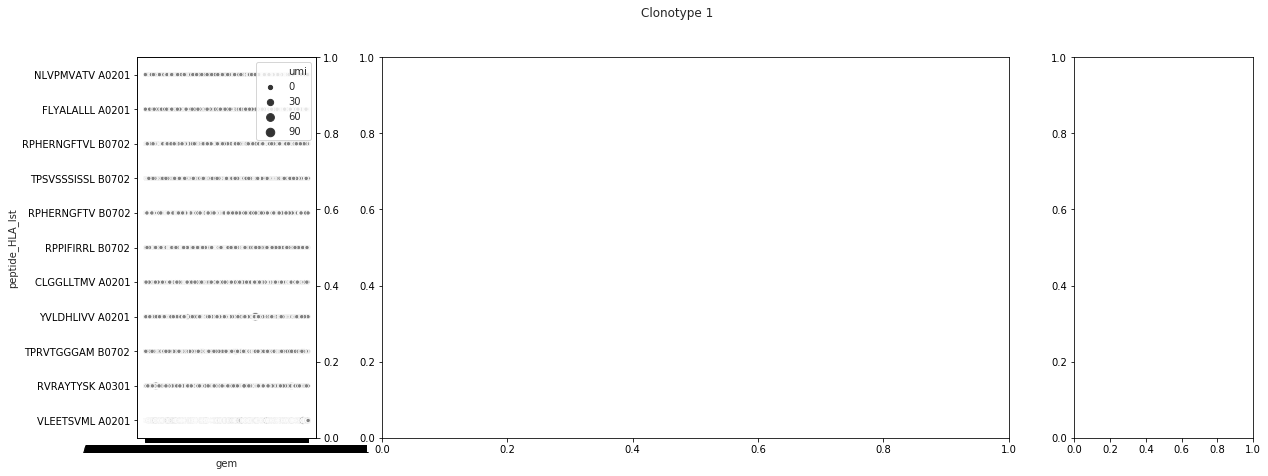

In [12]:
selected_clonotypes = df.groupby('ct').size()

for ct, grp in df.groupby('ct'): #selected_clonotypes.index
    if ct > 4:
        break
    print(ct)
    for variable, imp_var in zip(['sample_id','HLA_cd8','peptide_HLA'], ['ct_sample','ct_hla','ct_pep']):
        inst = Evaluate_Clonotype(df, ct, selected_clonotypes, variable=variable)
        inst.sum_umi()
        inst.calc_summary()
        #df.loc[instance.idx, 'umi_count_mhc_rel'] = instance.calc_relative_umi()
        inst.select_queries()
        inst.transform_data_for_plotting()
        inst.add_gem_count()
        inst.sort_data()
        inst.transform_to_concordance() # Only relevant for pMHC...
        inst.update_variable_analysis()

        if inst.test_dist():
            print(f'significant {variable}')
            df.loc[inst.idx, imp_var] = inst.get_imputed_query()
        
            inst.update_bins()
            
        if variable == 'peptide_HLA':
            inst.plot_advanced_figure('../lol_%s_%s.png')
            
    if ct in Evaluate_Clonotype.value_bin:
        inst.update_flag('significant')
        print(f'{ct} is credible')
    else:
        inst.update_flag('insignificant')
       
    #try:
    #if variable == 'peptide_HLA':
    #    inst.plot_advanced_figure('../lol_%s_%s.png') #../experiments/exp13/run2/plt/eval_clonotypes/significant/
    #except:
    #    print('not plottet')
    #finally:
    #    plt.close()
    #    plt.clf()
    
    ### PLOTTING ###
    if ct < 10:
        if len(grp) > 10:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,7))
            # pMHC
            order = Evaluate_Clonotype.ct_checks[variable].peptide_HLA_lst.unique() #inst.plt_df.peptide_HLA_lst.unique()#[::-1]
            ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':Evaluate_Clonotype.ct_checks['peptide_HLA'], 'order':order, 'ax':ax1}
            sns.boxplot(**ARGS, showfliers=False)
            sns.stripplot(**ARGS, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
            ax1.set_title("Peptide HLA")
            # Sample
            ARGS = {'x':"umi", 'y':"sample_id_lst", 'data':Evaluate_Clonotype.ct_checks['sample_id'], 'ax':ax3}
            sns.boxplot(**ARGS, orient='h', showfliers=False) #orient='h', added due to: TypeError: cannot perform reduce with flexible type
            sns.stripplot(**ARGS, orient='h', jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
            ax3.set_title('Sample ID')
            #sns.scatterplot(**ARGS, x='gem')
            #sns.scatterplot(data=smpl.plt_df, x="gem", y='sample_id', size='umi', ax=ax1, legend='brief') #hue='sample_id', 
            # Hashing
            ARGS = {'x':"umi", 'y':"HLA_pool_cd8", 'data':Evaluate_Clonotype.ct_checks['HLA_cd8'], 'ax':ax2}
            sns.boxplot(**ARGS, showfliers=False)
            sns.stripplot(**ARGS, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
            ax2.set_title('Sample HLA')
            
            fig.suptitle(f'Clonotype {inst.ct}')
            plt.show()
    else:
        print(ct)

# Possible fix:
# https://github.com/mwaskom/seaborn/commit/1a537c100dd58c4a22187b8f2a02ab53a88030a2
# Check the sns version on computerome.

In [18]:
Evaluate_Clonotype.ct_checks['sample_id']

sample_id_lst                 gem  umi  gem_count
60572             1  GAACGGACATTCCTCG-1    0       6058
11582             1  CACACTCGTCCGTGAC-1    0       1159
30542             1  GCTGCAGTCCTCAATT-1    0       3055
11592             1  CACACTCGTCTGGAGA-1    0       1160
64482             1  GGGCATCGTCCGCTGA-1    0       6449
...             ...                 ...  ...        ...
53983             9  CACAGGCCACCCATGG-1    4       5399
64483             9  GGGCATCGTCCGCTGA-1    0       6449
11593             9  CACACTCGTCTGGAGA-1    0       1160
64503             9  GGGTCTGAGAGCTATA-1    0       6451
22623             9  CTCGAAATCGTGACAT-1    0       2263

[71110 rows x 4 columns]

In [20]:
lol = Evaluate_Clonotype.ct_checks['sample_id'].copy()

In [29]:
lol.sample_id_lst = lol.sample_id_lst.astype(int).astype(str)

TypeError: cannot perform reduce with flexible type

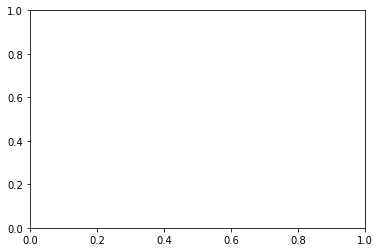

In [31]:
sns.boxplot(data=lol, x='umi',y='sample_id_lst', showfliers=False)
sns.stripplot(data=lol, x='umi',y='sample_id_lst', jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
plt.show()

In [31]:
class Evaluate_Clonotype():
    """
    An instance is a clonotype subset of the data.
    """
    value_bin = set() # clonotypes
    trash_bin = set() # peptide-HLAs
    
    def __init__(self, df, ct, selected_clonotypes, use_relative_umi=False):
        self.df = df[df.ct == ct]
        self.ct = int(ct)
        self.idx = self.df.index
        self.rel_umi = use_relative_umi
        self.fig_flg = 'None'
        #self.fig, (self.ax1, self.ax2) = plt.subplots(1,2,figsize=(10,3))
        
        # Initialize list of clonotypes
        self.sel_cts = selected_clonotypes
        self.sel_cts.index = self.sel_cts.index.astype(int)
        
        # Initialize matrix of pMHC count per GEM (not method (df is not self))
        self.all_peptide_hla = df.peptide_HLA_lst.explode().drop_duplicates() #.unique()
        self.mat = pd.DataFrame(index=self.all_peptide_hla, columns=df.gem.unique())
        
        # Count no. of GEMs within grp that are annotated with a specific pMHC (method?)
        self.gems_per_pep_ann = self.df.groupby('peptide_HLA').size() # annotated_gems
        self.gems_per_pep_all = pd.concat([self.gems_per_pep_ann,
                                           pd.Series(0, index=self.all_peptide_hla[~self.all_peptide_hla.isin(self.gems_per_pep_ann.index)])])
        
    def sum_umi(self):
        # Sum UMIs for each peptide across GEMs (multiple peptides per GEM)
        for idx, row in self.df.iterrows():
            if len(row.umi_count_lst_mhc) == len(row.peptide_HLA_lst):
                self.mat.loc[row.peptide_HLA_lst, row.gem] = row.umi_count_lst_mhc
            else:
                self.mat.loc[row.peptide_HLA_lst, row.gem] = [0] * len(row.peptide_HLA_lst)
        self.mat.fillna(0, inplace=True)
                
    def calc_summary(self):
        self.summary_df = self.mat.sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'s'})
        self.summary_df['avg'] = self.mat.mean(axis=1)
        self.summary_df['col'] = 'grey'
        self.summary_df['r'] = self.summary_df.s / self.summary_df.s.max() # Unnecessary
        
    def calc_relative_umi(self):
        if self.rel_umi:
            self.mat = self.mat / self.df.umi_count_mhc.quantile(0.9, interpolation='lower')
        return self.df.umi_count_mhc / self.df.umi_count_mhc.quantile(0.9, interpolation='lower')
    
    def select_peptides(self, n=11):
        self.selected_peptides = self.summary_df.head(n).index
        self.selected_mat = self.mat[self.mat.index.isin(self.selected_peptides)]

    def transform_data_for_plotting(self):
        """
        For each row have unique combination of pMHC and GEM.
        """
        self.plt_df = self.selected_mat.melt(ignore_index=False, var_name='gem', value_name='umi').dropna()
        self.plt_df.umi = self.plt_df.umi.astype(int)

    def add_gem_count(self):
        """
        Make a variable for iterating over GEMs (fx in a GIF)
        """
        dct = (self.plt_df.groupby('gem', sort=False).size()
               .to_frame().reset_index().reset_index().set_index('gem')
               .rename(columns={'index':'gem_count',0:'peptide_count'}))
        dct['gem_count'] = dct.gem_count + 1

        # Make a var for iterating over GEMs
        self.plt_df['gem_count'] = self.plt_df.gem.map(dct.gem_count)

    def sort_data(self):
        self.plt_df.reset_index(inplace=True)
        self.plt_df.peptide_HLA_lst = self.plt_df.peptide_HLA_lst.astype("category")
        self.plt_df['peptide_HLA_lst'] = self.plt_df.peptide_HLA_lst.cat.set_categories(self.selected_peptides) # instead of inplace
        self.plt_df.sort_values(by='peptide_HLA_lst', inplace=True)

    def add_scatter(self):
        for i, (name, subdf) in reversed(list(enumerate(self.plt_df.groupby('peptide_HLA_lst', sort=False)))): #reversed(list(grouped))
            self.plt_df.loc[subdf.index, 'y'] = np.random.normal(i, 0.1, subdf.shape[0])
    
    def transform_to_concordance(self):
        self.conc_df = (self.plt_df.sort_values(by=['gem','umi'])
                        .drop_duplicates(subset='gem', keep='last')
                        .groupby('peptide_HLA_lst').gem.count()
                        .to_frame())
        self.conc_df['clonotype'] = f'clonotype {self.ct}'
        self.conc_df.reset_index(inplace=True)
        self.conc_df['concordance'] = self.conc_df.gem / self.conc_df.gem.sum()
        self.conc_df.replace(0, np.nan, inplace=True)
         
    def plot_advanced_figure(self, figname):
        def get_legend_n_handle(l,h,key='gem'):
            leg = list()
            hdl = list()
            if key is None:
                keep = True
            else:
                keep = False
            for i,e in enumerate(l):
                if keep:
                    if int(float(e)) > 0:
                        leg.append(int(float(e)))
                        hdl.append(h[i])
                if e == key:
                    keep = True
            return hdl, leg
        
        fig = plt.figure(figsize=(20,7))
        fig.suptitle(f"Clonotype {self.ct}")

        gs = gridspec.GridSpec(1, 3, width_ratios=[2, 7, 2], wspace=0.2) #, left=0.05
        ax1 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1]) #ax2 = plt.subplot(gs[0,1])
        ax3 = fig.add_subplot(gs[2]) #ax3 = plt.subplot(gs[0, 2])

        ########################
        # Add multipletplot
        ###############################
        tx1 = ax1.twinx()
        sns.scatterplot(data=self.plt_df, x="gem", y='peptide_HLA_lst', size='umi', color="gray", ax=ax1, legend='brief')
        
        h,l = ax1.get_legend_handles_labels()
        h,l = get_legend_n_handle(l, h, key=None)
        ax1.legend(h, l, bbox_to_anchor=(-1, 0.5), loc=10, frameon=False, title='UMI')
        
        sns.scatterplot(data=self.plt_df, x="gem", y='peptide_HLA_lst', size='umi', color="gray", ax=tx1, legend=False)

        ########################
        # Add boxplot
        ###############################
        PROPS = {'boxprops':{'alpha':0.3}, #'facecolor':'none', 
                 'medianprops':{'alpha':0.3},
                 'whiskerprops':{'alpha':0.3},
                 'capprops':{'alpha':0.3}}
        EMPTY = {'boxprops':{'alpha':0}, #'facecolor':'none', 
                 'medianprops':{'alpha':0},
                 'whiskerprops':{'alpha':0},
                 'capprops':{'alpha':0}}
        ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':self.plt_df, 'showfliers':False}
        order = self.plt_df.peptide_HLA_lst.unique()#[::-1]

        tx2 = ax2.twinx() # hack to get matching ticks on the right
        sns.boxplot(**ARGS, **PROPS, order=order, ax=ax2)
        sns.stripplot(data=self.plt_df, x="umi", y='peptide_HLA_lst', ax=ax2, order=order, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
        #sns.boxplot(**ARGS, **PROPS, ax=ax2, order=order) #, order=order
        sns.boxplot(**ARGS, **EMPTY, order=order, ax=tx2)
        #sns.scatterplot(data=self.plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False, ax=ax2)

        # Add significance bar
        if self.test_dist():
            l = len(self.plt_df.peptide_HLA_lst.unique()) - 1
            y = [0,0,1,1] #[l, l, l-1, l-1] #
            x0 = self.plt_df.umi.max()
            x1 = x0 * 1.02
            x2 = x0 * 1.025
            x3 = x0 * 1.035

            ax2.plot([x1, x2, x2, x1], y, lw=0.7, c='0') #lw=1.5, 
            ax2.plot(x3, np.mean(y), marker="*", c='0')

        ######################################
        # Add concordance plot
        #########################################
        # Hack to get colorbar
        plot = ax3.scatter([np.nan]*len(order), order, c=[np.nan]*len(order), cmap='viridis_r', vmin=0, vmax=1) #[],[] #order[::-1]
        fig.colorbar(plot, ax=ax3)
        sns.scatterplot(data=self.conc_df, x='clonotype', y='peptide_HLA_lst',
                        size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r', ax=ax3) #g = 

        # Remove automatic sns legend for hue, keep only legend for size.
        h,l = ax3.get_legend_handles_labels()
        h,l = get_legend_n_handle(l, h, key='gem')
        ax3.legend(h, l, bbox_to_anchor=(1.5, 0.5), loc=6, frameon=False, title='GEM') #h[-4:], l[-4:]

        ######################################
        # Prettify
        #########################################

        ax1.set_title('Peptide MHC multiplets')
        ax2.set_title('UMI distribution per peptide MHC')
        ax3.set_title('Concordance')

        xmax = round(self.plt_df.umi.max(), -1)
        ax2.set_xticks(np.arange(0, xmax+10, 10))
        ax3.set_yticks([])

        ax1.set_xticklabels([])
        tx1.set_yticklabels([f'n= {n}' for n in self.plt_df.groupby('peptide_HLA_lst').size()])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])

        ax1.set_xlabel('GEM')
        ax1.set_ylabel('Peptide HLA', labelpad=20)
        tx1.set_ylabel('')
        ax2.set_xlabel('Peptide UMI')
        ax2.set_ylabel('')
        tx2.set_ylabel('')
        ax3.set_ylabel('')
        ax3.set_xlabel('')

        tx1.tick_params(axis='y', pad=20)

        ax2.spines['bottom'].set_bounds(0, xmax) # Hack to fix x-axis

        sns.despine(trim=True, right=True, ax=ax1)
        sns.despine(trim=True, right=False, ax=tx1)
        sns.despine(trim=True, right=False, ax=ax2)
        sns.despine(trim=True, right=False, ax=tx2)
        sns.despine(trim=True, left=True, ax=ax3) #offset={'left':-5,'right':-5}

        plt.savefig(figname %(self.fig_flg, self.ct), bbox_inches='tight')
        plt.show()
    
    
    def get_plotting_stats(self):
        self.summed_umis = self.summary_df.s.head(10)
        self.summed_gems = (self.mat > 0).sum(axis=1)
        
    def test_dist(self):
        """
        H0: No difference in UMI counts between the top two peptides
        H1: Top peptide has more UMI counts

        If H1, then we assume that the clonotype has a clear preference for that peptide.
        """
        # Select the peptides to test: the most abundant and the second most abundant (UMI wise)
        p1 = self.summary_df.index[0]
        p2 = self.summary_df.index[1]
        # Extract the UMI distribution for the two selected peptides.
        s1 = self.mat.T[p1].dropna().to_list()
        s2 = self.mat.T[p2].dropna().to_list()
        # If fewer than 5 observations for any of the peptides, then assume H0
        n = min(len(s1), len(s2))
        if n < 5:
            return False

        # Repeat experiment XX times to get more robust selection.
        p_list = list()
        for _ in range(50):
            l1 = sample(s1, n)
            l2 = sample(s2, n)

            t, p = stats.ttest_ind(l1, l2, equal_var=False, alternative='greater')

            p_list.append(p)

        if np.median(p_list) <= 0.05:
            return True
        return False

        ## Alternative to subsampling (not implemented)
        #_, pp = stats.ttest_ind(s1, s2, equal_var=False, alternative='greater')
        #
        #if pp <= 0.05:
        #    print('*** Significant with no sampling')
        #else:
        #    print('--- Insignificant even with no sampling')
    
    def get_imputed_peptide(self):
        return self.summary_df.index[0]
    
    def get_remaining_peptides(self):
        return self.summary_df.index[1:10]
    
    def update_bins(self):
        Evaluate_Clonotype.value_bin.update([self.ct])
        Evaluate_Clonotype.trash_bin.update(self.summary_df.index[1:10])
        
    def update_flag(self, flag):
        self.fig_flg = flag
        
    def plot_histogram(self):
        for peptide_HLA in self.summed_umis.index:
            data = self.mat.T[peptide_HLA].dropna()
            labl = '%s %s %d (%d) (%d)' %(peptide_HLA.split(' ')[1],
                                          peptide_HLA.split(' ')[0],
                                          self.summed_umis[peptide_HLA],
                                          self.summed_gems[peptide_HLA],
                                          self.gems_per_pep_all[peptide_HLA])
            # Plot
            self.ax2.hist(data, alpha=0.2, label=labl)
        # Save plotting colors
        color_idx = self.summary_df.columns.to_list().index('col')
        print(len(plt.rcParams['axes.prop_cycle'].by_key()['color']))
        print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
        self.summary_df.iloc[0:10, color_idx] = plt.rcParams['axes.prop_cycle'].by_key()['color']
        
    def plot_boxplot(self):
        boxes = list()
        self.meaned_umis = self.summary_df.sort_values(by='avg',ascending=False).head(10)
        for peptide_HLA in self.meaned_umis.index:
            boxes.append(self.mat.T[peptide_HLA].dropna().to_list())
        bp = self.ax1.boxplot(boxes, patch_artist=True) #, vert=False
        colors = self.meaned_umis.col #.to_list()

        # whiskers and caps have to be treated separately since there are two of each for each plot
        for item in ['whiskers', 'caps']:
            for sub_item, color in zip(zip(bp[item][::2], bp[item][1::2]), colors):
                plt.setp(sub_item, color=color, alpha=0.2)
        for item in ['fliers']:
            for sub_item, color in zip(bp[item], colors):
                plt.setp(sub_item, markeredgecolor=color, alpha=0.2)
        for item in ['boxes', 'medians']:
            for sub_item, color in zip(bp[item], colors):
                plt.setp(sub_item, color=color, alpha=0.2)

    def add_labels(self):
        # Boxplot
        self.ax1.set_title('Sorted by mean of BC UMI')
        self.ax1.set_xticklabels(self.meaned_umis.index, rotation=90)
        self.ax1.set_ylabel('UMI count')
        self.ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
        self.ax1.set_axisbelow(True) # Hide these grid behind plot objects
        
        plt.legend(bbox_to_anchor=(1.05, 0.5),
                   loc='center left',
                   title='HLA peptide UMI-sum (found in #GEMs) (ann. in #GEMs)')
        
        # Histogram
        self.ax2.set_xlabel('UMI count')
        self.ax2.set_ylabel('GEM count')
        self.ax2.set_title('Clonotype %d (%d GEMs)\n%s - %s\n%s - %s'
                           %(self.ct, self.sel_cts[self.ct],
                             self.df.genes_TRA.unique()[0], self.df.cdr3_TRA.unique()[0],
                             self.df.genes_TRB.unique()[0], self.df.cdr3_TRB.unique()[0]))
        
    #def plot_boxplot(self):
    #    ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':self.plt_df, 'showfliers':False}
    #    order = self.plt_df.peptide_HLA_lst.unique()#[::-1]
    #    sns.boxplot(**ARGS, order=order)
    #    plt.show()

    def save_figure(self, name):
        plt.savefig(name %(self.fig_flg, self.ct), bbox_inches='tight')

In [32]:
class Evaluate_Clonotype_by_HLA():
    """
    An instance is a clonotype subset of the data.
    """
    value_bin = set() # clonotypes
    trash_bin = set() # peptide-HLAs
    
    def __init__(self, df, ct, selected_clonotypes, use_relative_umi=False):
        self.df = df[df.ct == ct]
        self.ct = int(ct)
        self.idx = self.df.index
        self.rel_umi = use_relative_umi
        self.fig_flg = 'None'
        
        # Initialize list of clonotypes
        self.sel_cts = selected_clonotypes
        self.sel_cts.index = self.sel_cts.index.astype(int)
        
        # Initialize matrix of pMHC count per GEM (not method (df is not self))
        self.all_sample_hla = df.HLA_pool_cd8.explode().drop_duplicates() #.unique()
        self.mat = pd.DataFrame(index=self.all_sample_hla, columns=df.gem.unique())
        
        # Count no. of GEMs within grp that are annotated with a specific pMHC (method?)
        self.gems_per_pep_ann = self.df.explode(['HLA_cd8']).groupby('HLA_cd8').size() #self.df.groupby('HLA_cd8').size() # annotated_gems
        self.gems_per_pep_all = pd.concat([self.gems_per_pep_ann,
                                           pd.Series(0, index=self.all_sample_hla[~self.all_sample_hla.isin(self.gems_per_pep_ann.index)])])
        
    def sum_umi(self):
        # Sum UMIs for each peptide across GEMs (multiple peptides per GEM)
        for idx, row in self.df.iterrows():
            cd8_flat = [item for sublist in row.HLA_lst_cd8 for item in sublist]
            umi_long = [row.umi_count_lst_cd8[i] for i, sublist in enumerate(row.HLA_lst_cd8) for item in sublist]
            if len(row.umi_count_lst_cd8) == len(row.HLA_lst_cd8):
                self.mat.loc[cd8_flat, row.gem] = umi_long
            else:
                self.mat.loc[cd8_flat, row.gem] = [0] * len(cd8_flat) #len(row.HLA_lst_cd8)
        self.mat.fillna(0, inplace=True)
                
    def calc_summary(self):
        self.summary_df = self.mat.sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'s'})
        self.summary_df['avg'] = self.mat.mean(axis=1)
        self.summary_df['col'] = 'grey'
        self.summary_df['r'] = self.summary_df.s / self.summary_df.s.max() # Unnecessary
        
    def select_peptides(self, n=11):
        self.selected_peptides = self.summary_df.head(n).index
        self.selected_mat = self.mat[self.mat.index.isin(self.selected_peptides)]

    def transform_data_for_plotting(self):
        """
        For each row have unique combination of pMHC and GEM.
        """
        self.plt_df = self.selected_mat.melt(ignore_index=False, var_name='gem', value_name='umi').dropna()
        self.plt_df.umi = self.plt_df.umi.astype(int)

    def add_gem_count(self):
        """
        Make a variable for iterating over GEMs (fx in a GIF)
        """
        dct = (self.plt_df.groupby('gem', sort=False).size()
               .to_frame().reset_index().reset_index().set_index('gem')
               .rename(columns={'index':'gem_count',0:'peptide_count'}))
        dct['gem_count'] = dct.gem_count + 1

        # Make a var for iterating over GEMs
        self.plt_df['gem_count'] = self.plt_df.gem.map(dct.gem_count)
        
    def sort_data(self):
        self.plt_df.reset_index(inplace=True)
        self.plt_df.HLA_pool_cd8 = self.plt_df.HLA_pool_cd8.astype("category")
        self.plt_df.HLA_pool_cd8 = self.plt_df.HLA_pool_cd8.cat.set_categories(self.selected_peptides) # instead of inplace
        self.plt_df.sort_values(by='HLA_pool_cd8', inplace=True)
        
    def test_dist(self):
        """
        H0: No difference in UMI counts between the top two peptides
        H1: Top peptide has more UMI counts

        If H1, then we assume that the clonotype has a clear preference for that peptide.
        """
        # Select the peptides to test: the most abundant and the second most abundant (UMI wise)
        p1 = self.summary_df.index[0]
        p2 = self.summary_df.index[1]
        # Extract the UMI distribution for the two selected peptides.
        s1 = self.mat.T[p1].dropna().to_list()
        s2 = self.mat.T[p2].dropna().to_list()
        # If fewer than 5 observations for any of the peptides, then assume H0
        n = min(len(s1), len(s2))
        if n < 5:
            return False

        # Repeat experiment XX times to get more robust selection.
        p_list = list()
        for _ in range(50):
            l1 = sample(s1, n)
            l2 = sample(s2, n)

            t, p = stats.ttest_ind(l1, l2, equal_var=False, alternative='greater')

            p_list.append(p)

        if np.median(p_list) <= 0.05:
            return True
        return False
    
    def get_imputed_peptide(self):
        return self.summary_df.index[0]
    
    def get_remaining_peptides(self):
        return self.summary_df.index[1:10]
    
    def update_bins(self):
        Evaluate_Clonotype_by_HLA.value_bin.update([self.ct])
        Evaluate_Clonotype_by_HLA.trash_bin.update(self.summary_df.index[1:10])
        
    def update_flag(self, flag):
        self.fig_flg = flag

In [63]:
class Evaluate_Clonotype_by_sample():
    """
    An instance is a clonotype subset of the data.
    """
    value_bin = set() # clonotypes
    trash_bin = set() # peptide-HLAs
    
    def __init__(self, df, ct, selected_clonotypes, use_relative_umi=False):
        self.df = df[df.ct == ct]
        self.ct = int(ct)
        self.idx = self.df.index
        self.rel_umi = use_relative_umi
        self.fig_flg = 'None'
        
        # Initialize list of clonotypes
        self.sel_cts = selected_clonotypes
        self.sel_cts.index = self.sel_cts.index.astype(int)
        
        # Initialize matrix of pMHC count per GEM (not method (df is not self))
        self.all_sample_hla = df.sample_id_lst.explode().drop_duplicates() #sample_id ?
        self.mat = pd.DataFrame(index=self.all_sample_hla, columns=df.gem.unique())
        
        # Count no. of GEMs within grp that are annotated with a specific pMHC (method?)
        self.gems_per_pep_ann = self.df.groupby('sample_id').size() # annotated_gems
        self.gems_per_pep_all = pd.concat([self.gems_per_pep_ann,
                                           pd.Series(0, index=self.all_sample_hla[~self.all_sample_hla.isin(self.gems_per_pep_ann.index)])])
        
    def sum_umi(self):
        # Sum UMIs for each peptide across GEMs (multiple peptides per GEM)
        for idx, row in self.df.iterrows():
            #cd8_flat = [item for sublist in row.HLA_lst_cd8 for item in sublist]
            #umi_long = [row.umi_count_lst_cd8[i] for i, sublist in enumerate(row.HLA_lst_cd8) for item in sublist]
            if len(row.umi_count_lst_cd8) == len(row.sample_id_lst):
                self.mat.loc[row.sample_id_lst, row.gem] = row.umi_count_lst_cd8
            else:
                self.mat.loc[row.sample_id_lst, row.gem] = [0] * len(row.sample_id_lst)
        self.mat.fillna(0, inplace=True)
                
    def calc_summary(self):
        self.summary_df = self.mat.sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'s'})
        self.summary_df['avg'] = self.mat.mean(axis=1)
        self.summary_df['col'] = 'grey'
        self.summary_df['r'] = self.summary_df.s / self.summary_df.s.max() # Unnecessary
        
    def select_peptides(self, n=11):
        self.selected_peptides = self.summary_df.dropna().head(n).index #.astype(str)
        self.selected_mat = self.mat[self.mat.index.isin(self.selected_peptides)]

    def transform_data_for_plotting(self):
        """
        For each row have unique combination of pMHC and GEM.
        """
        self.plt_df = self.selected_mat.melt(ignore_index=False, var_name='gem', value_name='umi').dropna()
        self.plt_df.umi = self.plt_df.umi.astype(int)

    def add_gem_count(self):
        """
        Make a variable for iterating over GEMs (fx in a GIF)
        """
        dct = (self.plt_df.groupby('gem', sort=False).size()
               .to_frame().reset_index().reset_index().set_index('gem')
               .rename(columns={'index':'gem_count',0:'peptide_count'}))
        dct['gem_count'] = dct.gem_count + 1

        # Make a var for iterating over GEMs
        self.plt_df['gem_count'] = self.plt_df.gem.map(dct.gem_count)
        
    def sort_data(self):
        self.plt_df.reset_index(inplace=True)
        #self.plt_df.sample_id = self.plt_df.sample_id.astype(str).astype("category")
        #self.plt_df.sample_id = self.plt_df.sample_id.cat.set_categories(self.selected_peptides) # instead of inplace
        self.plt_df.sort_values(by='sample_id_lst', inplace=True)
        self.plt_df.sample_id_lst = self.plt_df.sample_id_lst.fillna('').astype(str) #astype(int).
        
    def test_dist(self):
        """
        H0: No difference in UMI counts between the top two peptides
        H1: Top peptide has more UMI counts

        If H1, then we assume that the clonotype has a clear preference for that peptide.
        """
        # Select the peptides to test: the most abundant and the second most abundant (UMI wise)
        p1 = self.summary_df.index[0]
        p2 = self.summary_df.index[1]
        # Extract the UMI distribution for the two selected peptides.
        s1 = self.mat.T[p1].dropna().to_list()
        s2 = self.mat.T[p2].dropna().to_list()
        # If fewer than 5 observations for any of the peptides, then assume H0
        n = min(len(s1), len(s2))
        if n < 5:
            return False

        # Repeat experiment XX times to get more robust selection.
        p_list = list()
        for _ in range(50):
            l1 = sample(s1, n)
            l2 = sample(s2, n)

            t, p = stats.ttest_ind(l1, l2, equal_var=False, alternative='greater')

            p_list.append(p)

        if np.median(p_list) <= 0.05:
            return True
        return False
    
    def get_imputed_peptide(self):
        return self.summary_df.index[0]
    
    def get_remaining_peptides(self):
        return self.summary_df.index[1:10]
    
    def update_bins(self):
        Evaluate_Clonotype_by_HLA.value_bin.update([self.ct])
        Evaluate_Clonotype_by_HLA.trash_bin.update(self.summary_df.index[1:10])
        
    def update_flag(self, flag):
        self.fig_flg = flag

significant sample
significant pMHC


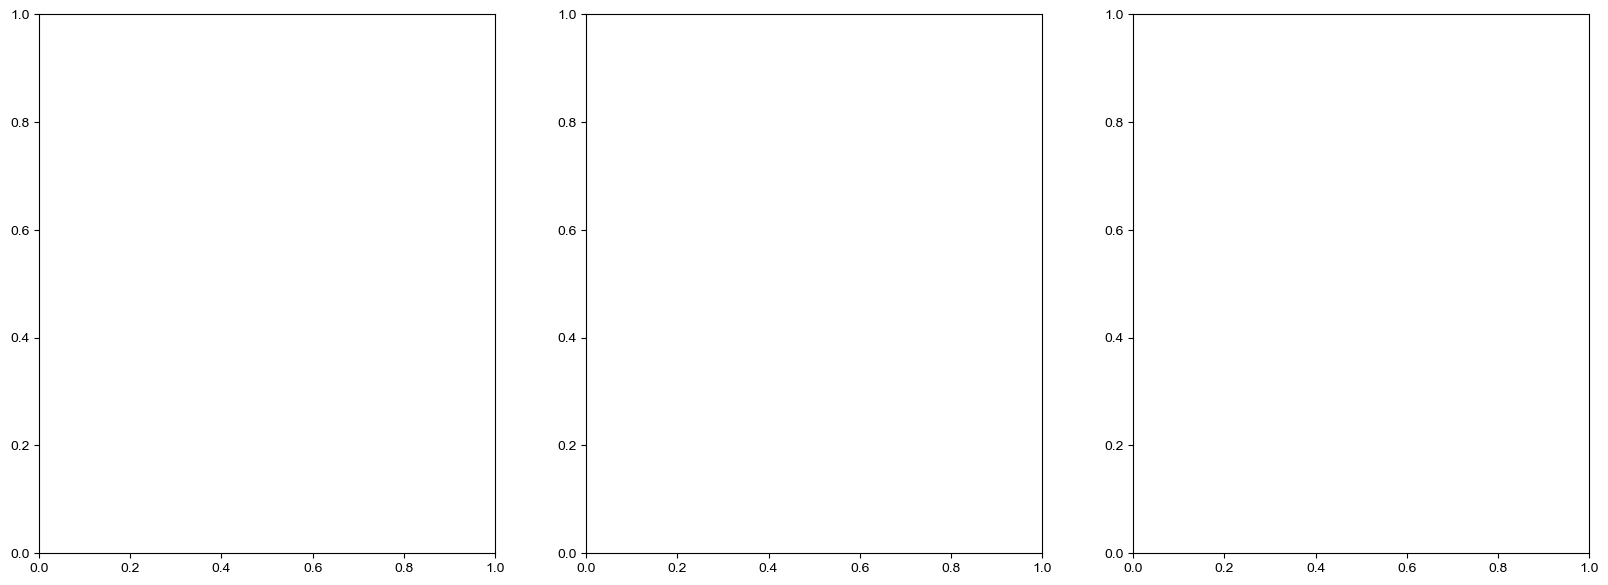

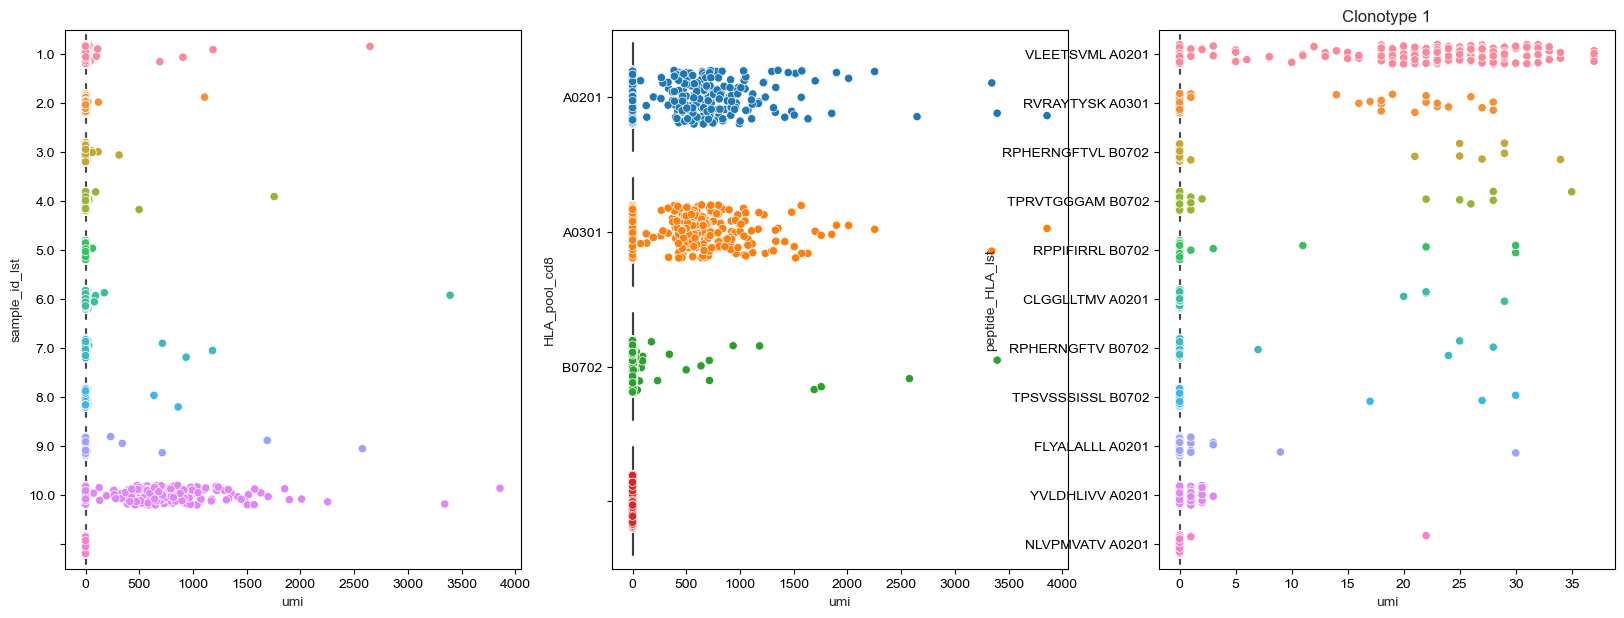

significant pMHC


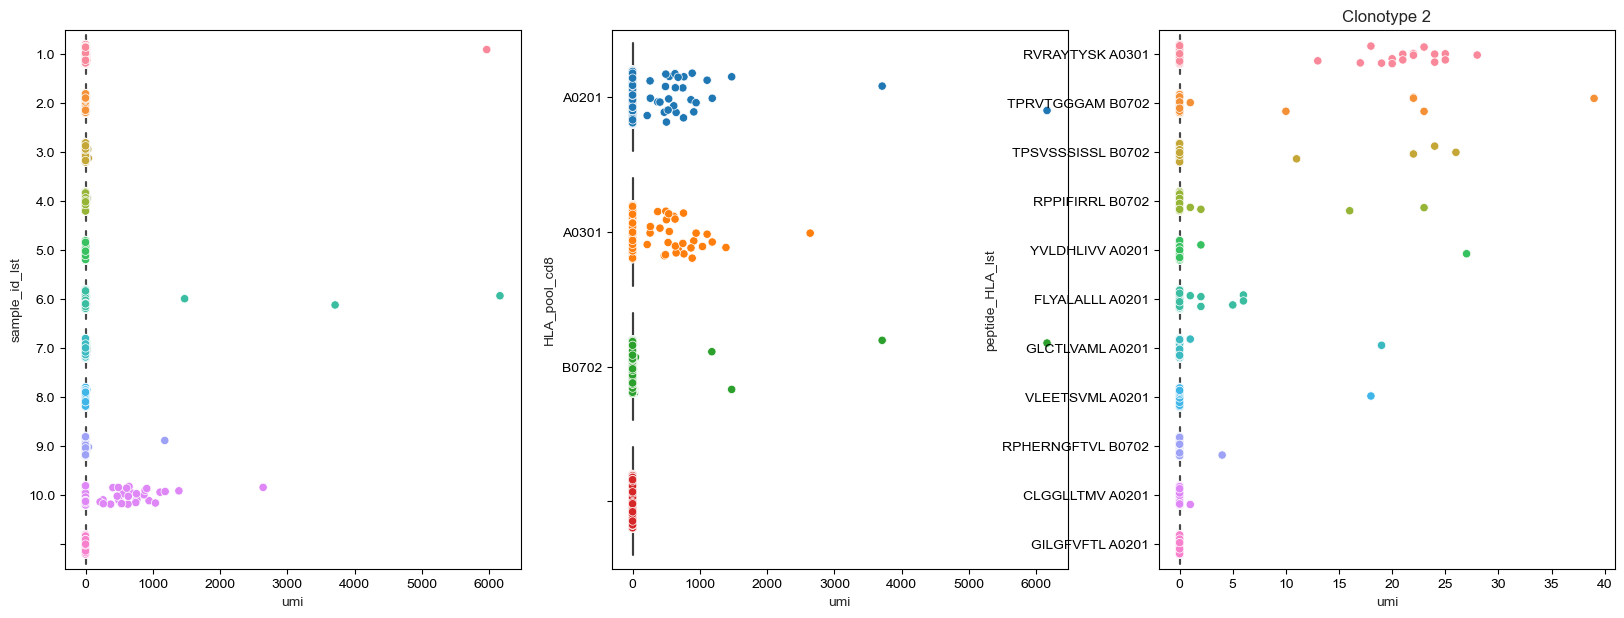

significant sample
significant HLA
significant pMHC


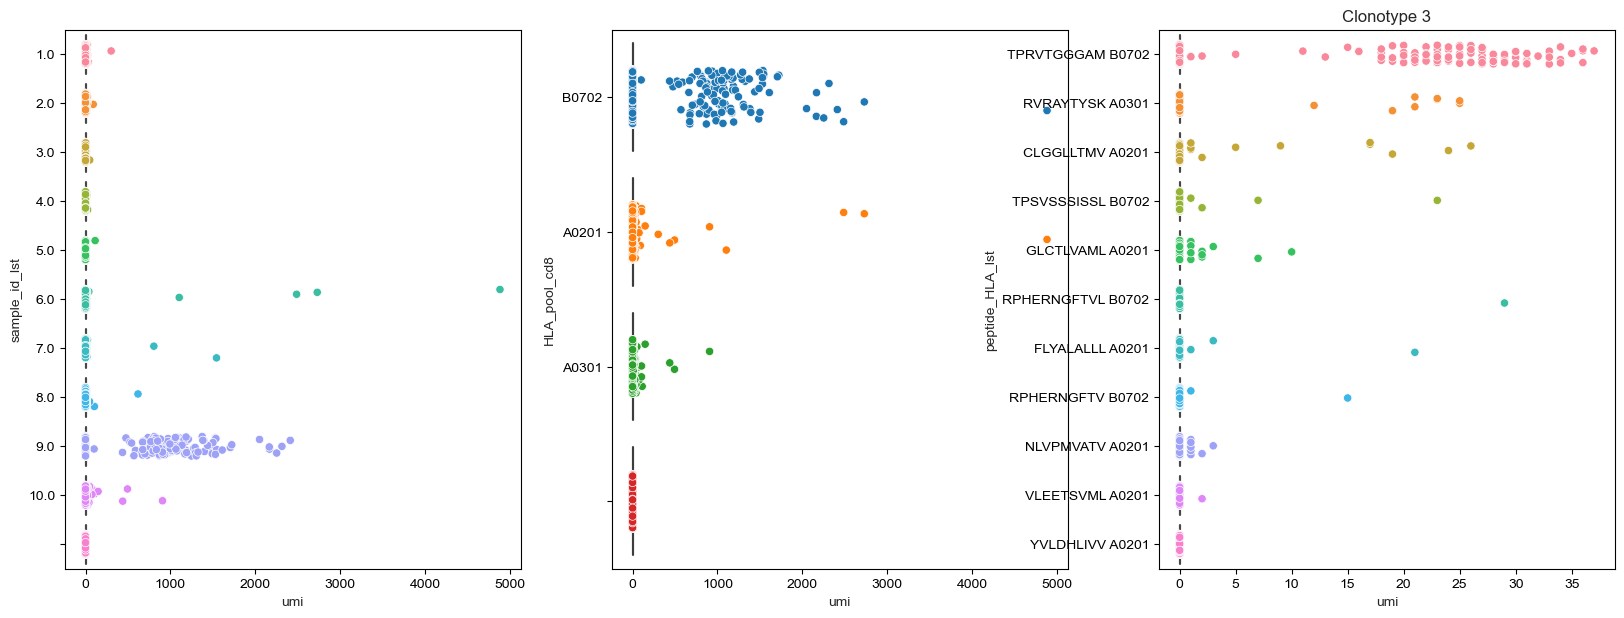

significant sample
significant HLA
significant pMHC


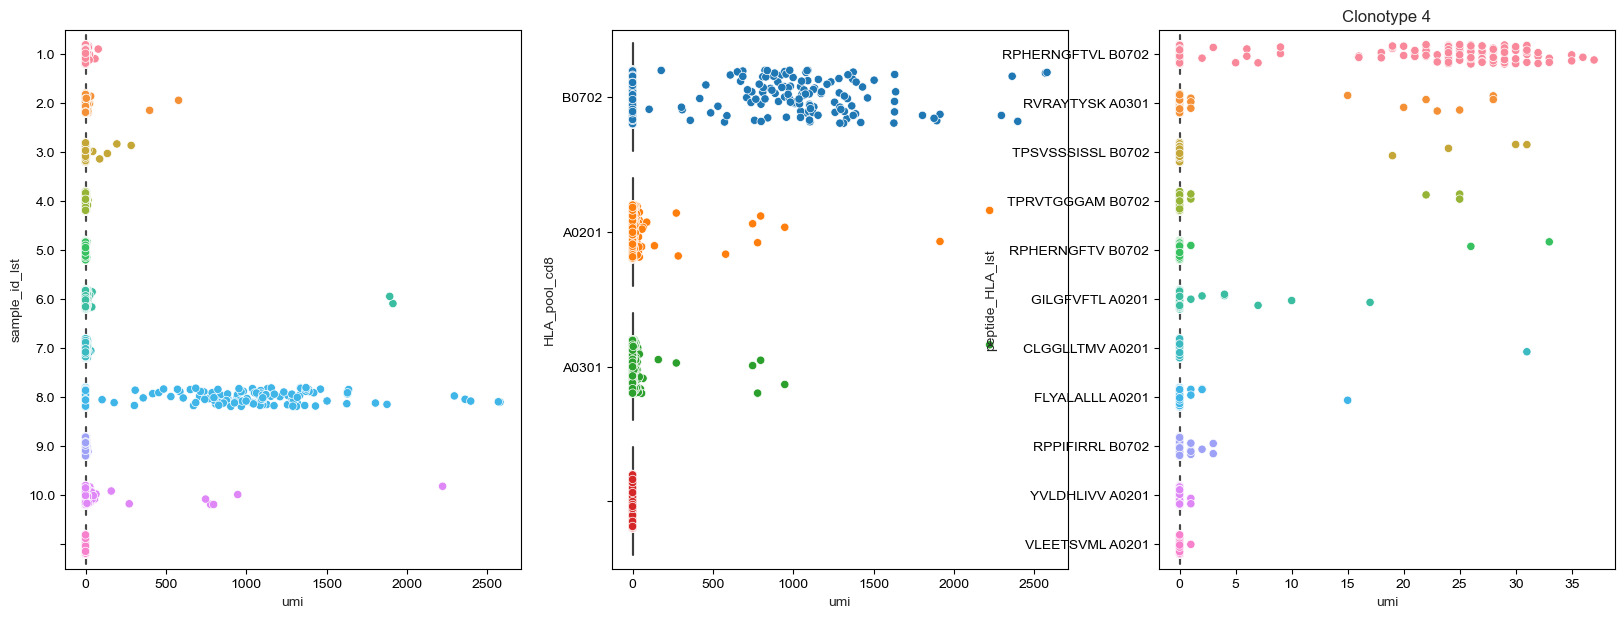

significant sample


KeyboardInterrupt: 

In [65]:
selected_clonotypes = df.groupby('ct').size()

for ct, grp in df.groupby('ct'): #selected_clonotypes.index
    ### SAMPLE ID ###
    smpl = Evaluate_Clonotype_by_sample(df, ct, selected_clonotypes, use_relative_umi=False)
    smpl.sum_umi()
    smpl.calc_summary()
    smpl.select_peptides()
    smpl.transform_data_for_plotting()
    smpl.add_gem_count()
    smpl.sort_data()
    
    if smpl.test_dist():
        print('significant sample')
        df.loc[smpl.idx, 'ct_sample'] = smpl.get_imputed_peptide()

        smpl.update_bins()
        smpl.update_flag('significant')
    else:
        smpl.update_flag('insignificant')
    
    ### HASHING ###
    tester = Evaluate_Clonotype_by_HLA(df, ct, selected_clonotypes, use_relative_umi=False)
    tester.sum_umi()
    tester.calc_summary()
    tester.select_peptides()
    tester.transform_data_for_plotting()
    tester.add_gem_count()
    tester.sort_data()
    
    if tester.test_dist():
        print('significant HLA')
        df.loc[tester.idx, 'ct_hla'] = tester.get_imputed_peptide()

        tester.update_bins()
        tester.update_flag('significant')
    else:
        tester.update_flag('insignificant')
    
    ### PMHC ###
    instance = Evaluate_Clonotype(df, ct, selected_clonotypes, use_relative_umi=False)
    instance.sum_umi()
    instance.calc_summary()
    
    df.loc[instance.idx, 'umi_count_mhc_rel'] = instance.calc_relative_umi()
    
    if instance.test_dist():
        print('significant pMHC')
        df.loc[instance.idx, 'ct_pep'] = instance.get_imputed_peptide()

        instance.update_bins()
        instance.update_flag('significant')
    else:
        instance.update_flag('insignificant')
    
    instance.select_peptides()
    instance.transform_data_for_plotting()
    instance.add_gem_count()
    instance.sort_data()
    #instance.add_scatter()
    instance.transform_to_concordance()
    #try:
    #    instance.plot_advanced_figure('../lol_%s_%s.png') #../experiments/exp13/run2/plt/eval_clonotypes/significant/
    #except:
    #    print('not plottet')
    #finally:
    #    plt.close()
    #    plt.clf()
    
    ### PLOTTING ###
    if ct < 200:
        if len(grp) > 10:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,7))
            # Sample
            ARGS = {'x':"umi", 'y':"sample_id_lst", 'data':smpl.plt_df, 'ax':ax1}
            sns.boxplot(**ARGS, showfliers=False)
            sns.stripplot(**ARGS, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
            plt.title(f'Clonotype {smpl.ct}')
            #sns.scatterplot(**ARGS, x='gem')
            #sns.scatterplot(data=smpl.plt_df, x="gem", y='sample_id', size='umi', ax=ax1, legend='brief') #hue='sample_id', 
            # Hashing
            ARGS = {'x':"umi", 'y':"HLA_pool_cd8", 'data':tester.plt_df, 'ax':ax2}
            sns.boxplot(**ARGS, showfliers=False)
            sns.stripplot(**ARGS, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
            plt.title(f'Clonotype {tester.ct}')
            # pMHC
            order = instance.plt_df.peptide_HLA_lst.unique()#[::-1]
            ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':instance.plt_df, 'order':order, 'ax':ax3}
            sns.boxplot(**ARGS, showfliers=False)
            sns.stripplot(**ARGS, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
            plt.title(f'Clonotype {instance.ct}')

            plt.show()
    else:
        print(ct)

# Possible fix:
# https://github.com/mwaskom/seaborn/commit/1a537c100dd58c4a22187b8f2a02ab53a88030a2
# Check the sns version on computerome.

In [33]:
sample_hla_dct = {1:['A0201'],
                  2:['A0201'],
                  3:['A0201'],
                  4:['A0301', 'B0702'],
                  5:['A0301', 'B0702'],
                  6:['A0201', 'B0702'],
                  7:['B0702'],
                  8:['B0702'],
                  9:['B0702'],
                  10:['A0201','A0301']}

In [34]:
df['sample_hla'] = df.ct_sample.map(sample_hla_dct)
#df.sample_hla.fillna('', inplace=True)

In [35]:
def determine_pep_match(row):
    def notnan(var):
        return var == var
    
    if notnan(row.peptide_HLA) & notnan(row.ct_pep):
        return row.peptide_HLA == row.ct_pep
    else:
        return np.nan

In [36]:
def determine_hla_match_by_HLA_conc(row):
    def notnan(var):
        return var == var
    
    if notnan(row.HLA_mhc) & (notnan(row.ct_hla) | notnan(row.sample_hla)):
        return (row.HLA_mhc == row.ct_hla) | (row.HLA_mhc in row.sample_hla)
    else:
        return np.nan
    #if notnan(row.HLA_mhc) & notnan(row.ct_hla) & notnan(row.sample_hla):
    #    return (row.HLA_mhc == row.ct_hla) | (row.HLA_mhc in row.sample_hla)
    

In [37]:
df['pep_match'] = df.apply(lambda row: determine_pep_match(row), axis=1) #df.peptide_HLA == df.ct_pep

In [38]:
df['hla_match'] = df.apply(lambda row: determine_hla_match_by_HLA_conc(row), axis=1)
#df['hla_match'] = df.apply(lambda row: (row.HLA_mhc == row.ct_hla) | (row.HLA_mhc in row.sample_hla), axis=1)

In [39]:
def determine_ct_match_by_HLA_conc(row):
    def notnan(var):
        return var == var
    
    pep_hla = row.ct_pep.split(' ')[1] if notnan(row.ct_pep) else np.nan
    lst_hla = row.ct_hla
    smp_hla = row.sample_hla
    if notnan(pep_hla) & (notnan(lst_hla) | notnan(smp_hla)):
        return (pep_hla == lst_hla) | (pep_hla in smp_hla)
    else:
        return np.nan

In [40]:
def determine_label(row):
    def notnan(var):
        return var == var
    
    if any((notnan(row.pep_match), notnan(row.hla_match), notnan(row.ct_match))):
        return (row.pep_match != False) & (row.hla_match != False) & (row.ct_match != False)
    else:
        return np.nan

In [41]:
#df['ct_match'] = df.apply(lambda row: (row.ct_pep.split(' ')[1] == row.ct_hla) | (row.ct_pep.split(' ')[1] in row.sample_hla) if row.ct_pep == row.ct_pep else np.nan, axis=1)

In [42]:
df['ct_match'] = df.apply(lambda row: determine_ct_match_by_HLA_conc(row), axis=1)

In [43]:
df['valid_ct'] = df.ct.isin(Evaluate_Clonotype.value_bin) & (df.ct_match != False)

In [44]:
df['train_label'] = df.apply(lambda row: determine_label(row), axis=1) #(df.pep_match != False) & (df.hla_match != False) & (df.ct_match != False)

In [244]:
df[df.ct.isin(Evaluate_Clonotype.value_bin)].groupby('ct').size()

ct
1.0       204
2.0        30
3.0       120
4.0       126
5.0         7
         ... 
5773.0      3
5795.0      5
5806.0      3
5832.0      5
6312.0     10
Length: 71, dtype: int64

In [45]:
valid_ct = df[df.valid_ct == True].ct.astype(int).unique()
valid_ct

array([   4,  115,   25,   16,   22,   50,   18,    3,    1,   68,    8,
         28,   34,   75,    6,  122,   17,   69,    5,   19,  106,   12,
         26,   58,   65,    2,  145,   40,   89, 5079,   35,  136,  272,
       5673,   13,   23,   24,   32,   11,   47,   29,  138,   67,   85,
         91,  119,   90, 3280,   10,   14,   51,  130,  242,   70,  243,
        189,   52, 1054,   82,  225,   49,  100,   81,  135,  103,  107,
        194,  170,  129,  110,  277,  121,  278,   93,   88,  143,  134,
         46,  190,   71,  210,  183,  125,  274,  211,   38,  177,  950,
        163,  270,  169,  160,  228,  148,  114,  216,  395,  192,  204,
        140,  258,   27,   54,  255,  162,   78,  181,   31,  159,   45,
        149,   59,   94,  828,   56,  109, 5976,  101,   96,   73,  197,
       5239, 5609, 5190, 4336, 1629, 2471, 1473, 5301, 1627, 3301, 2302,
       5587, 1435, 5199, 5827, 4232, 3257,   72, 5218, 4347, 5919, 3462,
       4421, 5211, 1525, 2479, 3316, 5167, 5924,  9

In [46]:
any(df[df.ct.isin(valid_ct)].ct_match == False)

False

In [47]:
df[df.ct.isin(valid_ct) & (df.ct_match == False)]

Empty DataFrame
Columns: [gem, clonotype, num_clonotype, ct, genes_TRA, genes_TRB, genes_lst_TRA, genes_lst_TRB, length_TRA, cdr1_TRA, cdr2_TRA, cdr3_TRA, umi_count_TRA, umi_count_lst_TRA, delta_umi_TRA, cdr3_lst_TRA, chain_count_TRA, single_TRA, length_TRB, cdr1_TRB, cdr2_TRB, cdr3_TRB, umi_count_TRB, umi_count_lst_TRB, delta_umi_TRB, cdr3_lst_TRB, chain_count_TRB, single_TRB, single_chain_only, umi_count_tcr, cdr3_comb, v_gene_TRA, j_gene_TRA, v_gene_TRB, j_gene_TRB, tcr_category, no_filtration, exclude_single-chain_TCRs, exclude_ambiguous_and_single-chain_TCRs, exclude_ambiguous_TCRs, label, umi_count_mhc, umi_count_lst_mhc, delta_umi_mhc, single_barcode_mhc, multiplets_mhc, umi_count_cd8, umi_count_lst_cd8, delta_umi_cd8, single_barcode_cd8, multiplets_cd8, detected_response, peptide_assayed, sample_id, sample_id_lst, HLA_pool_cd8, HLA_lst_cd8, HLA_cd8, HLA_match, HLA_mhc, HLA_lst_mhc, likely_HLA_mhc, peptide, peptide_lst, peptide_HLA, peptide_HLA_lst, epitope, epitope_lst, rank, marker, marker_lst, umi_count_lst_mrk, delta_umi_mrk, single_barcode_mrk, multiplets_mrk, umi_count_mhc_rel, gems_per_specificity, gems_per_clonotype, binding_concordance, cdr3_TRA_substr, cdr3_TRB_substr, VDJdb_pep, VDJdb_check, ct_sample, ct_pep, ct_hla, sample_hla, pep_match, hla_match, ct_match, valid_ct, train_label]
Index: []

[0 rows x 92 columns]

In [48]:
df.to_csv('valid_df.csv', index=False)

In [60]:
df.loc[df.ct.isin(valid_ct),
       ['peptide_HLA','ct_sample','ct_pep','ct_hla','sample_hla','pep_match','hla_match','ct_match','credible_ct','train_label']].head(60)

peptide_HLA  ct_sample             ct_pep ct_hla      sample_hla  \
2    RPHERNGFTVL B0702        8.0  RPHERNGFTVL B0702  B0702         [B0702]   
3      CLGGLLTMV A0201        1.0    CLGGLLTMV A0201    NaN         [A0201]   
4     TPRVTGGGAM B0702        7.0   TPRVTGGGAM B0702  B0702         [B0702]   
9      VLEETSVML A0201        9.0                NaN    NaN         [B0702]   
10     RVRAYTYSK A0301        4.0    RVRAYTYSK A0301    NaN  [A0301, B0702]   
14     VLEETSVML A0201       10.0    RVRAYTYSK A0301    NaN  [A0201, A0301]   
16     YVLDHLIVV A0201       10.0    YVLDHLIVV A0201    NaN  [A0201, A0301]   
18    TPRVTGGGAM B0702        9.0   TPRVTGGGAM B0702  B0702         [B0702]   
20     VLEETSVML A0201       10.0    VLEETSVML A0201    NaN  [A0201, A0301]   
26     VLEETSVML A0201       10.0    VLEETSVML A0201    NaN  [A0201, A0301]   
27     VLEETSVML A0201       10.0    VLEETSVML A0201    NaN  [A0201, A0301]   
28    TPRVTGGGAM B0702        7.0   TPRVTGGGAM B0702  B0702         [B0702]   
33    TPRVTGGGAM B0702       10.0                NaN    NaN  [A0201, A0301]   
35     CLGGLLTMV A0201       10.0    CLGGLLTMV A0201    NaN  [A0201, A0301]   
36     YVLDHLIVV A0201       10.0    YVLDHLIVV A0201    NaN  [A0201, A0301]   
43     RVRAYTYSK A0301        3.0    VLEETSVML A0201    NaN         [A0201]   
45     VLEETSVML A0201       10.0    VLEETSVML A0201    NaN  [A0201, A0301]   
47   TPSVSSSISSL B0702        2.0                NaN    NaN         [A0201]   
49     RVRAYTYSK A0301       10.0    RVRAYTYSK A0301    NaN  [A0201, A0301]   
50     RVRAYTYSK A0301        9.0                NaN    NaN         [B0702]   
51    TPRVTGGGAM B0702        NaN   TPRVTGGGAM B0702    NaN             NaN   
52   RPHERNGFTVL B0702        8.0  RPHERNGFTVL B0702  B0702         [B0702]   
53     RPPIFIRRL B0702        4.0    RPPIFIRRL B0702    NaN  [A0301, B0702]   
54     RVRAYTYSK A0301       10.0    RVRAYTYSK A0301    NaN  [A0201, A0301]   
59   RPHERNGFTVL B0702        8.0  RPHERNGFTVL B0702  B0702         [B0702]   
62    TPRVTGGGAM B0702        8.0   TPRVTGGGAM B0702    NaN         [B0702]   
64     VLEETSVML A0201       10.0    VLEETSVML A0201    NaN  [A0201, A0301]   
69     VLEETSVML A0201        3.0    VLEETSVML A0201  A0201         [A0201]   
75   RPHERNGFTVL B0702        7.0  RPHERNGFTVL B0702  B0702         [B0702]   
76     VLEETSVML A0201       10.0    VLEETSVML A0201    NaN  [A0201, A0301]   
80     RVRAYTYSK A0301       10.0                NaN    NaN  [A0201, A0301]   
81     RPPIFIRRL B0702        4.0    RPPIFIRRL B0702    NaN  [A0301, B0702]   
82     RVRAYTYSK A0301        5.0    RVRAYTYSK A0301    NaN  [A0301, B0702]   
84     RVRAYTYSK A0301       10.0    RVRAYTYSK A0301    NaN  [A0201, A0301]   
85    TPRVTGGGAM B0702        9.0   TPRVTGGGAM B0702  B0702         [B0702]   
88     RVRAYTYSK A0301        4.0    RVRAYTYSK A0301    NaN  [A0301, B0702]   
89    TPRVTGGGAM B0702        8.0   TPRVTGGGAM B0702  B0702         [B0702]   
90     RVRAYTYSK A0301        4.0    RVRAYTYSK A0301    NaN  [A0301, B0702]   
94    TPRVTGGGAM B0702        9.0   TPRVTGGGAM B0702  B0702         [B0702]   
95     RPPIFIRRL B0702        4.0    RPPIFIRRL B0702    NaN  [A0301, B0702]   
96     YVLDHLIVV A0201        6.0                NaN    NaN  [A0201, B0702]   
97     VLEETSVML A0201        3.0    VLEETSVML A0201    NaN         [A0201]   
98   RPHERNGFTVL B0702        8.0  RPHERNGFTVL B0702  B0702         [B0702]   
99     RVRAYTYSK A0301       10.0    RVRAYTYSK A0301    NaN  [A0201, A0301]   
103    YVLDHLIVV A0201       10.0    YVLDHLIVV A0201    NaN  [A0201, A0301]   
105    VLEETSVML A0201        3.0                NaN    NaN         [A0201]   
109   TPRVTGGGAM B0702        9.0   TPRVTGGGAM B0702  B0702         [B0702]   
110   TPRVTGGGAM B0702        7.0   TPRVTGGGAM B0702  B0702         [B0702]   
113    CLGGLLTMV A0201       10.0    CLGGLLTMV A0201    NaN  [A0201, A0301]   
116    VLEETSVML A0201       10.0    VLEETSVML A0201    NaN  

In [61]:
df.train_label.value_counts()

True     2495
False     746
Name: train_label, dtype: int64

In [62]:
df.groupby(['ct','credible_ct','ct_match']).size().head(60)

ct     credible_ct  ct_match
1.0    True         True        349
2.0    True         True        165
3.0    True         True        255
4.0    True         True        199
5.0    True         True        131
6.0    True         True         53
8.0    True         True        124
9.0    False        False        23
10.0   True         True         77
11.0   True         True         13
12.0   True         True         87
13.0   True         True         67
14.0   True         True         24
17.0   True         True         58
18.0   True         True         56
19.0   True         True         66
20.0   False        False        26
21.0   False        False        21
22.0   True         True         36
23.0   True         True         35
24.0   True         True         44
25.0   True         True         35
26.0   True         True         13
28.0   True         True         44
29.0   True         True         26
30.0   False        False         9
32.0   True         True         28

In [22]:
df[df.credible_ct == True].groupby('ct').ct_match.size()

ct
1.0       349
2.0       165
3.0       255
4.0       199
5.0       131
         ... 
5827.0      4
5919.0      5
5924.0      3
5976.0      4
6059.0      3
Name: ct_match, Length: 157, dtype: int64

In [35]:
df['TP'] = (df.pep_match == True) & (df.hla_match == True) & (df.ct_match == True)
df['TN'] = (df.pep_match == False) & (df.hla_match == False)
df['FP'] = (df.pep_match == True) & (df.hla_match == False)
df['FN'] = (df.pep_match == False) & (df.hla_match == True)

In [36]:
print('TP:', df.TP.sum())
print('TN:', df.TN.sum())
print('FP:', df.FP.sum())
print('FN:', df.FN.sum())

TP: 779
TN: 1148
FP: 117
FN: 139


In [101]:
df[(df.pep_match == True) & (df.hla_match == True) & (df.ct_match == True)]

gem      clonotype  num_clonotype      ct  \
3     AAACGGGGTAAGCACG-1     clonotype1            1.0     1.0   
6     AAAGATGAGGATGTAT-1     clonotype4            4.0     4.0   
13    AAAGTAGAGTGGGTTG-1     clonotype3            3.0     3.0   
14    AAAGTAGAGTGTACCT-1    clonotype42           42.0    42.0   
15    AAAGTAGCATGCGCAC-1    clonotype18           18.0    18.0   
...                  ...            ...            ...     ...   
2167  TTATGCTAGAAACCAT-1     clonotype4            4.0     4.0   
2171  TTCTTAGAGGTGACCA-1    clonotype22           22.0    22.0   
2172  TTCTTAGGTATGGTTC-1  clonotype5838         5838.0  5832.0   
2174  TTGACTTTCAATAAGG-1            NaN            0.0     4.0   
2178  TTTCCTCTCCTGTAGA-1    clonotype30           30.0    30.0   

                   genes_TRA                     genes_TRB  \
3         TRAV30;TRAJ38;TRAC        TRBV3-1;;TRBJ1-5;TRBC1   
6        TRAV1-1;TRAJ10;TRAC        TRBV5-1;;TRBJ2-5;TRBC2   
13    TRAV14/DV4;TRAJ12;TRAC        TRBV7-9;;TRBJ1-1;TRBC1   
14      TRAV26-1;TRAJ37;TRAC        TRBV6-6;;TRBJ2-5;TRBC2   
15        TRAV8-3;TRAJ9;TRAC  TRBV12-4;TRBD2;TRBJ2-1;TRBC2   
...                      ...                           ...   
2167                     NaN        TRBV5-1;;TRBJ2-5;TRBC2   
2171                     NaN        TRBV5-1;;TRBJ2-5;TRBC2   
2172                     NaN        TRBV7-9;;TRBJ1-1;TRBC1   
2174                     NaN        TRBV5-1;;TRBJ2-5;TRBC2   
2178                     NaN        TRBV4-3;;TRBJ1-1;TRBC1   

                   genes_lst_TRA                     genes_lst_TRB  \
3         ['TRAV30;TRAJ38;TRAC']        ['TRBV3-1;;TRBJ1-5;TRBC1']   
6        ['TRAV1-1;TRAJ10;TRAC']        ['TRBV5-1;;TRBJ2-5;TRBC2']   
13    ['TRAV14/DV4;TRAJ12;TRAC']        ['TRBV7-9;;TRBJ1-1;TRBC1']   
14      ['TRAV26-1;TRAJ37;TRAC']        ['TRBV6-6;;TRBJ2-5;TRBC2']   
15        ['TRAV8-3;TRAJ9;TRAC']  ['TRBV12-4;TRBD2;TRBJ2-1;TRBC2']   
...                          ...                               ...   
2167                         NaN        ['TRBV5-1;;TRBJ2-5;TRBC2']   
2171                         NaN        ['TRBV5-1;;TRBJ2-5;TRBC2']   
2172                         NaN        ['TRBV7-9;;TRBJ1-1;TRBC1']   
2174                         NaN        ['TRBV5-1;;TRBJ2-5;TRBC2']   
2178                         NaN        ['TRBV4-3;;TRBJ1-1;TRBC1']   

      length_TRA cdr1_TRA  ...      sample_hla pep_match  hla_match ct_match  \
3          517.0    KALYS  ...  [A0201, A0301]      True       True     True   
6          496.0   TSGFYG  ...         [B0702]      True       True     True   
13         526.0  TSDQSYG  ...         [B0702]      True       True     True   
14         539.0  TISGNEY  ...  [A0301, B0702]      True       True     True   
15         690.0   YGATPY  ...         [A0201]      True       True     True   
...          ...      ...  ...             ...       ...        ...      ...   
2167         NaN      NaN  ...         [B0702]      True       True     True   
2171         NaN      NaN  ...         [B0702]      True       True     True   
2172         NaN      NaN  ...         [B0702]      True       True     True   
2174         NaN      NaN  ...         [B0702]      True       True     True   
2178         NaN      NaN  ...  [A0201, B0702]      True       True     True   

        TP     TN     FP     FN  credible_ct y_score  
3     True  False  False  False         True     NaN  
6     True  False  False  False         True     NaN  
13    True  False  False  False         True     NaN  
14    True  False  False  False         True     NaN  
15    True  False  False  False         True     NaN  
...    ...    ...    ...    ...          ...     ...  
2167  True  False  False  False         True     NaN  
2171  True  False  False  False         True     NaN  
2172  True  False  False  False         True     NaN  
2174  True  False  False  False         True     NaN  
2178  True  False  False  False         True     NaN  

[779 rows x 99 colum

In [37]:
(df.TP.sum() + df.TN.sum() + df.FP.sum() + df.FN.sum())

2183

In [38]:
## PPV
PPV = df.TP.sum() / (df.TP.sum() + df.FP.sum())
PPV

0.8694196428571429

In [39]:
# TPR
TPR = df.TP.sum() / (df.TP.sum() + df.FN.sum())
TPR

0.8485838779956427

In [40]:
# Fowlkes–Mallows index (FM)
np.sqrt(PPV * TPR)

0.8589385846155131

In [41]:
# Accuracy
df.TP.sum() / (df.TN.sum() + df.FP.sum() + df.FN.sum())

0.5548433048433048

In [42]:
# AUC
(df.TP.sum() + df.TN.sum()) / (df.TP.sum() + df.TN.sum() + df.FP.sum() + df.FN.sum())

0.8827301878149336

In [43]:
df.hla_match.sum() / len(df)

0.42052221713238663

In [44]:
df.groupby('ct').hla_match.any().sum() #/928*100

57

In [45]:
df.groupby('ct').pep_match.any().sum()

50

In [65]:
df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr1_TRA', 'cdr2_TRA',
       'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA',
       'cdr3_lst_TRA', 'chain_count_TRA', 'single_TRA', 'length_TRB',
       'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB', 'chain_count_TRB',
       'single_TRB', 'single_chain_only', 'umi_count_tcr', 'cdr3_comb',
       'v_gene_TRA', 'j_gene_TRA', 'v_gene_TRB', 'j_gene_TRB', 'tcr_category',
       'no_filtration', 'exclude_single-chain_TCRs',
       'exclude_ambiguous_and_single-chain_TCRs', 'exclude_ambiguous_TCRs',
       'label', 'umi_count_mhc', 'umi_count_lst_mhc', 'delta_umi_mhc',
       'single_barcode_mhc', 'multiplets_mhc', 'umi_count_cd8',
       'umi_count_lst_cd8', 'delta_umi_cd8', 'single_barcode_cd8',
       'multiplets_cd8', 'detected_response', 'peptide_assayed', 'sample_id',
 

In [240]:
df[df.ct.isin(Evaluate_Clonotype.value_bin) & (df.ct_match == False)]

gem      clonotype  num_clonotype      ct  \
8     AAAGCAAAGGACGAAA-1     clonotype2            2.0     2.0   
67    AAGTCTGTCCAGTATG-1   clonotype188          188.0   188.0   
70    AATCCAGCACATCCGG-1    clonotype50           50.0    50.0   
92    ACATCAGTCTGTCTCG-1    clonotype15           15.0    15.0   
117   ACCTTTACAAGGGTCA-1    clonotype15           15.0    15.0   
...                  ...            ...            ...     ...   
2132  TCGTAGAGTAGAGCTG-1            NaN            0.0     2.0   
2169  TTCTACACAATCCAAC-1            NaN            0.0    16.0   
2173  TTGACTTAGCTCCTCT-1            NaN            0.0     2.0   
2176  TTGTAGGGTGTGTGCC-1  clonotype1829         1829.0  1815.0   
2180  TTTGGTTGTCATCCCT-1    clonotype16           16.0    16.0   

                 genes_TRA                    genes_TRB  \
8      TRAV8-6;TRAJ45;TRAC        TRBV28;;TRBJ2-7;TRBC2   
67    TRAV12-2;TRAJ23;TRAC       TRBV6-1;;TRBJ1-5;TRBC1   
70      TRAV17;TRAJ12;TRAC       TRBV7-9;;TRBJ2-7;TRBC2   
92      TRAV17;TRAJ12;TRAC  TRBV7-9;TRBD1;TRBJ2-1;TRBC2   
117     TRAV17;TRAJ12;TRAC  TRBV7-9;TRBD1;TRBJ2-1;TRBC2   
...                    ...                          ...   
2132                   NaN        TRBV28;;TRBJ2-7;TRBC2   
2169                   NaN        TRBV27;;TRBJ2-2;TRBC2   
2173                   NaN        TRBV28;;TRBJ2-7;TRBC2   
2176                   NaN       TRBV4-3;;TRBJ1-1;TRBC1   
2180                   NaN        TRBV27;;TRBJ2-2;TRBC2   

                 genes_lst_TRA                    genes_lst_TRB  length_TRA  \
8      ['TRAV8-6;TRAJ45;TRAC']        ['TRBV28;;TRBJ2-7;TRBC2']       583.0   
67    ['TRAV12-2;TRAJ23;TRAC']       ['TRBV6-1;;TRBJ1-5;TRBC1']       550.0   
70      ['TRAV17;TRAJ12;TRAC']       ['TRBV7-9;;TRBJ2-7;TRBC2']       538.0   
92      ['TRAV17;TRAJ12;TRAC']  ['TRBV7-9;TRBD1;TRBJ2-1;TRBC2']       503.0   
117     ['TRAV17;TRAJ12;TRAC']  ['TRBV7-9;TRBD1;TRBJ2-1;TRBC2']       521.0   
...                        ...                              ...         ...   
2132                       NaN        ['TRBV28;;TRBJ2-7;TRBC2']         NaN   
2169                       NaN        ['TRBV27;;TRBJ2-2;TRBC2']         NaN   
2173                       NaN        ['TRBV28;;TRBJ2-7;TRBC2']         NaN   
2176                       NaN       ['TRBV4-3;;TRBJ1-1;TRBC1']         NaN   
2180                       NaN        ['TRBV27;;TRBJ2-2;TRBC2']         NaN   

     cdr1_TRA  ...      sample_hla pep_match  hla_match ct_match     TP  \
8      SSVSVY  ...                     False      False    False  False   
67     DRGSQS  ...                      True      False    False  False   
70      TSINN  ...                      True      False    False  False   
92      TSINN  ...  [A0201, A0301]     False       True    False  False   
117     TSINN  ...  [A0201, A0301]      True      False    False  False   
...       ...  ...             ...       ...        ...      ...    ...   
2132      NaN  ...                      True      False    False  False   
2169      NaN  ...         [A0201]      True      False    False  False   
2173      NaN  ...                     False      False    False  False   
2176      NaN  ...                      True      False    False  False   
2180      NaN  ...         [A0201]      True      False    False  False   

         TN     FP     FN  credible_ct y_score  
8      True  False  False         True     NaN  
67    False   True  False         True     NaN  
70    False   True  False         True     NaN  
92    False  False   True         True     NaN  
117   False   True  False         True     NaN  
...     ...    ...    ...          ...     ...  
2132  False   True  False         True     NaN  
2169  False   True  False         True     NaN  
2173   True  False  False         True     NaN  
2176  False   True  False         True     NaN  
2180  False   True  False         True     NaN  

[148 rows x 99 columns]

In [46]:
from sklearn.datasets import load_iris
from sklearn import tree

In [51]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [125]:
df[df.credible_ct == True].TP.sum()

779

In [133]:
y_train = df[df.credible_ct == True].TP.astype(int).values
y_test = df[df.credible_ct != True].apply(lambda row: row.HLA_mhc in row.HLA_cd8, axis=1).astype(int).values

In [134]:
X_train = df.loc[df.credible_ct == True, ['umi_count_mhc','umi_count_cd8','umi_count_TRA','umi_count_TRB','delta_umi_mhc','delta_umi_cd8','delta_umi_TRA','delta_umi_TRB']].fillna(0).astype(int).values
X_test = df.loc[df.credible_ct != True, ['umi_count_mhc','umi_count_cd8','umi_count_TRA','umi_count_TRB','delta_umi_mhc','delta_umi_cd8','delta_umi_TRA','delta_umi_TRB']].fillna(0).astype(int).values

In [208]:
clf = tree.DecisionTreeClassifier(min_samples_split=10, max_depth=5) # 
clf = clf.fit(X_train, y_train)

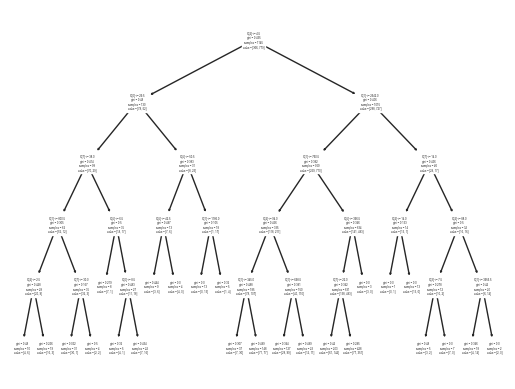

In [152]:
tree.plot_tree(clf)
plt.show()

In [209]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_split=8, max_depth=5, random_state=0).fit(X, y)

In [178]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=50).fit(X, y)

In [172]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, penalty='l2').fit(X, y)

In [196]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5,), random_state=1).fit(X, y)

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [210]:
y_score = clf.predict(X_test)

In [211]:
df.loc[df.credible_ct != True, 'y_score'] = y_score

In [212]:
df.loc[df.credible_ct != True, ['umi_count_mhc','umi_count_cd8','umi_count_TRA','umi_count_TRB',
                                'delta_umi_mhc','delta_umi_cd8','delta_umi_TRA','delta_umi_TRB',
                                'ct','peptide_HLA','peptide_HLA_lst','HLA_cd8','HLA_lst_cd8','y_score']]

umi_count_mhc  umi_count_cd8  umi_count_TRA  umi_count_TRB  \
0              20.0         1675.0            4.0           13.0   
1              26.0          895.0            3.0            6.0   
2               1.0         1338.0            7.0            6.0   
4              26.0          644.0            2.0           10.0   
7              22.0            9.0            3.0           14.0   
...             ...            ...            ...            ...   
2175           22.0         1044.0            0.0           11.0   
2177           20.0          479.0            0.0            3.0   
2179           23.0          516.0            0.0            6.0   
2181           22.0          649.0            0.0            8.0   
2182           21.0         1671.0            0.0           41.0   

      delta_umi_mhc  delta_umi_cd8  delta_umi_TRA  delta_umi_TRB      ct  \
0         80.000000     109.836066      16.000000           52.0  5548.0   
1        104.000000     143.200000      12.000000           24.0  3118.0   
2          4.000000     109.224490      28.000000           24.0   429.0   
4        104.000000     122.666667       8.000000           40.0  6191.0   
7         88.000000       1.440000       1.333333           56.0    64.0   
...             ...            ...            ...            ...     ...   
2175      88.000000     167.040000       0.000000           44.0  1201.0   
2177      80.000000      58.060606       0.000000           12.0  1752.0   
2179      92.000000      82.560000       0.000000           24.0  1814.0   
2181       2.378378       3.522388       0.000000           32.0  3752.0   
2182       4.941176     202.545455       0.000000          164.0  4910.0   

            peptide_HLA                      peptide_HLA_lst         HLA_cd8  \
0       RVRAYTYSK A0301                    [RVRAYTYSK A0301]  [A0201, B0702]   
1       YVLDHLIVV A0201                    [YVLDHLIVV A0201]  [A0201, A0301]   
2     RPHERNGFTVL B0702                  [RPHERNGFTVL B0702]         [B0702]   
4     RPHERNGFTVL B0702                  [RPHERNGFTVL B0702]  [A0201, A0301]   
7       RPPIFIRRL B0702                    [RPPIFIRRL B0702]  [A0201, A0301]   
...                 ...                                  ...             ...   
2175   TPRVTGGGAM B0702                   [TPRVTGGGAM B0702]  [A0201, A0301]   
2177   TPRVTGGGAM B0702                   [TPRVTGGGAM B0702]  [A0201, A0301]   
2179  RPHERNGFTVL B0702                  [RPHERNGFTVL B0702]  [A0201, A0301]   
2181    RVRAYTYSK A0301  [TPRVTGGGAM B0702, RVRAYTYSK A0301]  [A0201, A0301]   
2182    RVRAYTYSK A0301   [FLYALALLL A0201, RVRAYTYSK A0301]         [A0201]   

                                            HLA_lst_cd8  y_score  
0     [[A0201], [B0702], [A0201], [A0301, B0702], [A...      1.0  
1     [[A0201], [A0301, B0702], [B0702], [B0702], [B...      1.0  
2     [[A0201, B0702], [A0301, B0702], [A0201], [B07...      0.0  
4     [[A0201], [A0301, B0702], [A0301, B0702], [B07...      1.0  
7     [[A0201], [B0702], [A0201], [A0301, B0702], [B...      1.0  
...                                                 ...      ...  
2175  [[A0201], [A0201, B0702], [B0702], [A0201], [A...      1.0  
2177  [[A0201], [A0201, B0702], [A0201], [B0702], [B...      1.0  
2179  [[A0201], [B0702], [B0702], [A0201], [A0301, B...      1.0  
2181  [[B0702], [A0201, B0702], [B0702], [A0301, B07...      0.0  
2182  [[A0201, B0702], [B0702], [B0702], [A0201], [A...      1.0  

[1038 rows x 14 columns]

In [213]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

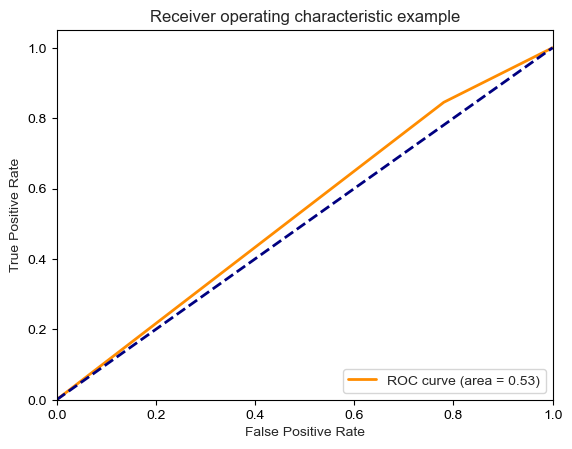

In [214]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [257]:
df.loc[df.ct == 2, ['ct','peptide_HLA','peptide_HLA_lst','ct_pep','ct_hla','ct_sample','sample_hla', 'pep_match', 'hla_match','ct_match']].head(60)

ct        peptide_HLA  \
8     2.0    RPPIFIRRL B0702   
639   2.0    RVRAYTYSK A0301   
858   2.0    YVLDHLIVV A0201   
1025  2.0    RVRAYTYSK A0301   
1045  2.0   TPRVTGGGAM B0702   
1195  2.0   TPRVTGGGAM B0702   
1452  2.0    RVRAYTYSK A0301   
1577  2.0   TPRVTGGGAM B0702   
1712  2.0  RPHERNGFTVL B0702   
1717  2.0   TPRVTGGGAM B0702   
1728  2.0    RVRAYTYSK A0301   
1733  2.0    RVRAYTYSK A0301   
1738  2.0    RPPIFIRRL B0702   
1776  2.0    RVRAYTYSK A0301   
1819  2.0    VLEETSVML A0201   
1880  2.0    RVRAYTYSK A0301   
1939  2.0   TPRVTGGGAM B0702   
1956  2.0    RVRAYTYSK A0301   
1960  2.0    RVRAYTYSK A0301   
1963  2.0    RVRAYTYSK A0301   
1978  2.0  TPSVSSSISSL B0702   
2000  2.0  TPSVSSSISSL B0702   
2022  2.0    RVRAYTYSK A0301   
2041  2.0   TPRVTGGGAM B0702   
2059  2.0    RVRAYTYSK A0301   
2091  2.0  TPSVSSSISSL B0702   
2113  2.0    RVRAYTYSK A0301   
2130  2.0    RVRAYTYSK A0301   
2132  2.0    RVRAYTYSK A0301   
2173  2.0    YVLDHLIVV A0201   

                                        peptide_HLA_lst           ct_pep  \
8                                     [RPPIFIRRL B0702]  RVRAYTYSK A0301   
639                                   [RVRAYTYSK A0301]  RVRAYTYSK A0301   
858                                   [YVLDHLIVV A0201]  RVRAYTYSK A0301   
1025                                  [RVRAYTYSK A0301]  RVRAYTYSK A0301   
1045                                 [TPRVTGGGAM B0702]  RVRAYTYSK A0301   
1195                [GLCTLVAML A0201, TPRVTGGGAM B0702]  RVRAYTYSK A0301   
1452                                  [RVRAYTYSK A0301]  RVRAYTYSK A0301   
1577                [RVRAYTYSK A0301, TPRVTGGGAM B0702]  RVRAYTYSK A0301   
1712                                [RPHERNGFTVL B0702]  RVRAYTYSK A0301   
1717                [RVRAYTYSK A0301, TPRVTGGGAM B0702]  RVRAYTYSK A0301   
1728                 [FLYALALLL A0201, RVRAYTYSK A0301]  RVRAYTYSK A0301   
1733                 [FLYALALLL A0201, RVRAYTYSK A0301]  RVRAYTYSK A0301   
1738                                  [RPPIFIRRL B0702]  RVRAYTYSK A0301   
1776  [CLGGLLTMV A0201, FLYALALLL A0201, RVRAYTYSK A...  RVRAYTYSK A0301   
1819                                  [VLEETSVML A0201]  RVRAYTYSK A0301   
1880                                  [RVRAYTYSK A0301]  RVRAYTYSK A0301   
1939                                 [TPRVTGGGAM B0702]  RVRAYTYSK A0301   
1956                                  [RVRAYTYSK A0301]  RVRAYTYSK A0301   
1960                                  [RVRAYTYSK A0301]  RVRAYTYSK A0301   
1963                 [FLYALALLL A0201, RVRAYTYSK A0301]  RVRAYTYSK A0301   
1978               [RPPIFIRRL B0702, TPSVSSSISSL B0702]  RVRAYTYSK A0301   
2000               [RPPIFIRRL B0702, TPSVSSSISSL B0702]  RVRAYTYSK A0301   
2022                                  [RVRAYTYSK A0301]  RVRAYTYSK A0301   
2041  [TPSVSSSISSL B0702, GLCTLVAML A0201, TPRVTGGGA...  RVRAYTYSK A0301   
2059                                  [RVRAYTYSK A0301]  RVRAYTYSK A0301   
2091                                [TPSVSSSISSL B0702]  RVRAYTYSK A0301   
2113                 [FLYALALLL A0201, RVRAYTYSK A0301]  RVRAYTYSK A0301   
2130                 [FLYALALLL A0201, RVRAYTYSK A0301]  RVRAYTYSK A0301   
2132                                  [RVRAYTYSK A0301]  RVRAYTYSK A0301   
2173                                  [YVLDHLIVV A0201]  RVRAYTYSK A0301   

     ct_hla  ct_sample sample_hla  pep_match  hla_match ct_match  
8       NaN        NaN                 False      False    False  
639     NaN        NaN                  True      False    False  
858     NaN        NaN                 False      False    False  
1025    NaN        NaN                  True      False    False  
1045    NaN        NaN                 False      False    False  
1195    NaN        NaN                 False      False    False  
1452    NaN        NaN                  True      False    False  
1577    NaN        NaN                 False      False    False  
1712    NaN        NaN                 False      Fals

In [37]:
df.loc[(~df.ct_pep.isna()) | (~df.ct_hla.isna()) | (~df.ct_sample.isna()), ['ct','peptide_HLA','peptide_HLA_lst','ct_pep','ct_hla','ct_sample','sample_hla', 'pep_match', 'hla_match','ct_match']].head(60)

ct        peptide_HLA  \
3      1.0    VLEETSVML A0201   
5     34.0    YVLDHLIVV A0201   
6      4.0  RPHERNGFTVL B0702   
8      2.0    RPPIFIRRL B0702   
13     3.0   TPRVTGGGAM B0702   
14    42.0  TPSVSSSISSL B0702   
15    18.0    VLEETSVML A0201   
17    26.0    RVRAYTYSK A0301   
18    24.0    RVRAYTYSK A0301   
19     3.0   TPRVTGGGAM B0702   
23     3.0   TPRVTGGGAM B0702   
24     1.0    VLEETSVML A0201   
26    13.0    RVRAYTYSK A0301   
28    22.0  RPHERNGFTVL B0702   
30     4.0  RPHERNGFTVL B0702   
31     1.0    RPPIFIRRL B0702   
33    13.0  RPHERNGFTVL B0702   
35     3.0   TPRVTGGGAM B0702   
36     1.0    CLGGLLTMV A0201   
38     4.0  RPHERNGFTVL B0702   
39     3.0   TPRVTGGGAM B0702   
40    42.0  TPSVSSSISSL B0702   
42     3.0   TPRVTGGGAM B0702   
43     3.0   TPRVTGGGAM B0702   
45     3.0   TPRVTGGGAM B0702   
47     3.0    RVRAYTYSK A0301   
48     3.0   TPRVTGGGAM B0702   
51   131.0   TPRVTGGGAM B0702   
53    14.0   TPRVTGGGAM B0702   
55    26.0    RVRAYTYSK A0301   
60    54.0    YVLDHLIVV A0201   
61     4.0  RPHERNGFTVL B0702   
62     1.0    VLEETSVML A0201   
63    75.0    VLEETSVML A0201   
66    32.0   TPRVTGGGAM B0702   
67   188.0    YVLDHLIVV A0201   
70    50.0   TPRVTGGGAM B0702   
71     4.0  RPHERNGFTVL B0702   
72     4.0  RPHERNGFTVL B0702   
76     3.0    RVRAYTYSK A0301   
78    30.0  RPHERNGFTVL B0702   
79     4.0    CLGGLLTMV A0201   
80     3.0   TPRVTGGGAM B0702   
81    70.0   TPRVTGGGAM B0702   
83    32.0   RPHERNGFTV B0702   
84     1.0    VLEETSVML A0201   
85     7.0    CLGGLLTMV A0201   
91     3.0   TPRVTGGGAM B0702   
92    15.0    RVRAYTYSK A0301   
94     4.0  RPHERNGFTVL B0702   
98     7.0    RVRAYTYSK A0301   
109    3.0   TPRVTGGGAM B0702   
110    4.0  RPHERNGFTVL B0702   
113    1.0    RVRAYTYSK A0301   
114   19.0   TPRVTGGGAM B0702   
117   15.0   TPRVTGGGAM B0702   
119    1.0    RPPIFIRRL B0702   
121    1.0    VLEETSVML A0201   
128   88.0    YVLDHLIVV A0201   
131    3.0   TPRVTGGGAM B0702   

                                       peptide_HLA_lst             ct_pep  \
3                                    [VLEETSVML A0201]    VLEETSVML A0201   
5                                    [YVLDHLIVV A0201]                NaN   
6                 [GILGFVFTL A0201, RPHERNGFTVL B0702]  RPHERNGFTVL B0702   
8                                    [RPPIFIRRL B0702]    RVRAYTYSK A0301   
13                                  [TPRVTGGGAM B0702]   TPRVTGGGAM B0702   
14                                 [TPSVSSSISSL B0702]  TPSVSSSISSL B0702   
15                  [YVLDHLIVV A0201, VLEETSVML A0201]    VLEETSVML A0201   
17                                   [RVRAYTYSK A0301]    RVRAYTYSK A0301   
18                                   [RVRAYTYSK A0301]    RVRAYTYSK A0301   
19                                  [TPRVTGGGAM B0702]   TPRVTGGGAM B0702   
23   [GLCTLVAML A0201, CLGGLLTMV A0201, FLYALALLL A...   TPRVTGGGAM B0702   
24                                   [VLEETSVML A0201]    VLEETSVML A0201   
26                                   [RVRAYTYSK A0301]  RPHERNGFTVL B0702   
28                                 [RPHERNGFTVL B0702]  RPHERNGFTVL B0702   
30                                 [RPHERNGFTVL B0702]  RPHERNGFTVL B0702   
31                                   [RPPIFIRRL B0702]    VLEETSVML A0201   
33                                 [RPHERNGFTVL B0702]  RPHERNGFTVL B0702   
35                                  [TPRVTGGGAM B0702]   TPRVTGGGAM B0702   
36                                   [CLGGLLTMV A0201]    VLEETSVML A0201   
38                                 [RPHERNGFTVL B0702]  RPHERNGFTVL B0702   
39                                  [TPRVTGGGAM B0702]   TPRVTGGGAM B0702   
40                                 [TPSVSSSISSL B0702]  TPSVSSSISSL B0702   
42                                  [TPRVTGGGAM B0702]   TPRVTGGGAM B0702   
43                                  [TPRVTGGGAM B0702]   TPRVTGGGAM B0702   
45                                  [TPRVTGGGAM B0702]   TPRVTGGGAM B

In [42]:
df.loc[(df.ct_match == True) & (df.pep_match == False),['ct','peptide_HLA','peptide_HLA_lst','ct_pep','ct_hla','ct_sample','sample_hla', 'pep_match', 'hla_match','ct_match']]

ct        peptide_HLA                     peptide_HLA_lst  \
26      13.0    RVRAYTYSK A0301                   [RVRAYTYSK A0301]   
31       1.0    RPPIFIRRL B0702                   [RPPIFIRRL B0702]   
36       1.0    CLGGLLTMV A0201                   [CLGGLLTMV A0201]   
47       3.0    RVRAYTYSK A0301                   [RVRAYTYSK A0301]   
76       3.0    RVRAYTYSK A0301                   [RVRAYTYSK A0301]   
...      ...                ...                                 ...   
2099     7.0    RVRAYTYSK A0301  [CLGGLLTMV A0201, RVRAYTYSK A0301]   
2136  6312.0  RPHERNGFTVL B0702                 [RPHERNGFTVL B0702]   
2146    13.0    RVRAYTYSK A0301                   [RVRAYTYSK A0301]   
2149     7.0   TPRVTGGGAM B0702                  [TPRVTGGGAM B0702]   
2152     1.0    RVRAYTYSK A0301                   [RVRAYTYSK A0301]   

                 ct_pep ct_hla  ct_sample      sample_hla  pep_match  \
26    RPHERNGFTVL B0702  B0702        7.0         [B0702]      False   
31      VLEETSVML A0201    NaN       10.0  [A0201, A0301]      False   
36      VLEETSVML A0201    NaN       10.0  [A0201, A0301]      False   
47     TPRVTGGGAM B0702  B0702        9.0         [B0702]      False   
76     TPRVTGGGAM B0702  B0702        9.0         [B0702]      False   
...                 ...    ...        ...             ...        ...   
2099    CLGGLLTMV A0201    NaN       10.0  [A0201, A0301]      False   
2136   TPRVTGGGAM B0702  B0702        7.0         [B0702]      False   
2146  RPHERNGFTVL B0702  B0702        7.0         [B0702]      False   
2149    CLGGLLTMV A0201    NaN       10.0  [A0201, A0301]      False   
2152    VLEETSVML A0201    NaN       10.0  [A0201, A0301]      False   

      hla_match ct_match  
26        False     True  
31        False     True  
36         True     True  
47        False     True  
76        False     True  
...         ...      ...  
2099       True     True  
2136       True     True  
2146      False     True  
2149      False     True  
2152       True     True  

[122 rows x 10 columns]

In [46]:
df.hla_match.isna().any()

False

In [47]:
plt_df = instance.plt_df

In [65]:
# selected_clonotypes = df.groupby('ct').size()
# 
# ct = 1
# 
# instance = Evaluate_Clonotype(df, ct, selected_clonotypes, use_relative_umi=False)
# instance.sum_umi()
# instance.calc_summary()
# 
# if instance.test_dist():
#     df.loc[instance.idx, 'ct_pep'] = instance.get_imputed_peptide()
# 
#     instance.update_bins()
#     instance.update_flag('significant')
# else:
#     instance.update_flag('insignificant')
# 
# selected_peptides = instance.summary_df.head(11).index
# 
# sub_mat = instance.mat[instance.mat.index.isin(selected_peptides)]
# 
# plt_df = sub_mat.melt(ignore_index=False, var_name='gem', value_name='umi').dropna()
# 
# dct = plt_df.groupby('gem', sort=False).size().to_frame().reset_index().reset_index().set_index('gem').rename(columns={'index':'gem_count',0:'peptide_count'})
# dct['gem_count'] = dct.gem_count + 1
# 
# # Make a var for iterating over GEMs
# plt_df['gem_count'] = plt_df.gem.map(dct.gem_count)
# plt_df.reset_index(inplace=True)
# 
# # Sort according to summary
# plt_df.peptide_HLA_lst = plt_df.peptide_HLA_lst.astype("category")
# plt_df['peptide_HLA_lst'] = plt_df.peptide_HLA_lst.cat.set_categories(selected_peptides) # instead of inplace
# plt_df.sort_values(by='peptide_HLA_lst', inplace=True)
# 
# # Add scatter values
# for i, (name, subdf) in enumerate(plt_df.groupby('peptide_HLA_lst', sort=False)): #reversed(list(grouped))
#     plt_df.loc[subdf.index, 'y'] = np.random.normal(i, 0.1, subdf.shape[0])
#     
# plt_df['clonotype'] = f'clonotype {ct}'

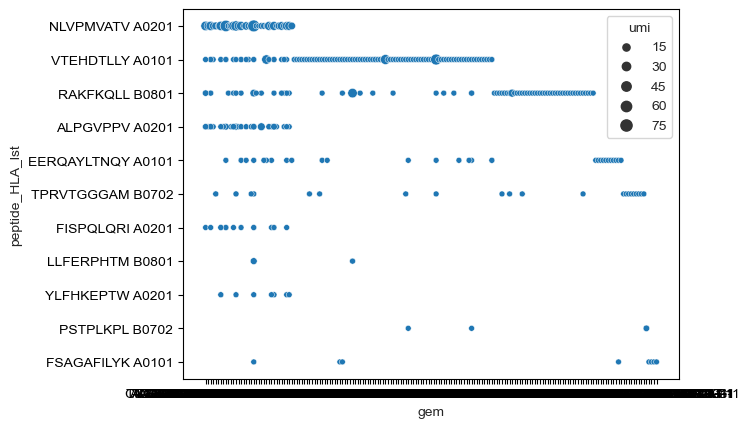

In [27]:
sns.scatterplot(data=plt_df, x="gem", y='peptide_HLA_lst', size='umi') #, legend='brief'
plt.show()

In [194]:
lol = (plt_df.sort_values(by=['gem','umi'])
       .drop_duplicates(subset='gem', keep='last')
       .groupby('peptide_HLA_lst').gem.count()
       .to_frame())

In [195]:
lol['clonotype'] = f'clonotype {ct}'

In [196]:
lol.reset_index(inplace=True)

In [197]:
lol['concordance'] = lol.gem / lol.gem.sum()

In [198]:
#lol.replace(0, np.nan, inplace=True)

In [199]:
lol

peptide_HLA_lst  gem      clonotype  concordance
0     NLVPMVATV A0201   32  clonotype 3.0     0.178771
1     VTEHDTLLY A0101   64  clonotype 3.0     0.357542
2      RAKFKQLL B0801   43  clonotype 3.0     0.240223
3      ALPGVPPV A0201    2  clonotype 3.0     0.011173
4   EERQAYLTNQY A0101   15  clonotype 3.0     0.083799
5    TPRVTGGGAM B0702   16  clonotype 3.0     0.089385
6     FISPQLQRI A0201    0  clonotype 3.0     0.000000
7     LLFERPHTM B0801    0  clonotype 3.0     0.000000
8     YLFHKEPTW A0201    0  clonotype 3.0     0.000000
9      PSTPLKPL B0702    1  clonotype 3.0     0.005587
10   FSAGAFILYK A0101    6  clonotype 3.0     0.033520

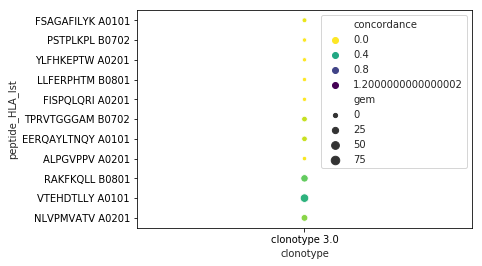

In [200]:
g = sns.scatterplot(data=lol, x='clonotype', y='peptide_HLA_lst', size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r')

In [120]:
def get_legend_n_handle(l,h,key='gem'):
    leg = list()
    hdl = list()
    keep = False
    for i,e in enumerate(l):
        if keep:
            if int(float(e)) > 0:
                leg.append(int(float(e)))
                hdl.append(h[i])
        if e == key:
            keep = True
            leg.append(e)
            hdl.append(h[i])
    return hdl, leg

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


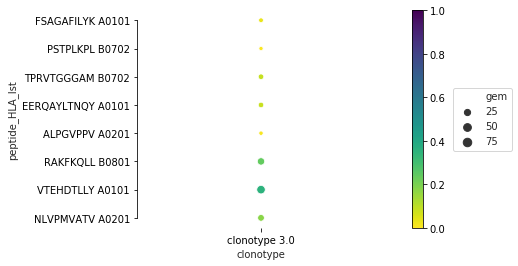

In [121]:
plot = plt.scatter([], [], c=[], cmap='viridis_r', vmin=0, vmax=1)
#plt.clf()
plt.colorbar(plot)
g = sns.scatterplot(data=lol,
                x='clonotype', y='peptide_HLA_lst', size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r')

h,l = g.get_legend_handles_labels()
#plt.legend(h[-5:],l[-5:],bbox_to_anchor=(1.2, 0.5), loc=6)
hn,ln = get_legend_n_handle(l,h,key='gem')
plt.legend(hn,ln,bbox_to_anchor=(1.2, 0.5), loc=6)
sns.despine(trim=True, offset={'left':-10,'right':-10})
plt.show()

In [122]:
PROPS = {
    'boxprops':{'alpha':0.3}, #'facecolor':'none', 
    'medianprops':{'alpha':0.3},
    'whiskerprops':{'alpha':0.3},
    'capprops':{'alpha':0.3}
}
EMPTY = {
    'boxprops':{'alpha':0}, #'facecolor':'none', 
    'medianprops':{'alpha':0},
    'whiskerprops':{'alpha':0},
    'capprops':{'alpha':0}
}
ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':plt_df, 'showfliers':False}
#x="umi", y="peptide_HLA_lst", data=plt_df, showfliers=False

In [123]:
n = plt_df.gem_count.max()

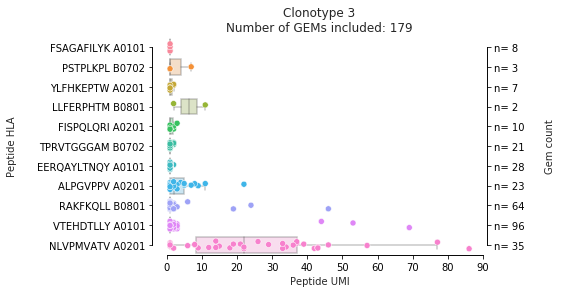

In [185]:
order = plt_df.peptide_HLA_lst.unique()[::-1]
ax = sns.boxplot(**ARGS, **PROPS, order=order) # boxprops=dict(alpha=0.3)
sns.stripplot(data=plt_df, ax=ax, x="umi", y='peptide_HLA_lst', order=order, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
tx = ax.twinx()
sns.boxplot(**ARGS, ax=tx, **EMPTY) #boxprops=dict(alpha=0)
#sns.scatterplot(data=plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False)
# Fix 2nd yticklabels
#tx.set_yticks(np.arange(len(plt_df.peptide_HLA_lst.unique())))
tx.set_yticklabels([f'n= {n}' for n in reversed(plt_df.groupby('peptide_HLA_lst').size())])
tx.set_ylabel('Gem count', labelpad=20)
ax.set_ylabel('Peptide HLA', labelpad=20)
ax.set_xlabel('Peptide UMI')

# Fix x-axis
xmax = round(plt_df.umi.max(), -1)
plt.xticks(np.arange(0, xmax+10, 10),np.arange(0, xmax+10, 10))
ax.spines['bottom'].set_bounds(0, xmax)

sns.despine(trim=True, right=False)
#plt.tick_params(axis='y', which='both', right=True)
plt.title(f'Clonotype 3\nNumber of GEMs included: {n}')
plt.show()

In [125]:
plt_df

peptide_HLA_lst                 gem  umi  gem_count          y
148   NLVPMVATV A0201  CTGCGGATCACTATTC-1   46         94  -0.021244
255   NLVPMVATV A0201  TCTTTCCAGAGAGCTC-1   26        160   0.120481
40    NLVPMVATV A0201  ACTGTCCAGGTACTCT-1   42         25  -0.037579
46    NLVPMVATV A0201  AGACGTTCACCCATTC-1   18         29   0.069524
247   NLVPMVATV A0201  TCAGGATCAAGGGTCA-1   22        153  -0.174374
..                ...                 ...  ...        ...        ...
243  FSAGAFILYK A0101  TATGCCCCAGCTTCGG-1    1        150  10.106585
142  FSAGAFILYK A0101  CTCTGGTCACGTAAGG-1    1         92  10.005669
176  FSAGAFILYK A0101  GACGGCTAGTATTGGA-1    1        106   9.809341
21   FSAGAFILYK A0101  ACCTTTATCGTGACAT-1    1         15   9.876500
143  FSAGAFILYK A0101  CTGCCTACACTGCCAG-1    1         93   9.985620

[297 rows x 5 columns]

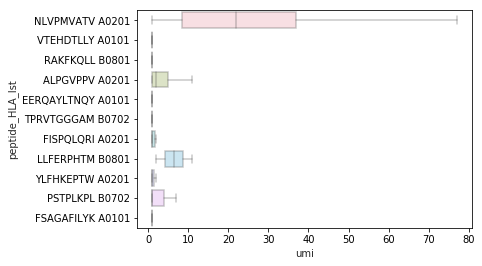

In [80]:
b = sns.boxplot(**ARGS, **PROPS)

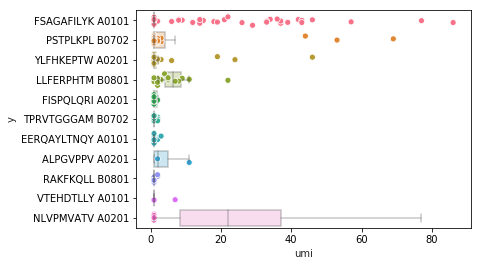

In [129]:
sns.boxplot(**ARGS, **PROPS, order=plt_df.peptide_HLA_lst.unique()[::-1])
sns.scatterplot(data=plt_df, x="umi", y='y', hue='peptide_HLA_lst', legend=False)


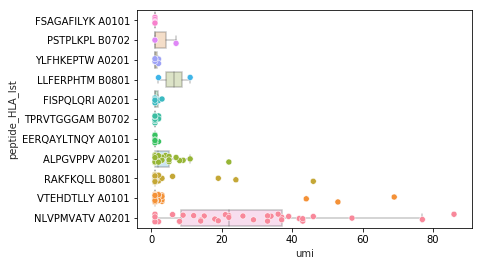

In [180]:
sns.boxplot(**ARGS, **PROPS, order=order) #plt_df.peptide_HLA_lst.unique()[::-1])
s = sns.stripplot(data=plt_df, x="umi", y='peptide_HLA_lst', order=order, hue='peptide_HLA_lst', jitter=0.2, edgecolor='white',linewidth=0.5, size=6) #, hue='peptide_HLA_lst'
s.legend_.remove()

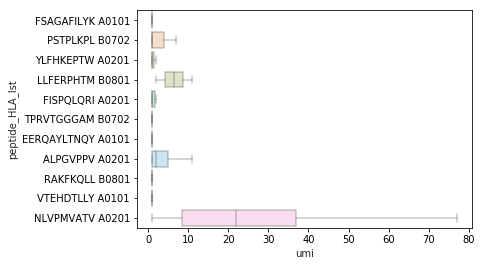

In [181]:
sns.boxplot(**ARGS, **PROPS, order=order)

AttributeError: 'NoneType' object has no attribute 'remove'

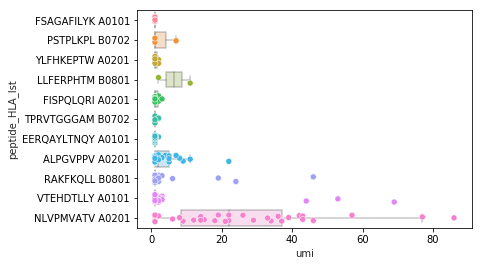

In [184]:
sns.boxplot(**ARGS, **PROPS, order=order)
s = sns.stripplot(data=plt_df, x="umi", y='peptide_HLA_lst', order=order, jitter=0.2, edgecolor='white',linewidth=0.5, size=6) #, hue='peptide_HLA_lst'
s.legend_.remove()

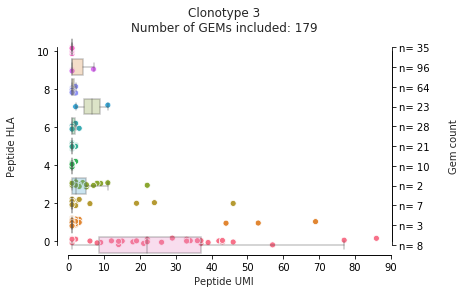

In [92]:
ax = sns.scatterplot(data=plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False)
tx = ax.twinx()
#sns.boxplot(**ARGS, ax=tx, **EMPTY) #boxprops=dict(alpha=0)
sns.boxplot(**ARGS, ax=tx, **PROPS, order=plt_df.peptide_HLA_lst.unique()[::-1]) # boxprops=dict(alpha=0.3) #, order=list(b.get_yticklabels())[::-1]
# Fix 2nd yticklabels
#tx.set_yticks(np.arange(len(plt_df.peptide_HLA_lst.unique())))
tx.set_yticklabels([f'n= {n}' for n in plt_df.groupby('peptide_HLA_lst').size()])
tx.set_ylabel('Gem count', labelpad=20)
ax.set_ylabel('Peptide HLA', labelpad=20)
ax.set_xlabel('Peptide UMI')

# Fix x-axis
xmax = round(plt_df.umi.max(), -1)
plt.xticks(np.arange(0, xmax+10, 10),np.arange(0, xmax+10, 10))
ax.spines['bottom'].set_bounds(0, xmax)

sns.despine(trim=True, right=False)
#plt.tick_params(axis='y', which='both', right=True)
plt.title(f'Clonotype 3\nNumber of GEMs included: {n}')
plt.show()

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


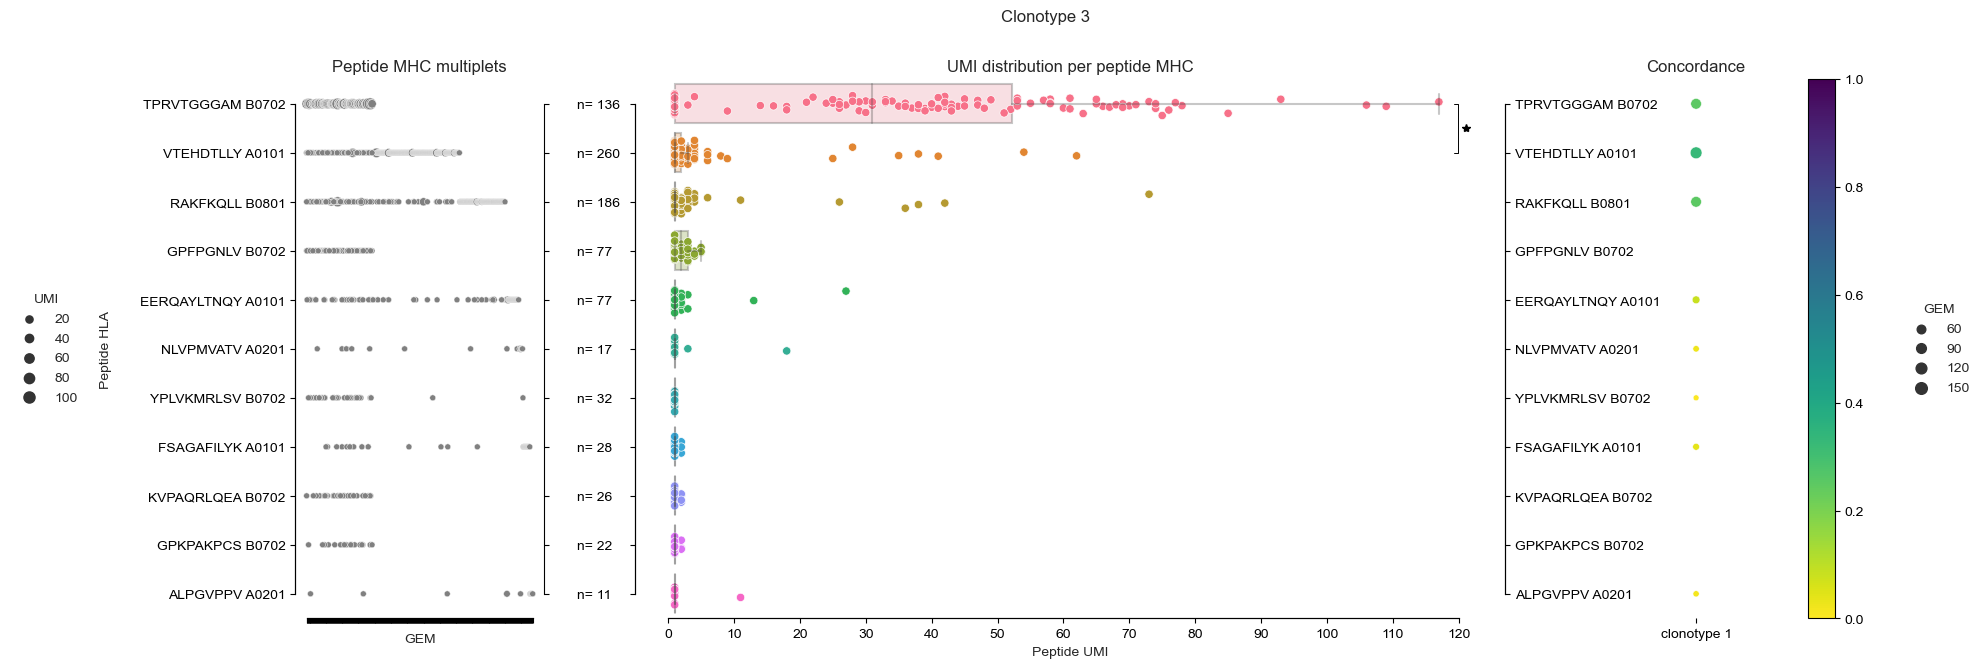

In [81]:
fig = plt.figure(figsize=(20,7))
fig.suptitle(f"Clonotype {ct}")

gs = gridspec.GridSpec(1, 3, width_ratios=[2, 7, 2], wspace=0.2) #, left=0.05
ax1 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1]) #ax2 = plt.subplot(gs[0,1])
ax3 = fig.add_subplot(gs[2]) #ax3 = plt.subplot(gs[0, 2])

########################
# Add multipletplot
###############################
tx1 = ax1.twinx()
sns.scatterplot(data=plt_df, x="gem", y='peptide_HLA_lst', size='umi', color="gray", ax=ax1)
sns.scatterplot(data=plt_df, x="gem", y='peptide_HLA_lst', size='umi', color="gray", legend=False, ax=tx1)
ax1.legend(bbox_to_anchor=(-1, 0.5), loc=10, frameon=False, title='UMI')

########################
# Add boxplot
###############################
tx2 = ax2.twinx() # hack to get matching ticks on the right
sns.boxplot(**ARGS, **PROPS, ax=ax2) # boxprops=dict(alpha=0.3)
sns.boxplot(**ARGS, ax=tx2, **EMPTY) #boxprops=dict(alpha=0)
sns.scatterplot(data=plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False, ax=ax2)

# Add significance bar
if instance.test_dist():
    y = [0,0,1,1]
    x0 = plt_df.umi.max()
    x1 = x0 * 1.02
    x2 = x0 * 1.025
    x3 = x0 * 1.035

    ax2.plot([x1, x2, x2, x1], y, lw=0.7, c='0') #lw=1.5, 
    ax2.plot(x3, np.mean(y), marker="*", c='0')

######################################
# Add concordance plot
#########################################
# Hack to get colorbar
plot = ax3.scatter([], [], c=[], cmap='viridis_r', vmin=0, vmax=1)
fig.colorbar(plot, ax=ax3)
sns.scatterplot(data=lol, x='clonotype', y='peptide_HLA_lst',
                size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r', ax=ax3) #g = 

# Remove automatic sns legend for hue, keep only legend for size.
h,l = ax3.get_legend_handles_labels()
ax3.legend(h[-4:], l[-4:], bbox_to_anchor=(1.5, 0.5), loc=6, frameon=False, title='GEM')

######################################
# Prettify
#########################################

ax1.set_title('Peptide MHC multiplets')
ax2.set_title('UMI distribution per peptide MHC')
ax3.set_title('Concordance')

xmax = round(plt_df.umi.max(), -1)
ax2.set_xticks(np.arange(0, xmax+10, 10))
ax3.set_yticks([])

ax1.set_xticklabels([])
tx1.set_yticklabels([f'n= {n}' for n in plt_df.groupby('peptide_HLA_lst').size()])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

ax1.set_xlabel('GEM')
ax1.set_ylabel('Peptide HLA', labelpad=20)
tx1.set_ylabel('')
ax2.set_xlabel('Peptide UMI')
ax2.set_ylabel('')
tx2.set_ylabel('')
ax3.set_ylabel('')
ax3.set_xlabel('')

tx1.tick_params(axis='y', pad=20)

ax2.spines['bottom'].set_bounds(0, xmax) # Hack to fix x-axis

sns.despine(trim=True, right=True, ax=ax1)
sns.despine(trim=True, right=False, ax=tx1)
sns.despine(trim=True, right=False, ax=ax2)
sns.despine(trim=True, right=False, ax=tx2)
sns.despine(trim=True, left=True, ax=ax3) #offset={'left':-5,'right':-5}
plt.show()

# Make GIF

In [24]:
import imageio

In [25]:
import os

In [26]:
filenames = list()
for n in range(plt_df.gem_count.max()+1):
    print(n)
    #if n == 0:
    #    # Initialize the plotting frame
    #    np.random.seed(123)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df, alpha=0, jitter=True)
    #elif n == plt_df.gem_count.max():
    #    np.random.seed(123)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df, alpha=0, jitter=True)
    #    ax = sns.boxplot(x="umi", y="peptide_HLA_lst", data=plt_df[plt_df.gem_count <= n], fliersize=0)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df[plt_df.gem_count <= n], jitter=True)
    #else:
    #    np.random.seed(123)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df, alpha=0, jitter=True)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df[plt_df.gem_count <= n], jitter=True)
    
    # Hack to fix axes
    ax = sns.boxplot(**ARGS, **EMPTY) # boxprops=dict(alpha=0.3)
    tx = ax.twinx()
    sns.boxplot(**ARGS, ax=tx, **EMPTY) #boxprops=dict(alpha=0)
    # Plot scatter
    sns.scatterplot(data=plt_df[plt_df.gem_count <= n], x="umi", y="y", hue='peptide_HLA_lst', legend=False)
    
    # Fix 2nd yticklabels
    tx.set_yticklabels([f'n= {n}' for n in plt_df[plt_df.gem_count <= n].groupby('peptide_HLA_lst').size()])
    tx.set_ylabel('Gem count', labelpad=20)
    ax.set_ylabel('Peptide HLA', labelpad=20)
    ax.set_xlabel('Peptide UMI')

    # Fix x-axis
    xmax = round(plt_df.umi.max(), -1)
    plt.xticks(np.arange(0, xmax+10, 10),np.arange(0, xmax+10, 10))
    ax.spines['bottom'].set_bounds(0, xmax)

    sns.despine(trim=True, right=False, offset=5)
    #plt.tick_params(axis='y', which='both', right=True)
    plt.title(f'Clonotype 3\nNumber of GEMs included: {n}')
    
    filename = f'{n}.png'
    filenames.append(filename)
    
    # repeat last frame
    if (n == plt_df.gem_count.max()):
        for i in range(10): # a longer pause before adding boxplots...
            filenames.append(filename)
    else:
        for i in range(2): # Pause between adding points
            filenames.append(filename)
    
    #sns.despine(trim=True, right=False)
    #plt.tick_params(axis='y', which='both', right=True)
    #plt.title(f'Number of GEMs included: {n}')
    ##plt.xlim(0, plt_df.umi.max()+1)
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    
# Adding boxes!
n += 1
filename = f'{n}.png'
filenames.append(filename)

# repeat last frame
for i in range(50): # a looong pause after adding boxplots...
    filenames.append(filename)

# Plot
ax = sns.boxplot(**ARGS, **PROPS) # boxprops=dict(alpha=0.3)
tx = ax.twinx()
sns.boxplot(**ARGS, ax=tx, **EMPTY) #boxprops=dict(alpha=0)
sns.scatterplot(data=plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False)
# Fix 2nd yticklabels
#tx.set_yticks(np.arange(len(plt_df.peptide_HLA_lst.unique())))
tx.set_yticklabels([f'n= {n}' for n in plt_df.groupby('peptide_HLA_lst').size()])
tx.set_ylabel('Gem count', labelpad=20)
ax.set_ylabel('Peptide HLA', labelpad=20)
ax.set_xlabel('Peptide UMI')

# Fix x-axis
xmax = round(plt_df.umi.max(), -1)
plt.xticks(np.arange(0, xmax+10, 10),np.arange(0, xmax+10, 10))
ax.spines['bottom'].set_bounds(0, xmax)

sns.despine(trim=True, right=False, offset=5)
#plt.tick_params(axis='y', which='both', right=True)
plt.title(f'Clonotype 3\nNumber of GEMs included: {n}')
plt.savefig(filename, bbox_inches='tight')
plt.close()

# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [ ]:
def get_nonsinglet_idxs(duplicated_list):
    dups = collections.defaultdict(list)
    for i, e in enumerate(duplicated_list):
        dups[e].append(i)
    idxs = []
    for k, v in sorted(dups.items()):
        if len(v) > 1:
            idxs += v
    return idxs

In [6]:
def assign_clonotype(tcr_df, clonotype_variables = ['v_gene_TRA','j_gene_TRA','v_gene_TRB','j_gene_TRB','cdr3_comb']):
    
    tcr_df.loc[:, clonotype_variables] = tcr_df.loc[:, clonotype_variables].fillna('unknown')
    new_clonotype = tcr_df.groupby(clonotype_variables).gem.unique().to_frame()
    new_clonotype['n_gems'] = new_clonotype.gem.apply(len)
    new_clonotype.sort_values(by='n_gems', ascending=False, inplace=True)
    dct = new_clonotype.to_dict()['gem']
    for i, k in enumerate(dct.keys(), start=1): 
        dct[k] = i
    return tcr_df.set_index(clonotype_variables).index.map(dct)

#tcr_df['ct'] = assign_clonotype()

# Input

### OBS! exp

In [13]:
INPUT = '/Users/herpov/Documents/mnt/computerome_projects/people/helpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'

In [11]:
#INPUT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.imputed.csv'

In [8]:
INPUT = '../data/exp9.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'

In [80]:
INPUT = '../experiments/exp13/run2/cat/tables/tcr_barcode.cleaned.csv'
df = pd.read_csv(INPUT, converters=converters) #

# Output

In [11]:
PLT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/plots/exp9_IONTORRENT_KMA_AKB/reports/mhc_umi_dist_per_ct/'

# Load

In [81]:
df = pd.read_csv(INPUT, converters=converters) #

SyntaxError: unexpected EOF while parsing (<unknown>, line 0)

In [14]:
def alt_test_dist():
    from scipy.stats import norm
    
    p1 = summary_df.index[0]
    p2 = summary_df.index[1]
    
    s1 = mat.T[p1].dropna().to_list()
    s2 = mat.T[p2].dropna().to_list()
    
    # Alternative to subsampling (not implemented)
    _, pp = stats.ttest_ind(s1, s2, equal_var=False, alternative='greater')
    
    if pp <= 0.05:
        print('*** Significant with no sampling')
        return True
    else:
        print('--- Insignificant even with no sampling')
        return False

In [15]:
def test_dist():
    from scipy.stats import norm
    
    p1 = summary_df.index[0]
    p2 = summary_df.index[1]
    
    s1 = mat.T[p1].dropna().to_list()
    s2 = mat.T[p2].dropna().to_list()
    
    n = min(len(s1), len(s2))
    m = max(len(s1), len(s2))
    
    # Alternative, when we only have a single GEM
    if (n == 1) & (m > 9):
        if len(s1) == 1:
            cdf = norm.cdf(s1, loc=np.mean(s2), scale=np.std(s2))
            if cdf < 0.05:
                print('*** Significant with cdf')
                return True
            else:
                print('--- Insignificant with cdf')
                return False
        elif len(s2) == 1:
            cdf = norm.cdf(s2, loc=np.mean(s1), scale=np.std(s1))
            if cdf < 0.05:
                print('*** Significant with cdf')
                return True
            else:
                print('--- Insignificant with cdf')
                return False
    elif n == 1:
        print('NaN p-value')
        return False
    
    ## Alternative to subsampling (not implemented)
    #_, pp = stats.ttest_ind(s1, s2, equal_var=False, alternative='greater')
    #
    #if pp <= 0.05:
    #    print('*** Significant with no sampling')
    #else:
    #    print('--- Insignificant even with no sampling')
        
    if n < 5:
        return False
    
    p_list = list()
    for _ in range(10):
        l1 = sample(s1, n)
        l2 = sample(s2, n)

        t, p = stats.ttest_ind(l1, l2, equal_var=False, alternative='greater')
        
        p_list.append(p)
    
    if np.median(p_list) <= 0.05:
        return True
    #print(sorted(p_list))
    return False

In [15]:
alt_sign = 0

Quantiles umi_count_mhc vs mat: 42.0 42


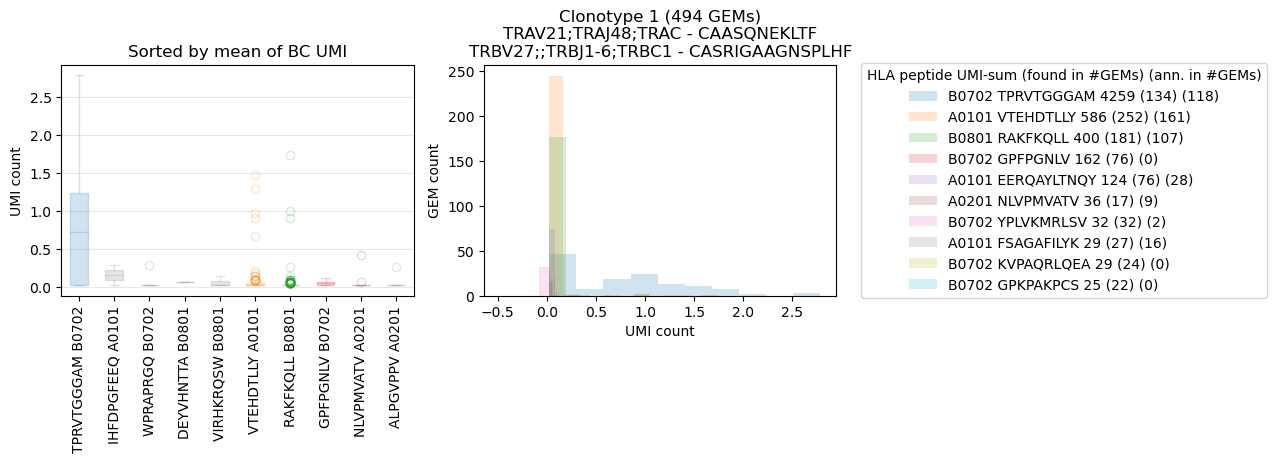

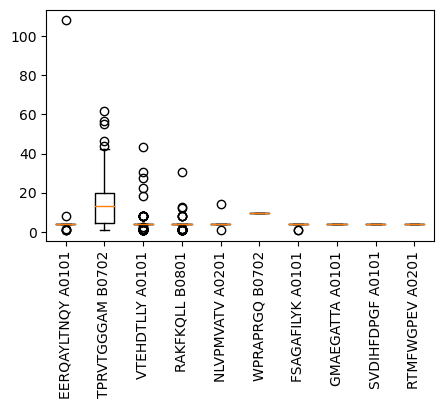

Quantiles umi_count_mhc vs mat: 90.0 90


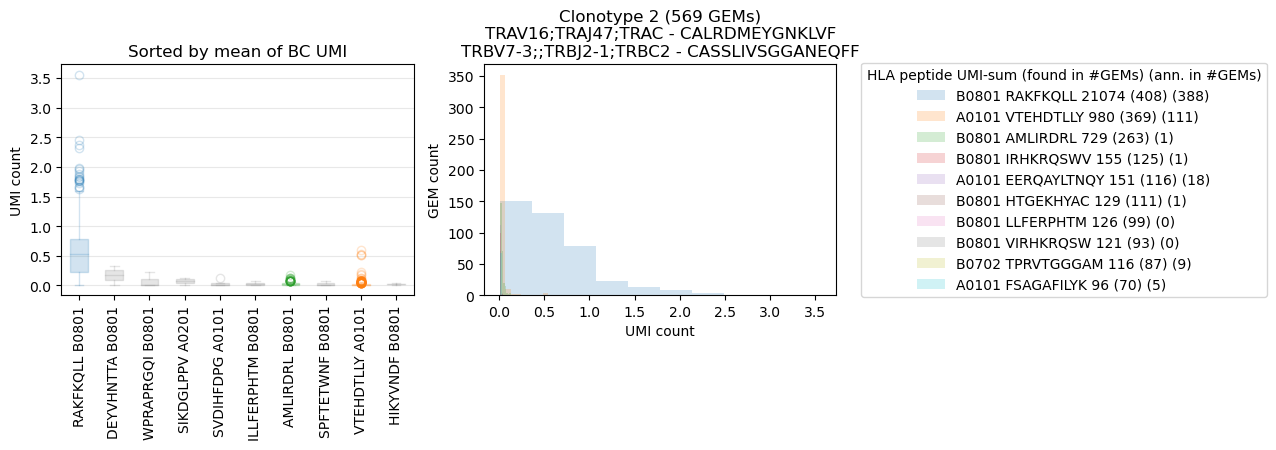

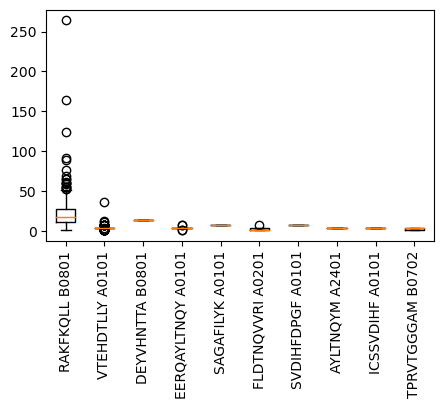

Quantiles umi_count_mhc vs mat: 22.0 22


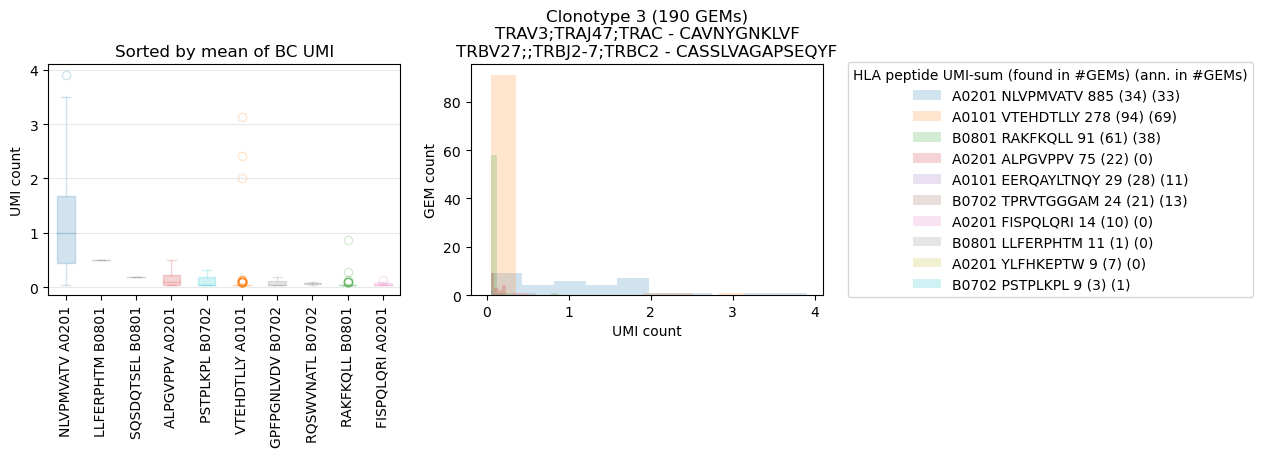

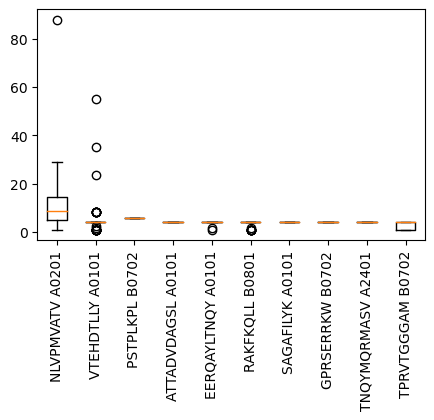

Quantiles umi_count_mhc vs mat: 116.0 116


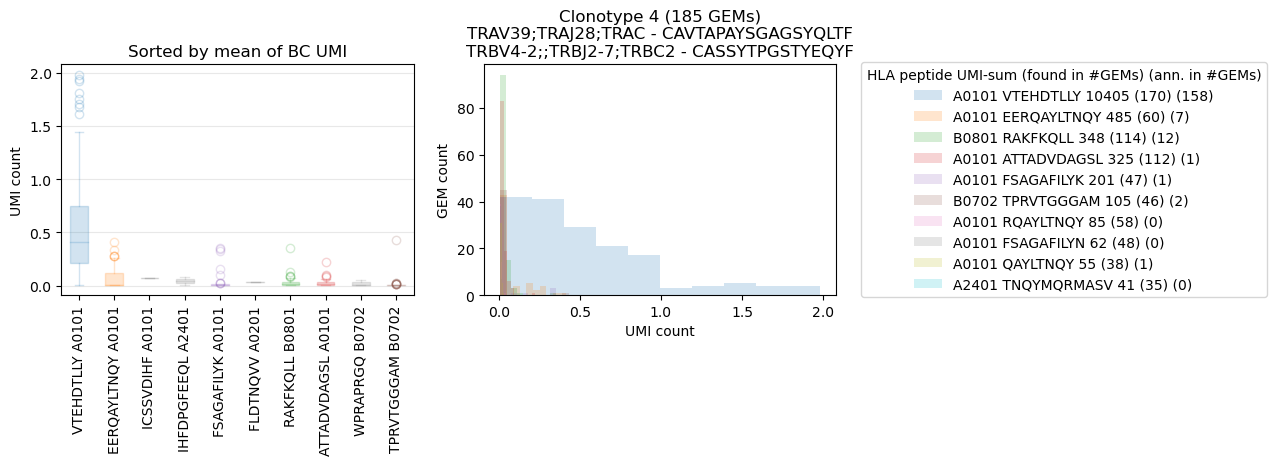

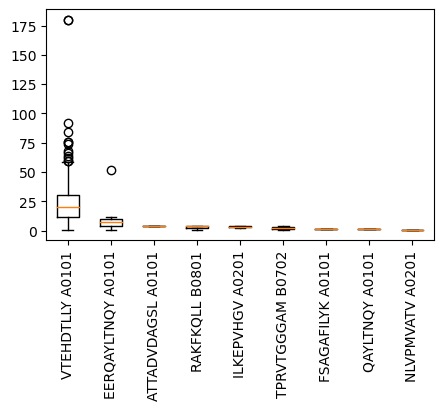

Quantiles umi_count_mhc vs mat: 124.0 124
Multiple TCR chains - in theory unsolvable!


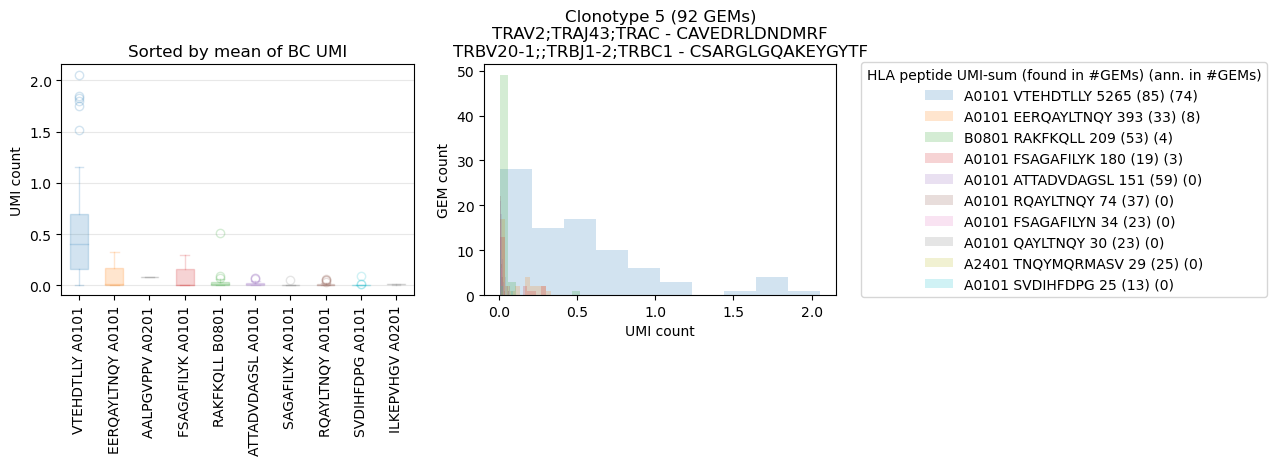

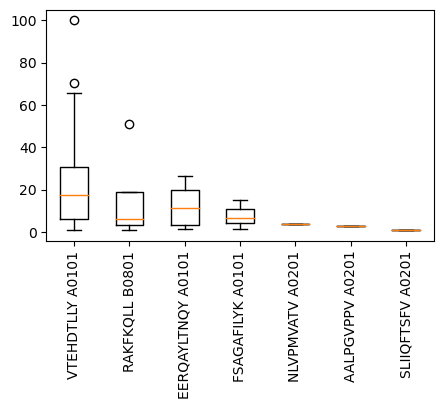

Quantiles umi_count_mhc vs mat: 181.0 181


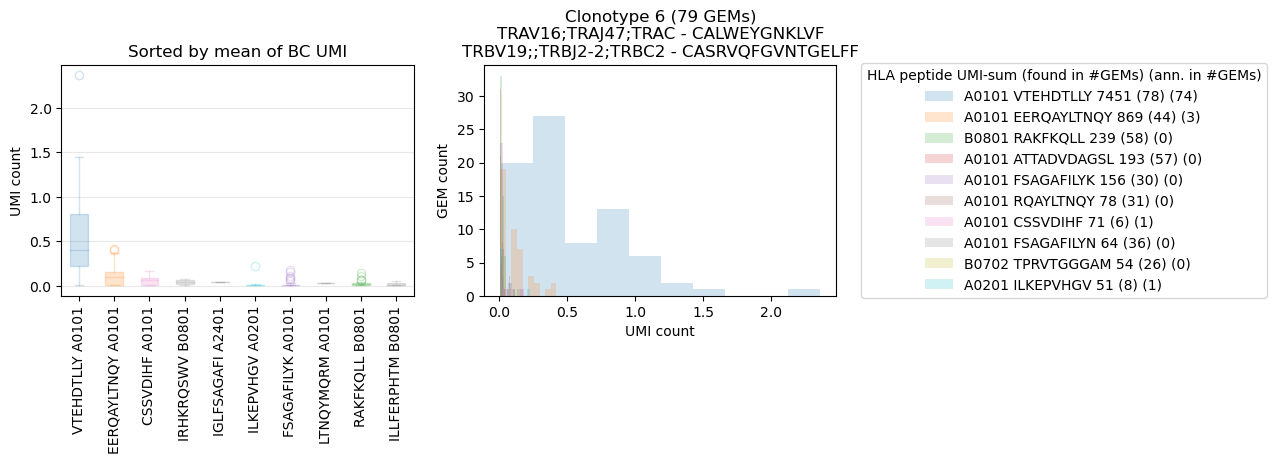

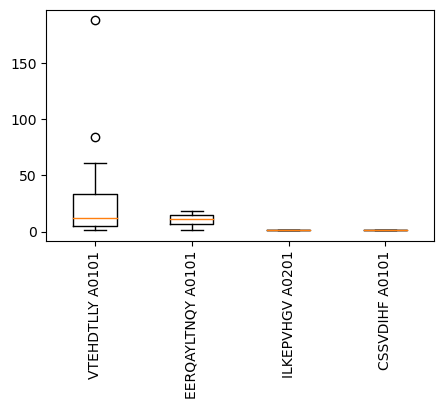

Quantiles umi_count_mhc vs mat: 120.0 120


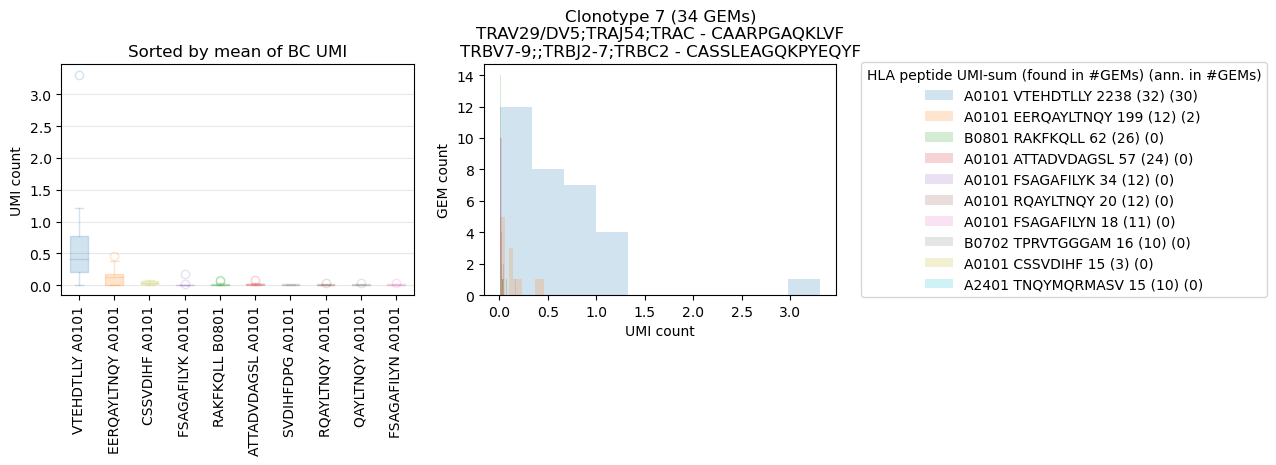

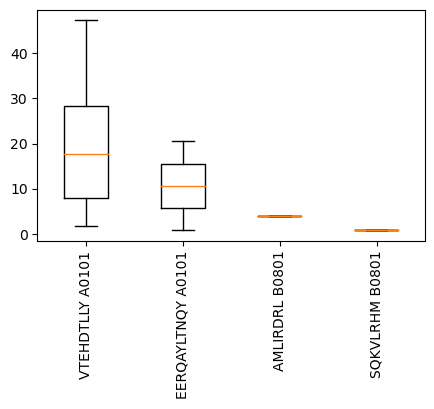

Quantiles umi_count_mhc vs mat: 173.0 173


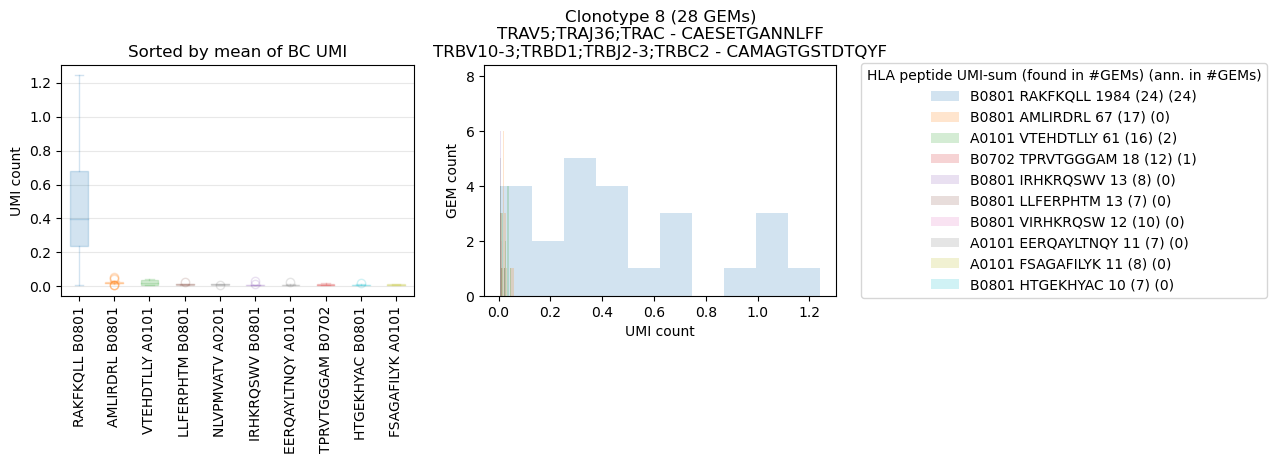

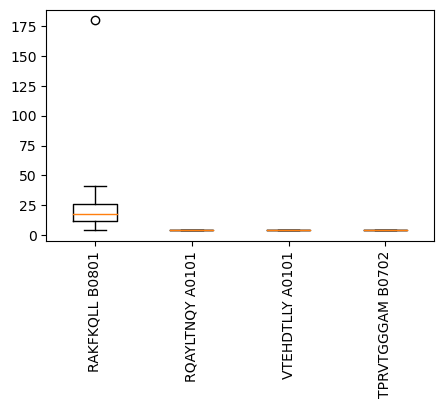

Quantiles umi_count_mhc vs mat: 94.0 94
Multiple TCR chains - in theory unsolvable!


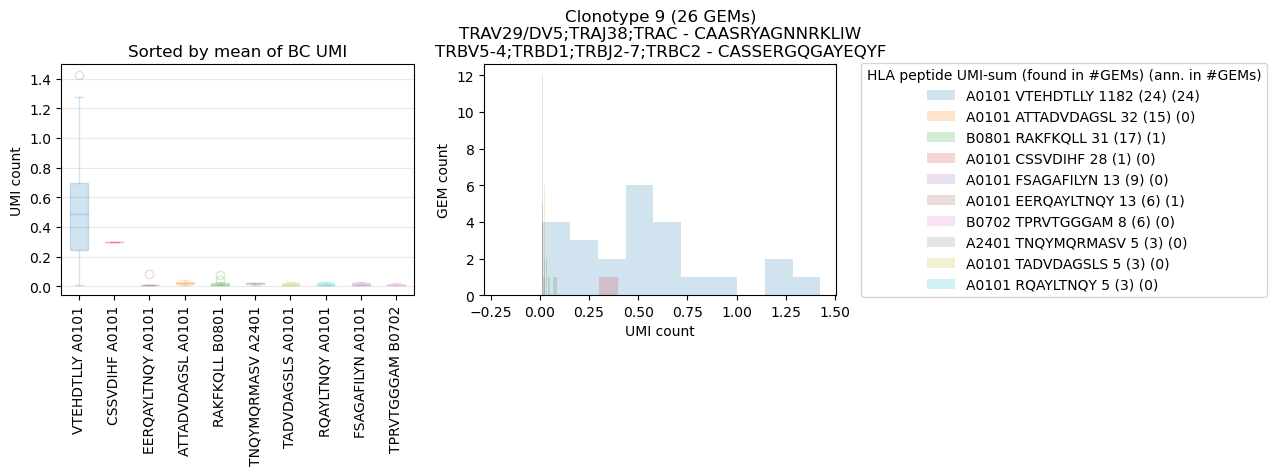

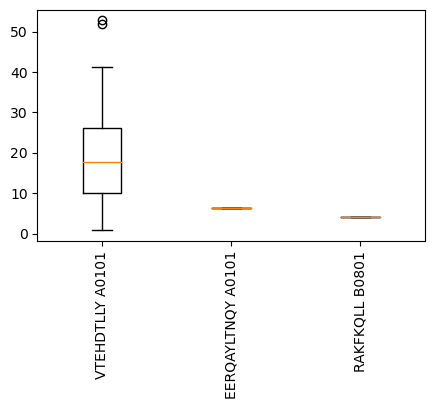

Quantiles umi_count_mhc vs mat: 2.0 2
--- Insignificant even with no sampling
unsolvable!
Multiple TCR chains - in theory unsolvable!


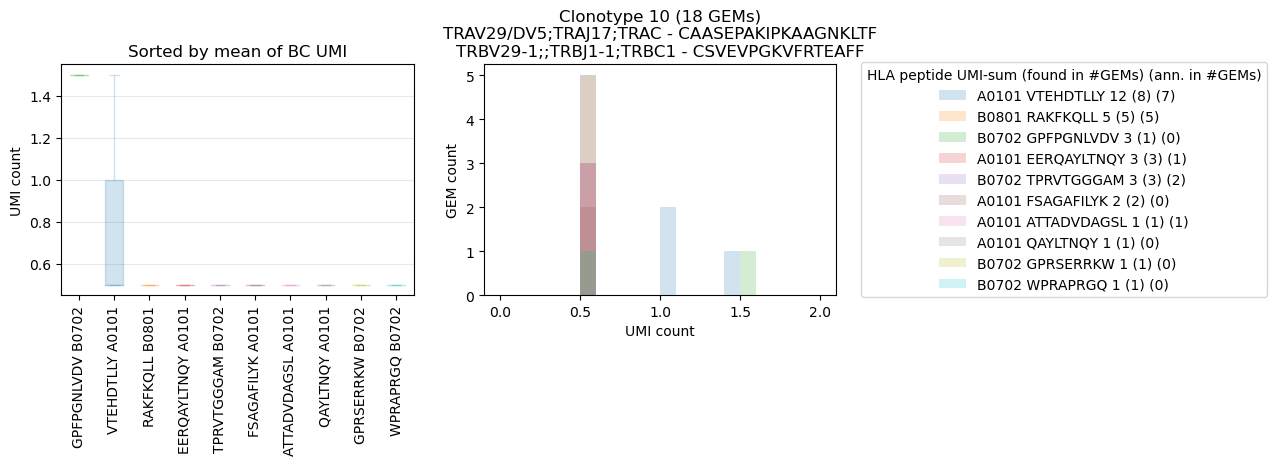

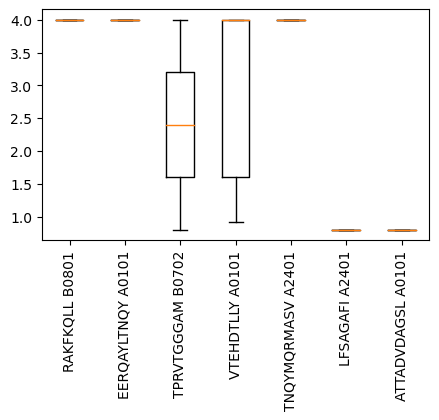

Quantiles umi_count_mhc vs mat: 158.0 158


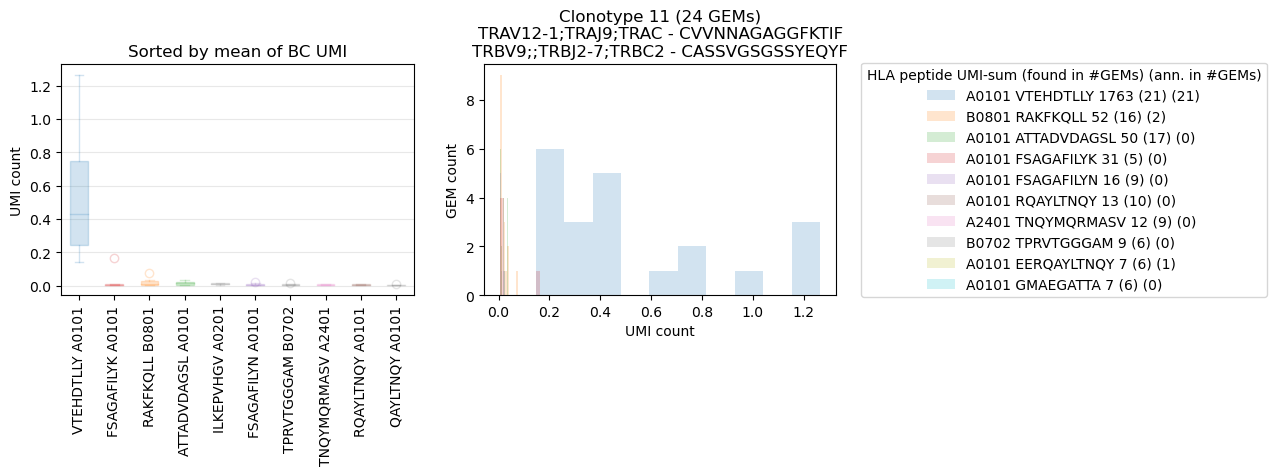

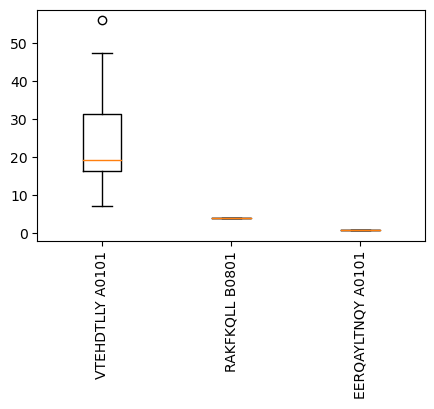

Quantiles umi_count_mhc vs mat: 1.0 1
--- Insignificant even with no sampling
unsolvable!
Multiple TCR chains - in theory unsolvable!


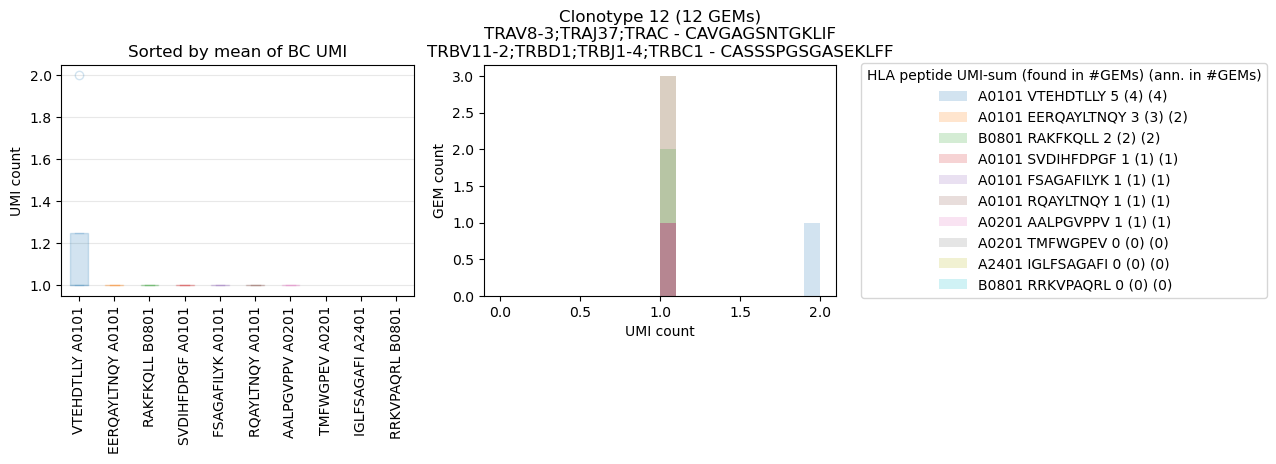

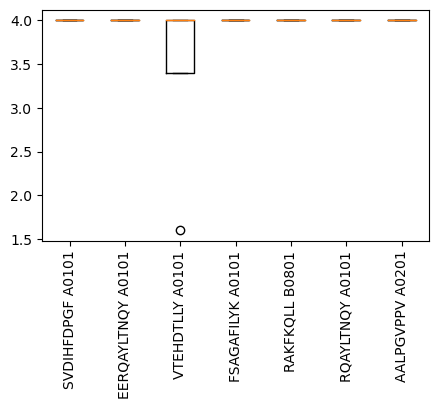

Quantiles umi_count_mhc vs mat: 73.0 73


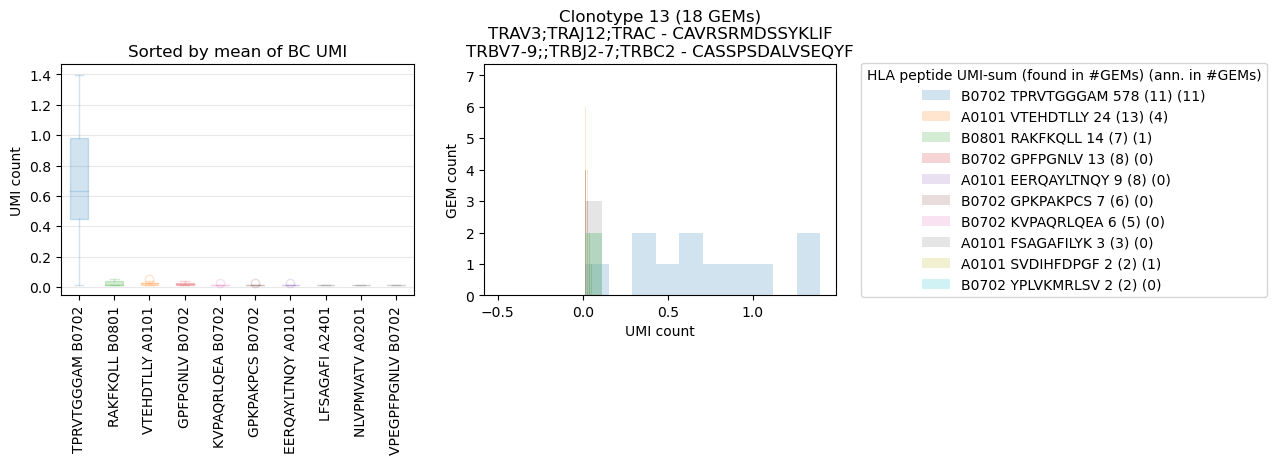

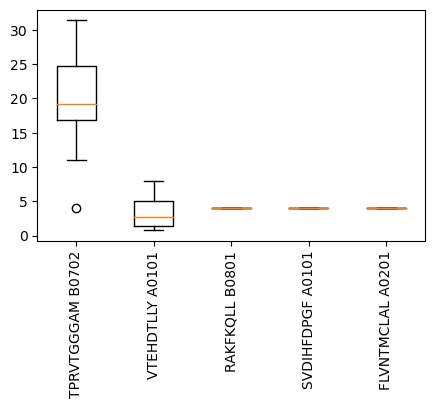

Quantiles umi_count_mhc vs mat: 48.0 48
--- Insignificant even with no sampling
14 unresolved


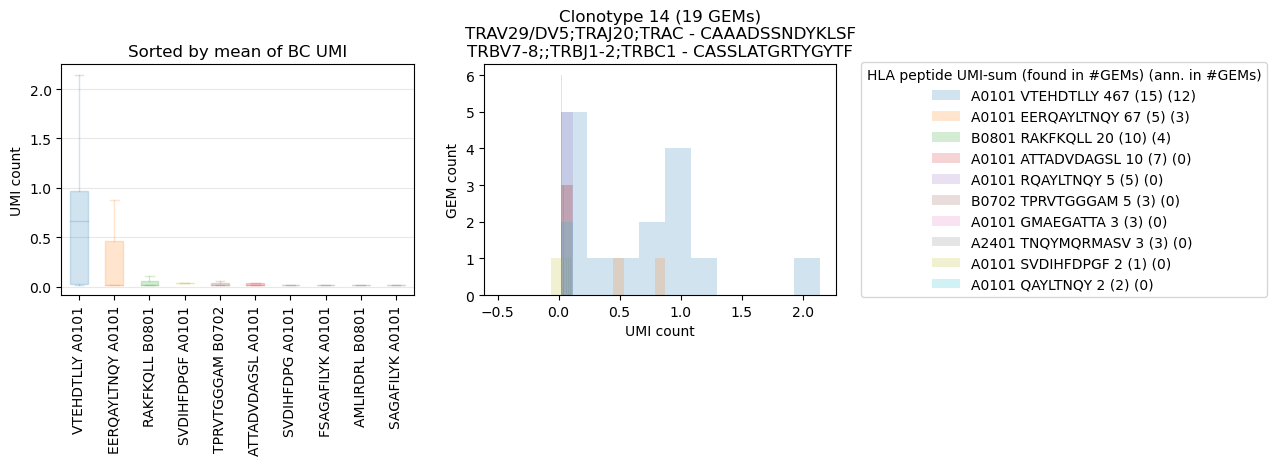

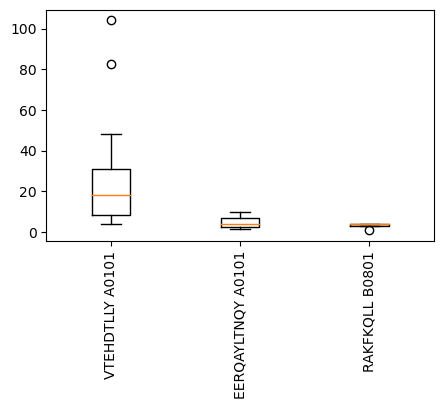

Quantiles umi_count_mhc vs mat: 11.0 11
NaN p-value
--- Insignificant even with no sampling
15 unresolved


/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


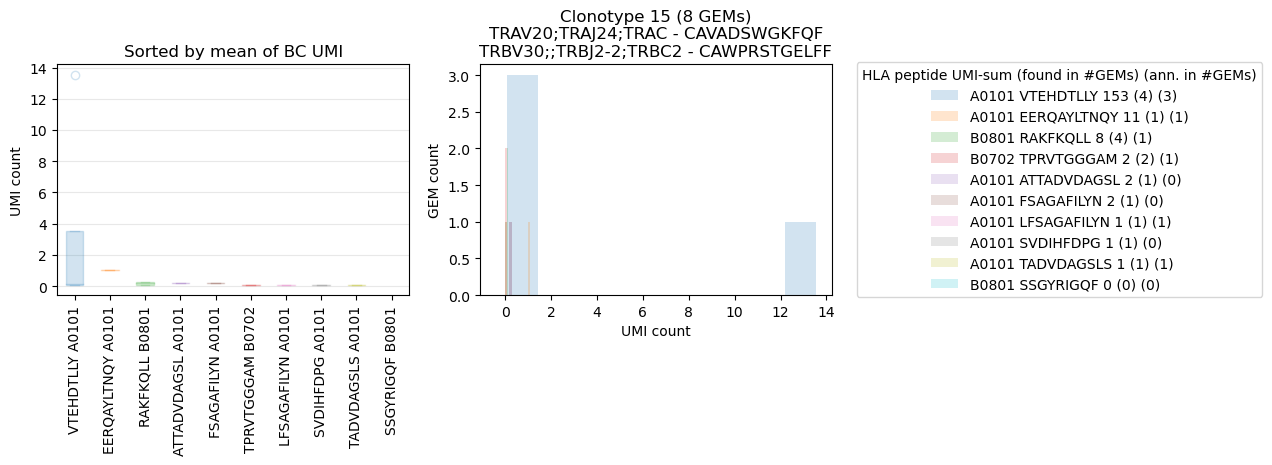

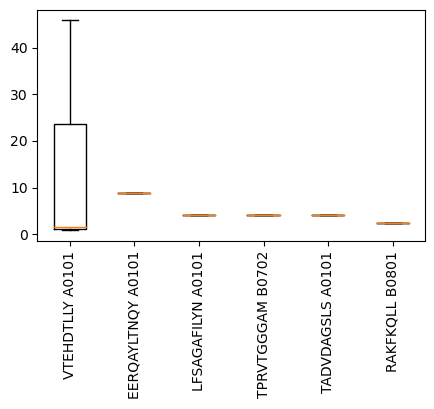

Quantiles umi_count_mhc vs mat: 2.0 2
--- Insignificant even with no sampling
16 unresolved


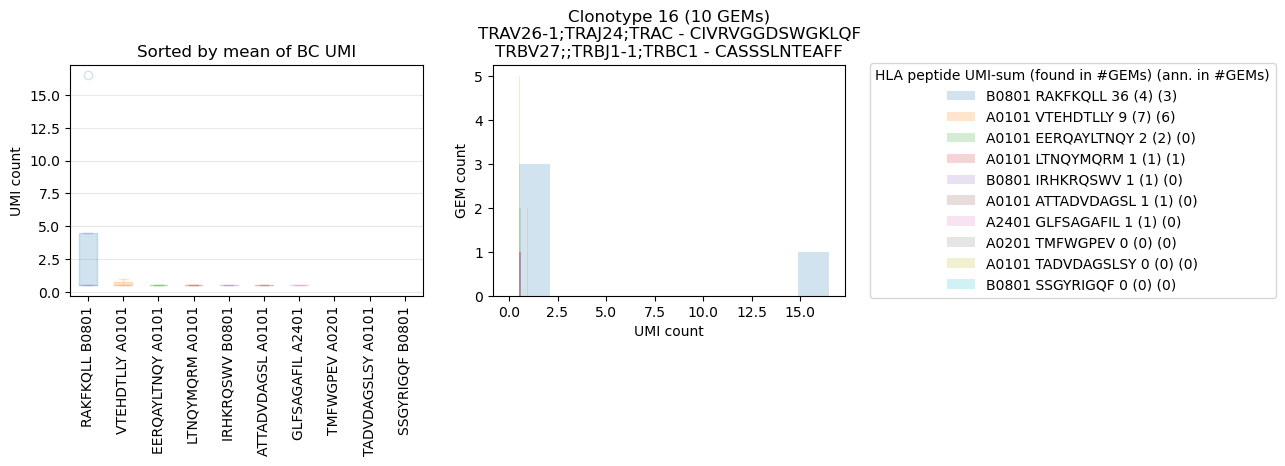

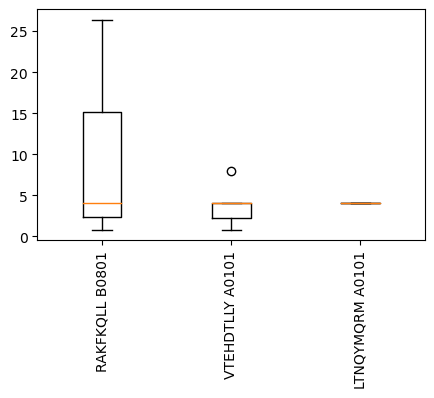

Quantiles umi_count_mhc vs mat: 130.0 130


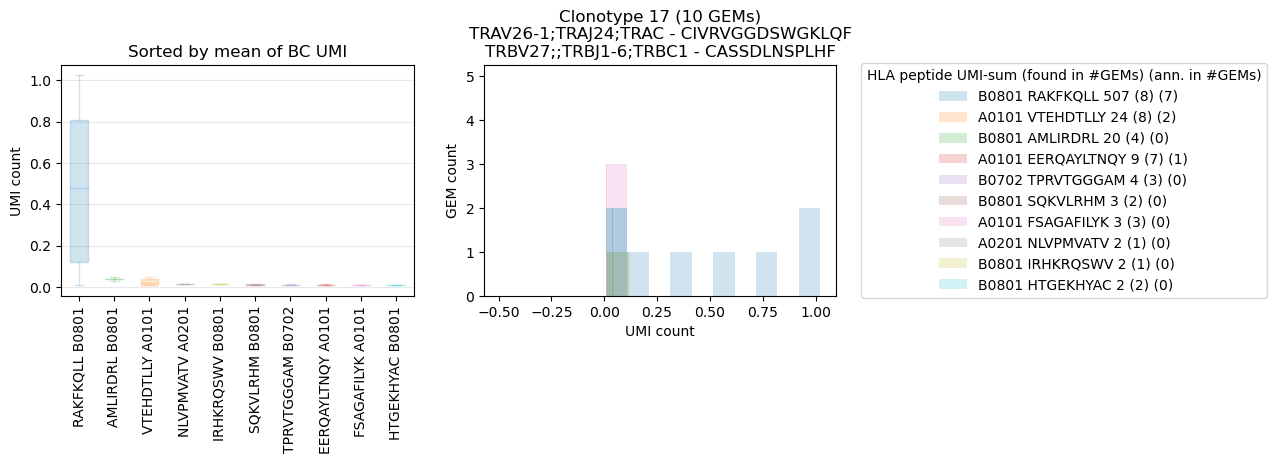

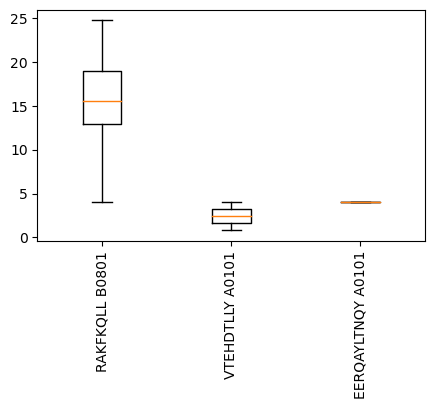

Quantiles umi_count_mhc vs mat: 4.0 4
NaN p-value
--- Insignificant even with no sampling
18 unresolved


/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


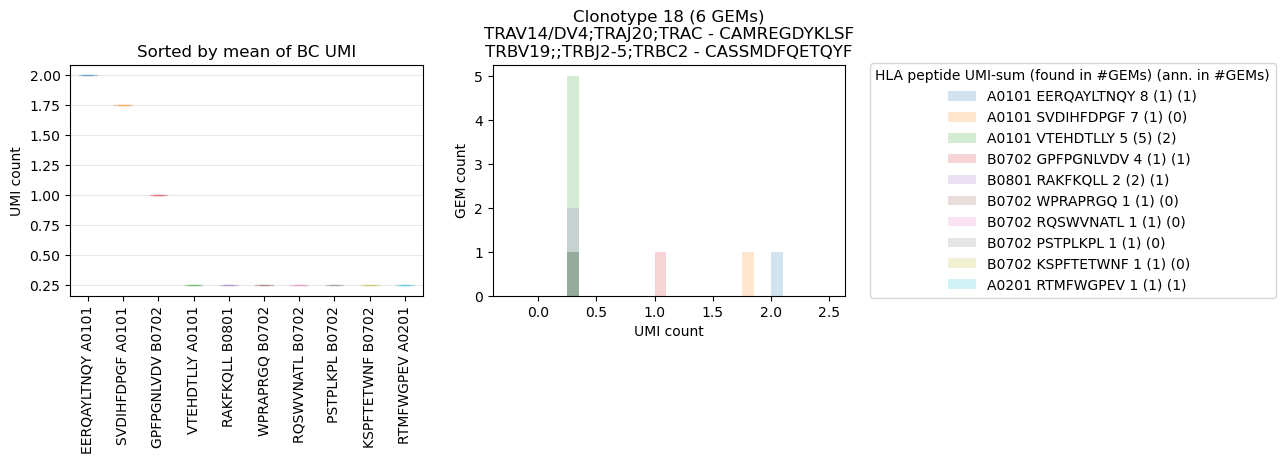

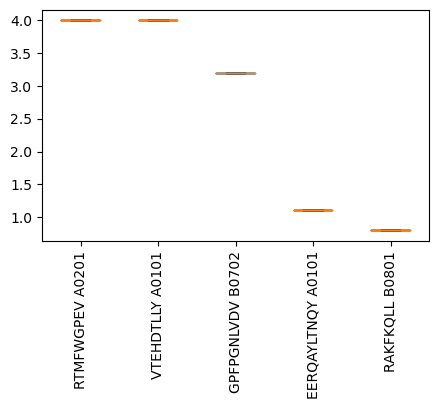

Quantiles umi_count_mhc vs mat: 133.0 133


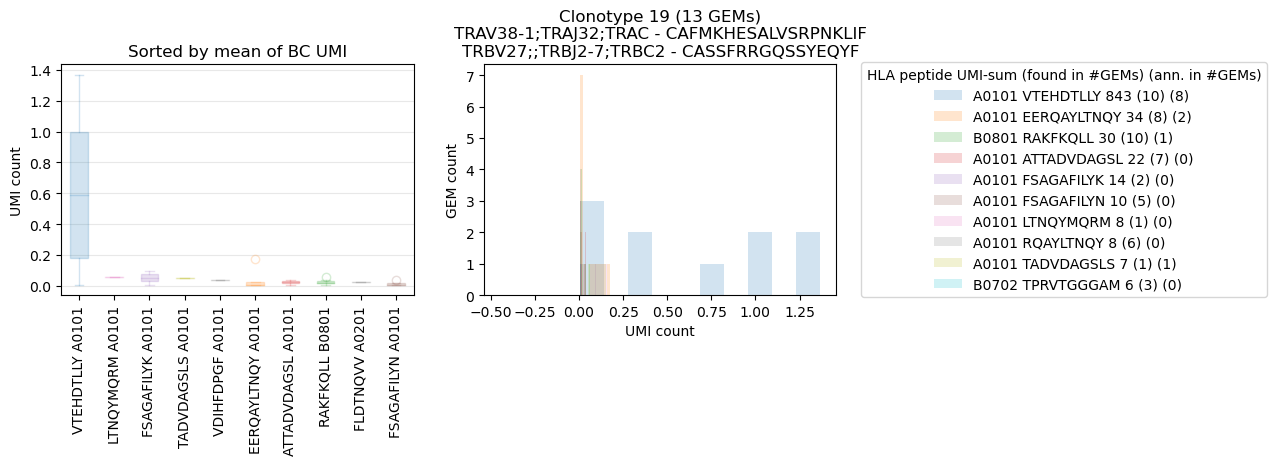

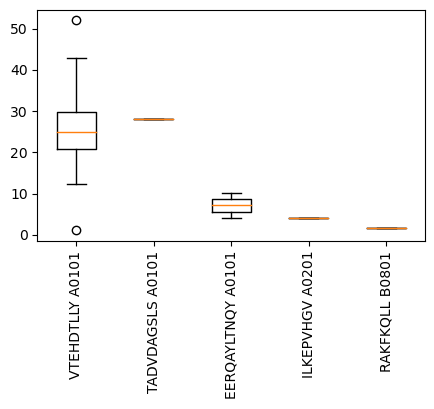

Quantiles umi_count_mhc vs mat: 6.0 6
NaN p-value
--- Insignificant even with no sampling
20 unresolved


/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


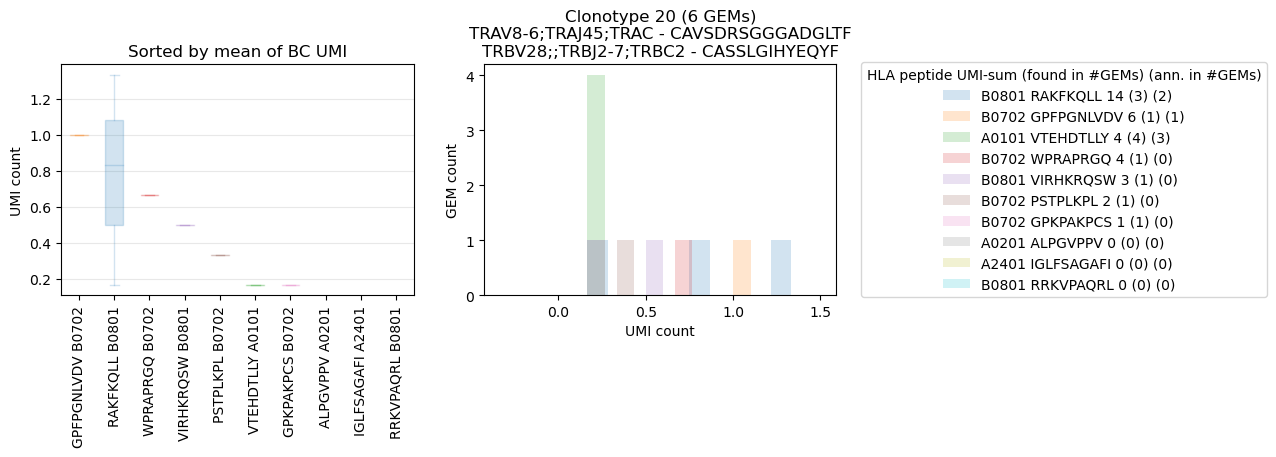

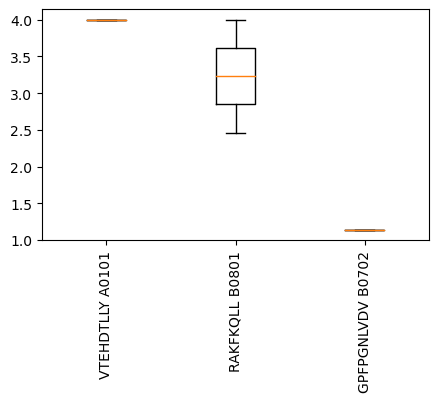

Quantiles umi_count_mhc vs mat: 2.0 2
NaN p-value
--- Insignificant even with no sampling
unsolvable!
Multiple TCR chains - in theory unsolvable!


/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


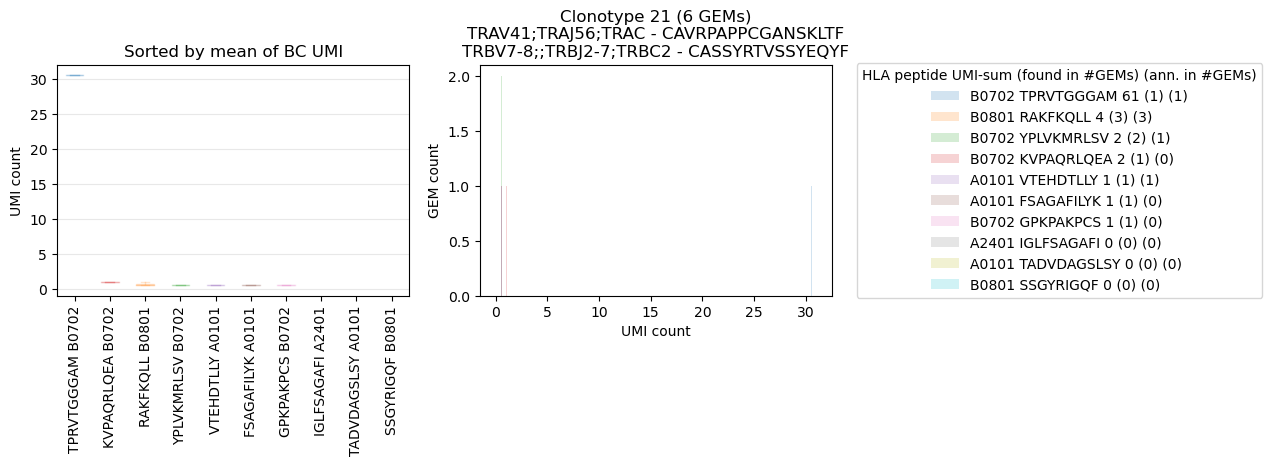

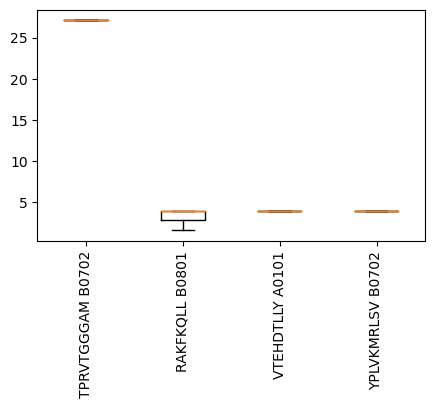

Quantiles umi_count_mhc vs mat: 212.0 212


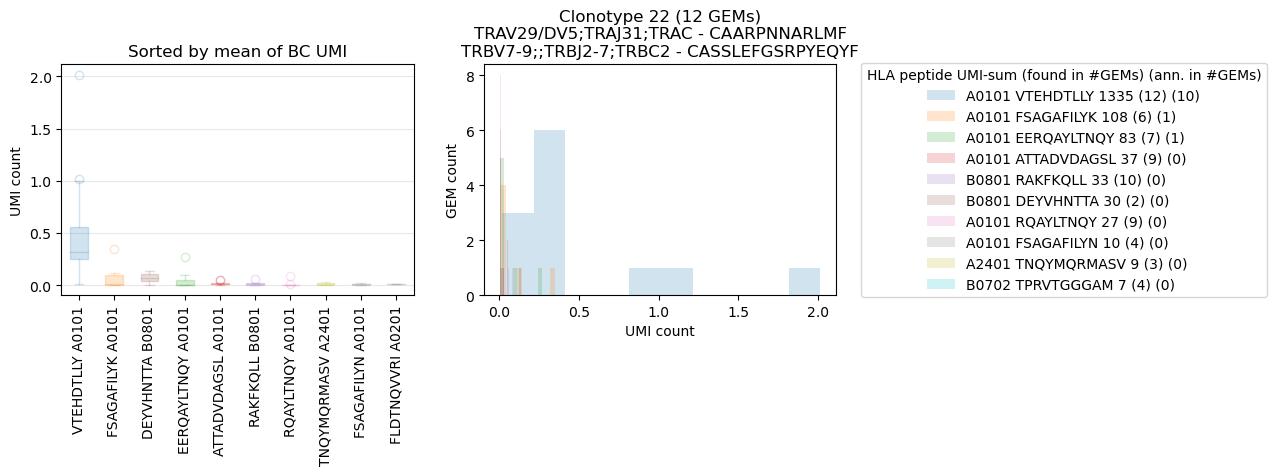

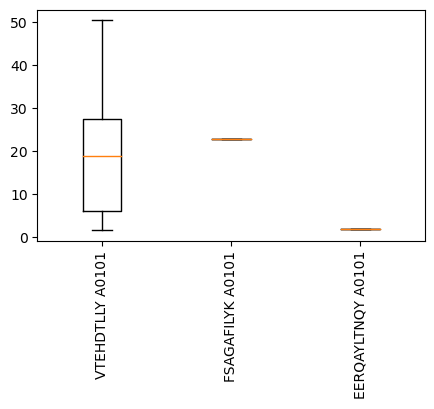

Quantiles umi_count_mhc vs mat: 4.0 4
--- Insignificant even with no sampling
23 unresolved


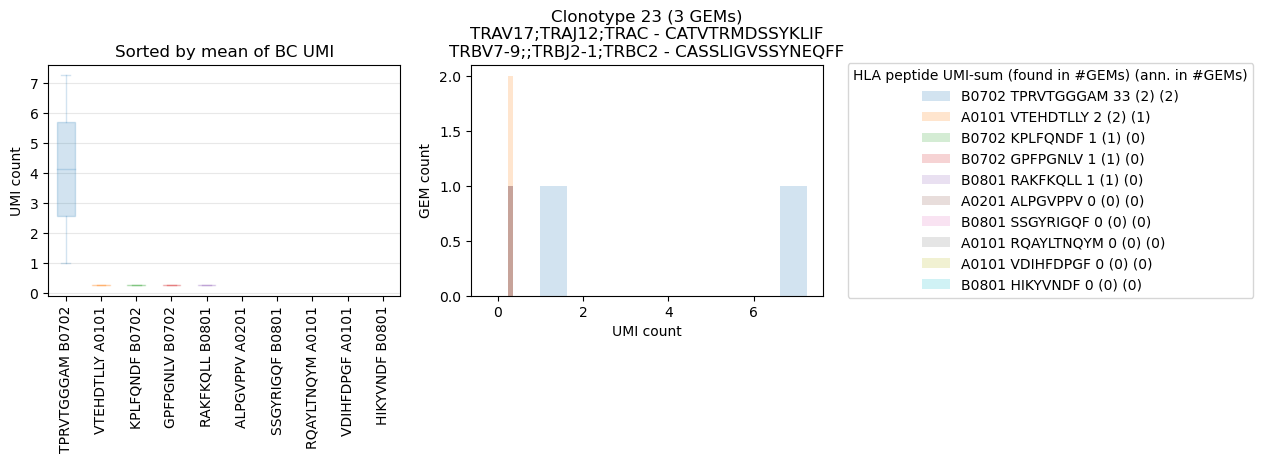

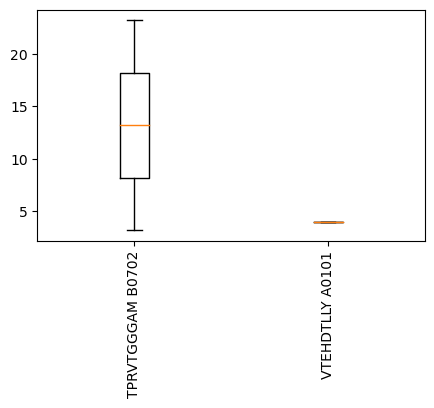

Quantiles umi_count_mhc vs mat: 7.0 7
NaN p-value
--- Insignificant even with no sampling
24 resolved by trash bin


/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


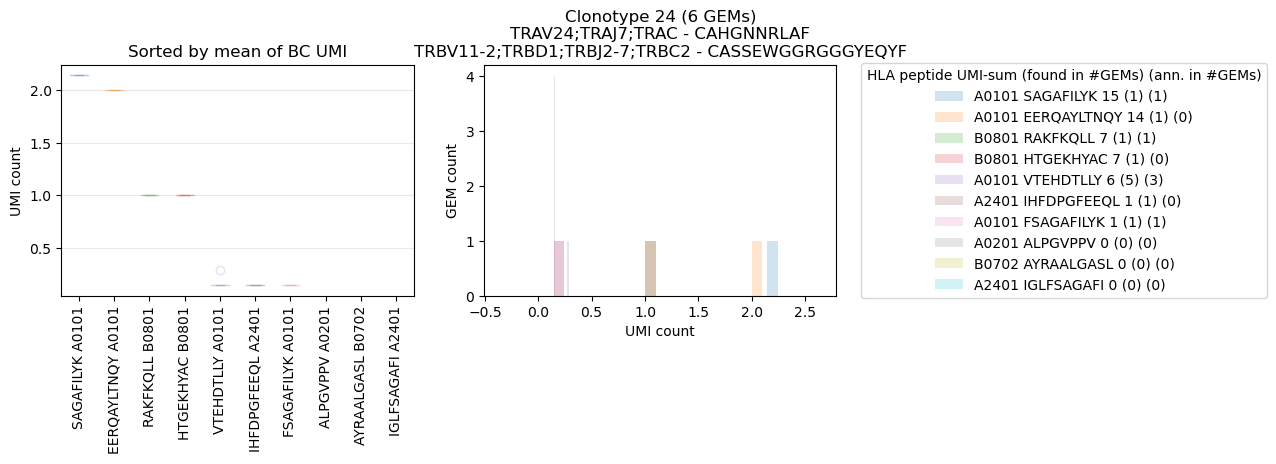

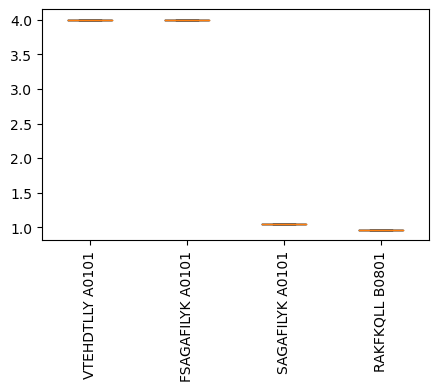

Quantiles umi_count_mhc vs mat: 1.0 1
--- Insignificant even with no sampling
25 unresolved


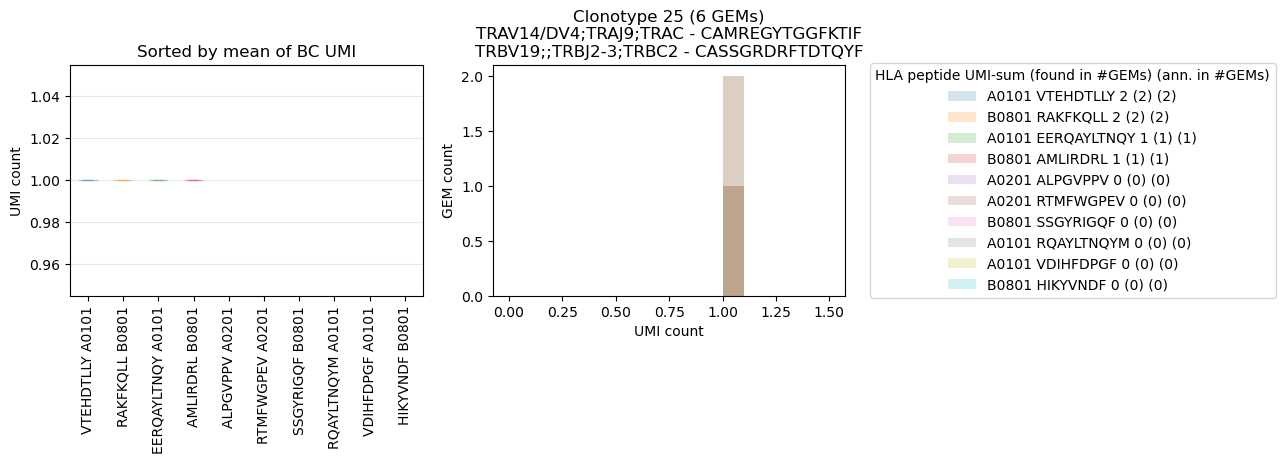

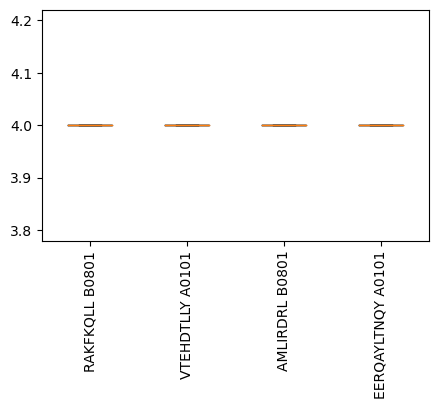

Quantiles umi_count_mhc vs mat: 81.0 81


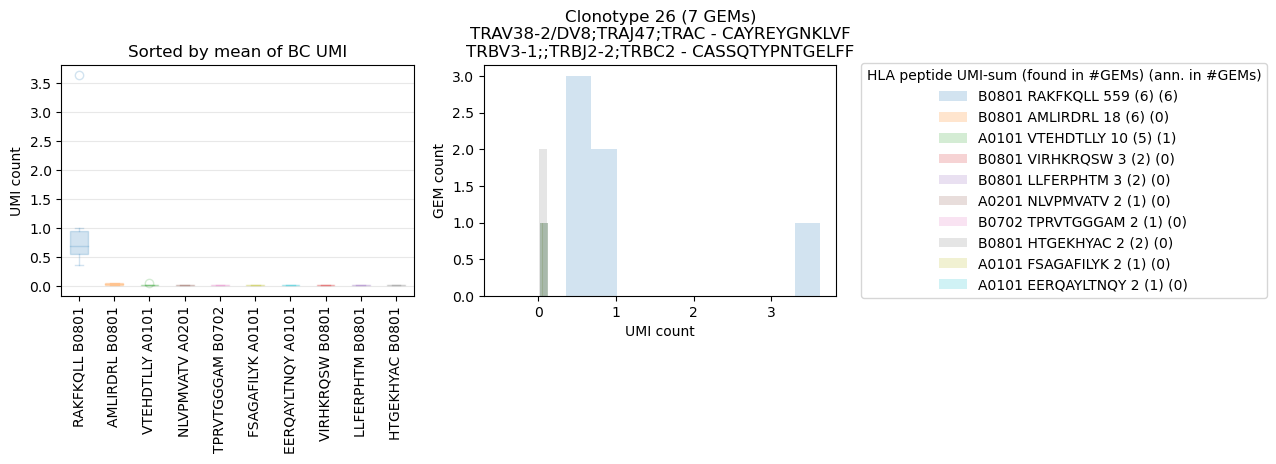

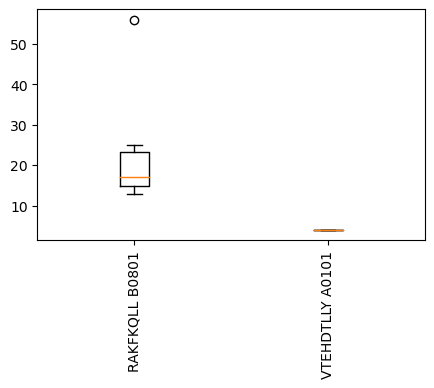

Quantiles umi_count_mhc vs mat: 24.0 24
NaN p-value
--- Insignificant even with no sampling
27 unresolved


/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


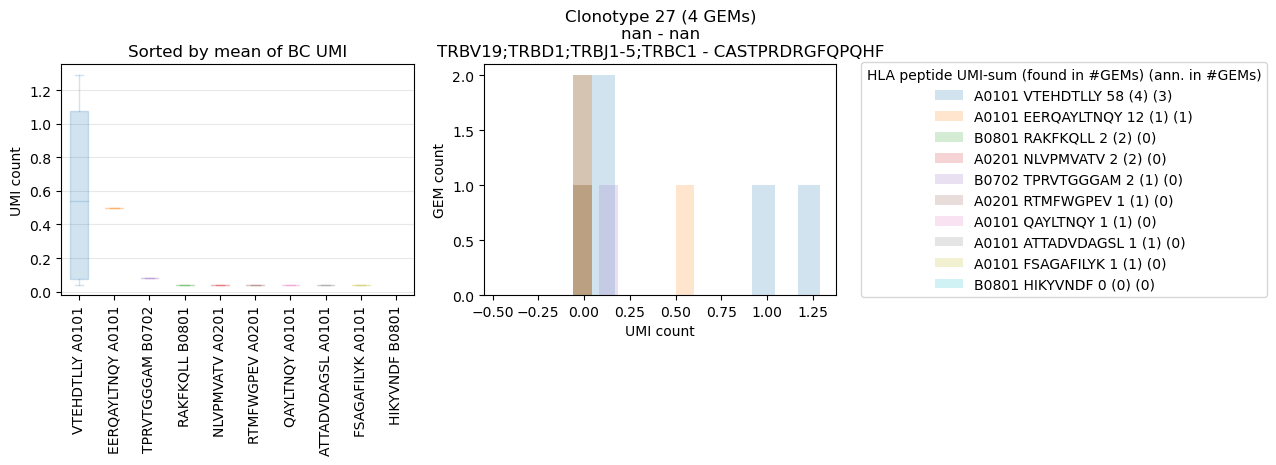

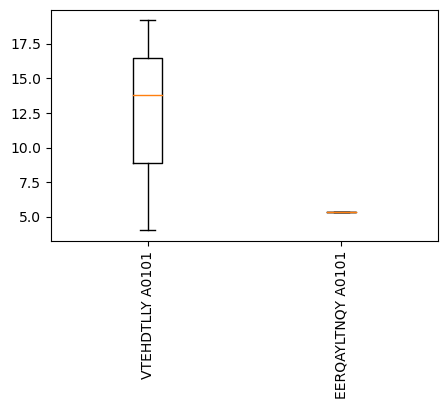

Quantiles umi_count_mhc vs mat: 11.0 11
--- Insignificant even with no sampling
28 unresolved


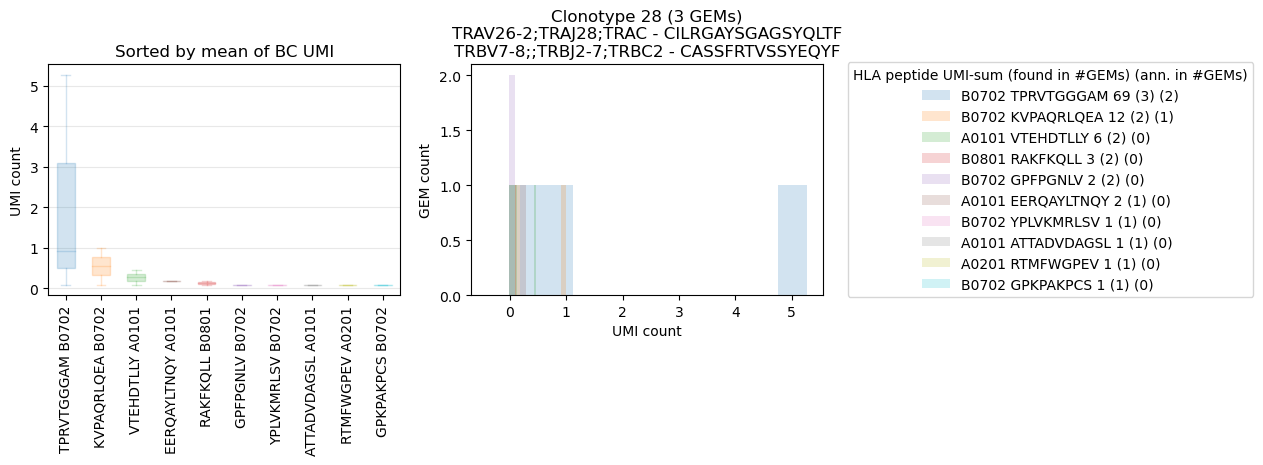

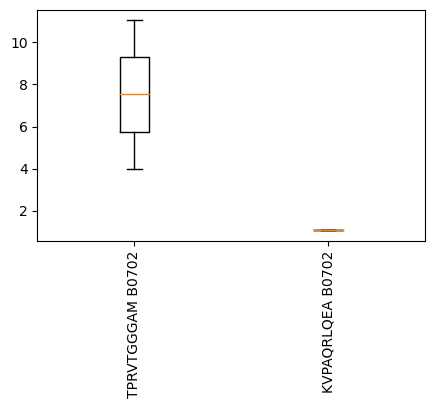

Quantiles umi_count_mhc vs mat: 34.0 34
*** Significant with no sampling


NameError: name 'alt_sign' is not defined

In [16]:
df['ct_pep'] = np.nan
trash_bin = set()
value_bin =set()
selected_clonotypes = df.groupby('ct').size().sort_values(ascending=False)#.head(10) #astype(int) ??
all_peptide_HLA = df.peptide_HLA_lst.explode()

for ct in df.ct.astype(int).sort_values().unique(): #selected_clonotypes.index:
    mat = pd.DataFrame(index=all_peptide_HLA.unique(), columns=df.gem.unique())
    df[df.ct == ct].apply(lambda row: sum_umi(row), axis=1)
    
    #summary df
    summary_df = mat.sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'s'})
    summary_df['avg'] = mat.mean(axis=1)
    summary_df['col'] = 'grey'
    summary_df['r'] = summary_df.s / summary_df.s.max() # Unnecessary
    
    # Getting the relative UMI counts per clonotype
    assert mat.max().max() == df[df.ct == ct].umi_count_mhc.max()
    print("Quantiles umi_count_mhc vs mat:", df[df.ct == ct].umi_count_mhc.quantile(0.9, interpolation='lower'), mat.max().quantile(0.9, interpolation='lower'))
    df.loc[df.ct == ct, 'umi_count_mhc_rel'] = df[df.ct == ct].umi_count_mhc / df[df.ct == ct].umi_count_mhc.quantile(0.9, interpolation='lower') #mat.max().quantile(0.9, interpolation='lower') #.max()
    mat = mat / df[df.ct == ct].umi_count_mhc.quantile(0.9, interpolation='lower') #mat.max().quantile(0.9, interpolation='lower') #.max()
    
    
    
    summed_umis = summary_df.s.head(10)
    summed_gems = (mat > 0).sum(axis=1)
    annotated_gems = df[df.ct == ct].groupby('peptide_HLA').size()
    all_gems_hla = pd.concat([annotated_gems,
                              pd.Series(0, index=all_peptide_HLA[~all_peptide_HLA.isin(annotated_gems.index)].unique())])
    
    # test if two annotations are significantly different distributed.
    if test_dist():
        # Maybe accumulate distributions for true imputations to compare with when in doubt?
        df.loc[df.ct == ct, 'ct_pep'] = summary_df.index[0]
        value_bin.update([ct])
        trash_bin.update(summary_df.index[1:10])
        figure_flag = 'significant'
        #if ct > 10:
        #    continue
    else:
        if alt_test_dist():
            alt_sign += 1
        if summary_df.index[0] not in trash_bin:
            if summary_df.index[1] not in trash_bin:
                print('HELP!')
                figure_flag = 'insignificant'
            else:
                df.loc[df.ct == ct, 'ct_pep'] = summary_df.index[0]
                trash_bin.update(summary_df.index[1:10])
                print(ct, 'resolved by trash bin')
                figure_flag = 'insignificant'
        else:
            # Highlight the clonotypes that are ambiguous
            if len(df[(df.ct == ct) & (df.tcr_category.isin(['multiple chains']))]) > 0:
                df.loc[df.ct == ct, 'ct_pep'] = 'unsolvable'
                print('unsolvable!')
                figure_flag = 'insignificant'
            else:
                # Check if distribution matches a previously accepted peptide distribution.
                df.loc[df.ct == ct, 'ct_pep'] = 'unresolved'
                print(ct, 'unresolved')
                figure_flag = 'insignificant'
            
        #print(df.loc[df.ct ==ct, ['peptide', 'peptide_lst','umi_count_lst_mhc',
        #                          'cdr3_lst_TRA','genes_lst_TRA','umi_count_lst_TRA',
        #                          'cdr3_lst_TRB','genes_lst_TRB','umi_count_lst_TRB']])
    # Highlight the clonotypes that are ambiguous
    if len(df[(df.ct == ct) & (df.tcr_category.isin(['multiple chains']))]) > 0:
        print('Multiple TCR chains - in theory unsolvable!')
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3))
    # Histogram
    for peptide_HLA in summed_umis.index:
        ax2.hist(mat.T[peptide_HLA].dropna(), alpha=0.2, label='%s %s %d (%d) (%d)' %(peptide_HLA.split(' ')[1], peptide_HLA.split(' ')[0], summed_umis[peptide_HLA], summed_gems[peptide_HLA], all_gems_hla[peptide_HLA]))
    summary_df.iloc[0:10, summary_df.columns.to_list().index('col')] = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Boxplot
    boxes = list()
    meaned_umis = summary_df.sort_values(by='avg',ascending=False).head(10)
    for peptide_HLA in meaned_umis.index:
        boxes.append(mat.T[peptide_HLA].dropna().to_list())
    bp = ax1.boxplot(boxes, patch_artist=True) #, vert=False
    colors = meaned_umis.col #.to_list()
    
    # whiskers and caps have to be treated separately since there are two of each for each plot
    for item in ['whiskers', 'caps']:
        for sub_item, color in zip(zip(bp[item][::2], bp[item][1::2]), colors):
            plt.setp(sub_item, color=color, alpha=0.2)
    for item in ['fliers']:
        for sub_item, color in zip(bp[item], colors):
            plt.setp(sub_item, markeredgecolor=color, alpha=0.2)
    for item in ['boxes', 'medians']:
        for sub_item, color in zip(bp[item], colors):
            plt.setp(sub_item, color=color, alpha=0.2)
            
    ax1.set_title('Sorted by mean of BC UMI')
    ax1.set_xticklabels(meaned_umis.index, rotation=90)
    ax1.set_ylabel('UMI count')
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    ax1.set_axisbelow(True) # Hide these grid behind plot objects
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='HLA peptide UMI-sum (found in #GEMs) (ann. in #GEMs)')
    ax2.set_xlabel('UMI count')
    ax2.set_ylabel('GEM count')
    ax2.set_title('Clonotype %d (%d GEMs)\n%s - %s\n%s - %s' %(ct, selected_clonotypes[ct],
                                               df[df.ct == ct].genes_TRA.unique()[0], df[df.ct == ct].cdr3_TRA.unique()[0],
                                               df[df.ct == ct].genes_TRB.unique()[0], df[df.ct == ct].cdr3_TRB.unique()[0]))
    #if ct == 222:
    #    plt.savefig('%s.pdf'%ct)
    #    print(summed_umis)
    #    print(summed_gems)
    #    print(all_gems_hla)
    #plt.show()
    
    #plt.savefig(PLT + figure_flag + '/%s.pdf' %ct, bbox_inches='tight')
    
    plt.figure(figsize=(5,3))
    delta = df.loc[df.ct == ct, ['delta_umi_mhc','peptide_HLA']].sort_values('delta_umi_mhc', ascending=False).groupby('peptide_HLA', sort=False).delta_umi_mhc.apply(list)
    plt.boxplot(delta.to_list()[:10])
    plt.xticks(np.arange(1, min(11, len(delta)+1)), delta.index[:10], rotation=90)
    plt.show()
    


In [17]:
df.ct.isin(value_bin)

0        True
1        True
2        True
3        True
4       False
        ...  
2262     True
2263    False
2264    False
2265     True
2266     True
Name: ct, Length: 2267, dtype: bool

In [24]:
df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr1_TRA', 'cdr2_TRA',
       'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA',
       'cdr3_lst_TRA', 'chain_count_TRA', 'single_TRA', 'length_TRB',
       'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB', 'chain_count_TRB',
       'single_TRB', 'single_chain_only', 'umi_count_tcr', 'cdr3_comb',
       'v_gene_TRA', 'j_gene_TRA', 'v_gene_TRB', 'j_gene_TRB', 'tcr_category',
       'no_filtration', 'exclude_single-chain_TCRs',
       'exclude_ambiguous_and_single-chain_TCRs', 'exclude_ambiguous_TCRs',
       'template_id_mhc', 'template_lst_mhc', 'single_barcode_mhc',
       'umi_count_mhc', 'umi_count_lst_mhc', 'read_count_mhc',
       'read_count_lst_mhc', 'multiplets_mhc', 'delta_umi_mhc',
       'template_id_cd8', 'template_lst_cd8', 'single_barcode_cd8',
       'umi_count_

In [27]:
df.loc[df.ct.isin(value_bin), ['pep_match','umi_count_mhc','umi_count_mhc_rel']].head(60)

pep_match  umi_count_mhc  umi_count_mhc_rel
0        True           68.0           0.747253
1       False            2.0           0.047619
2       False            2.0           0.047619
3        True            1.0           0.008547
5       False            1.0           0.010989
6       False            1.0           0.006329
7        True           71.0           0.780220
8        True           21.0           0.179487
10       True            2.0           0.011561
11      False            1.0           0.023810
12       True           50.0           0.549451
13      False            7.0           0.291667
14       True           59.0           0.504274
16       True           28.0           0.233333
17       True           30.0           0.714286
18       True            1.0           0.010989
19       True           45.0           0.384615
20       True           27.0           0.296703
21       True           21.0           0.875000
22       True           66.0           0.364641
23      False           26.0           0.619048
24       True           58.0           0.495726
25      False            1.0           0.005780
27      False            1.0           0.010989
28       True           45.0           0.362903
30       True           38.0           0.417582
32      False            1.0           0.041667
33       True           45.0           0.384615
35       True           10.0           0.109890
37      False            1.0           0.005780
38       True           31.0           0.264957
39       True            1.0           0.008547
40      False            3.0           0.071429
41      False            1.0           0.010989
42      False            1.0           0.023810
44       True          135.0           1.483516
46       True           39.0           0.333333
47       True           41.0           0.341667
48      False            2.0           0.021978
49       True           14.0           0.077348
50       True           51.0           0.435897
53      False            1.0           0.023810
54       True           34.0           0.373626
55      False            1.0           0.023810
56       True           30.0           0.329670
57       True           43.0           1.023810
59      False            1.0           0.023810
60       True           26.0           0.285714
61       True           37.0           0.316239
62       True           81.0           0.890110
63      False            1.0           0.023810
64       True           35.0           0.833333
65       True           61.0           1.452381
67       True           14.0           0.333333
68       True           34.0           0.290598
69      False            1.0           0.010989
70       True           74.0           0.408840
71      False            1.0           0.041667
72      False            1.0           0.023810
73      False            1.0           0.023810

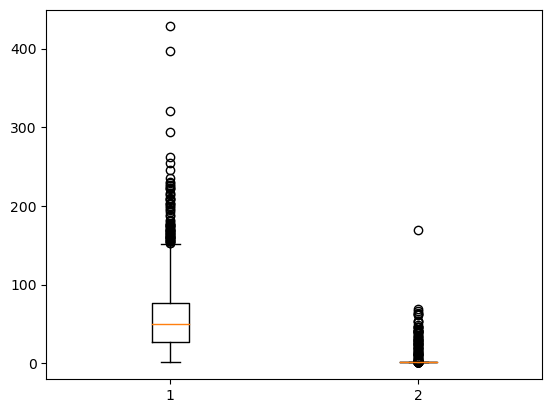

In [32]:
x = [df[(df.pep_match == True) & df.ct.isin(value_bin)].umi_count_mhc, df[(df.pep_match == False) & df.ct.isin(value_bin)].umi_count_mhc]
plt.boxplot(x)
plt.show()

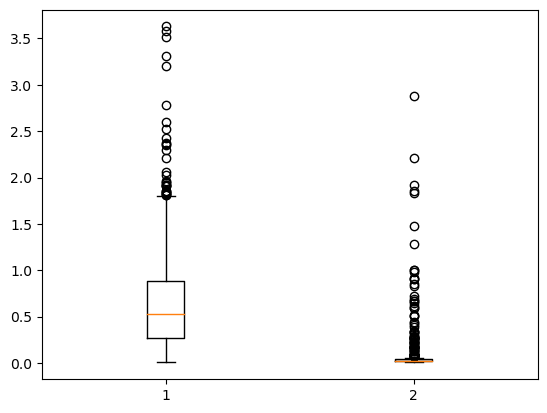

In [33]:
x = [df[(df.pep_match == True) & df.ct.isin(value_bin)].umi_count_mhc_rel, df[(df.pep_match == False) & df.ct.isin(value_bin)].umi_count_mhc_rel]
plt.boxplot(x)
plt.show()

In [58]:
df[df.ct == 50].umi_count_mhc

2314    1.0
Name: umi_count_mhc, dtype: float64

In [18]:
df['pep_match'] = df.ct_pep == df.peptide_HLA

In [19]:
value_bin

{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 17, 19, 22, 26}

In [35]:
value_bin

{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 17, 19, 26, 32, 33}

### foreward credible clonotypes to assess threshold effects

In [21]:
value_bin

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 10,
 11,
 13,
 14,
 16,
 17,
 20,
 22,
 25,
 28,
 30,
 32,
 33,
 48,
 49,
 54}

In [58]:
value_bin

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 10,
 11,
 13,
 14,
 16,
 17,
 20,
 22,
 25,
 28,
 30,
 32,
 33,
 48,
 49,
 54}

In [41]:
df[~df.ct.isin(value_bin)].ct.unique().shape

(365,)

In [20]:
tmp = df[df.ct.isin(value_bin)].fillna(0)

In [37]:
tmp.shape

(1828, 79)

In [21]:
# OBS! Old
tmp.to_csv('/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/reports/valid_ct.alive.csv')